NN_PNEUMONIA | Original file is located at
https://github.com/wwwmyroot/nn_pneumonia/NN_pneumonia_MAIN.py


In [ ]:
#@title <h1><b>---- INIT_STEP ---- Подключение библиотек.</h1></b>
# ---- INIT_STEP ---- Подключение библиотек.
# -- Библиотека TensorFlow
import tensorflow as tf
#
# -- Библиотека Numpy
import numpy as np
# -- Библиотека keras
import keras
#
# -- Time
import time as time
#
# -- Подключение нужных слоев из модуля tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
#
# -- Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#
# -- Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#
# -- Для отрисовки изображений
from PIL import Image
#
# -- Для разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
#
# -- Для отрисовки графиков
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
#
# -- Для работы с файлами
import os
#
# -- Для работы с архивами в питоне
import zipfile
# -- Для генерации случайных чисел
import random
#
# -- Модуль для для загрузки данных из облака
import gdown
import gc
#
#

In [ ]:
#@title ---- Решение дисконнекта коллаба ----

from IPython.display import Audio
# import numpy as np

Audio(np.array([0] * 2 * 3600 * 3000, dtype=np.int8), normalize=False, rate=3000, autoplay=True)

# Audio([None] * 2 * 3600 * 3000, normalize=False, rate=3000, autoplay=True)
# ---- v2
# import numpy as np
import time
!pip install mouse
import mouse
while True:
  random_row = np.random.random_sample()*100
  random_col = np.random.random_sample()*10
  random_time = np.random.random_sample()*np.random.random_sample() * 100
#  mouse.wheel(1)
#  mouse.wheel(-1)
  mouse.move(random_row, random_col, absolute=False, duration=0.2)
  mouse.move(-random_row, -random_col, absolute=False, duration = 0.2)
  mouse.LEFT
time.sleep(random_time)
# ---- v3
# from pyinput.mouse import Button, Controller
# import time
#
# mouse = Controller()
#
# while True:
#  mouse.click(Button.left, 1)
#  time.sleep(30)

In [ ]:
#@title <h1><b>---- WORKER_2 ---- </h1></b>
# ---- WORKER_2 ----
#
class Worker2:
  def __init__(self):
    self.IMAGE_PATH = '/content/data/'
    self.CLASS_LIST = None
    self.CLASS_COUNT = None
#
  def load_dataset(self):
    # Загрузка из облака
    gdown.download('https://storage.yandexcloud.net/aiueducation/marketing/datasets/chest_xray.zip', None)
    # Разархивация датасета в директорию '/content/data'
    # -- в коллабе:
    !unzip -qo "chest_xray.zip" -d /content/data
    #
    # -- CLI python:
    # python -m zipfile -e chest_xray.zip /content/data/
    #
    # средствами питона
    if not os.path.exists("/content/data"):
      os.makedirs("/content/data")
    #
    try:
      with zipfile.ZipFile("chest_xray.zip", "r") as zip_ref:
        zip_ref.extractall("/content/data")
    except zipfile.BadZipFile:
      print("(!)ERROR: Файл архива поврежден или не является архивом.")
#
#
    self.CLASS_LIST = sorted(os.listdir(self.IMAGE_PATH))
    self.CLASS_COUNT = len(self.CLASS_LIST)
    print(f'Датасет загружен!\n')
    print(f'Количество классов: {self.CLASS_COUNT}')
    res = "\n  * ".join(self.CLASS_LIST)
    print(f'Метки классов:\n  * {res}')
#
  def show_samples(self, count = 3):
    n_rows = count
    # Создание заготовки для изображений всех классов
    fig, axs = plt.subplots(n_rows, self.CLASS_COUNT, figsize=(35, 5*n_rows-5))
    # Для всех номеров классов:
    for i in range(self.CLASS_COUNT):
      for j in range(n_rows):
        # Формирование пути к папке содержимого класса
        car_path = f'{self.IMAGE_PATH}{self.CLASS_LIST[i]}/'
        # Выбор случайного фото из i-го класса
        img_path = car_path + random.choice(os.listdir(car_path))
        # Отображение фотографии
        axs[j][i].set_title(self.CLASS_LIST[i])
        axs[j][i].imshow(Image.open(img_path))
        axs[j][i].axis('off')
    # Отрисовка всего полотна
    plt.show()
#
  def dataset_info(self):
    # Cписок путей к файлам картинок
    self.data_files = []
    # Список меток классов, соответствующих файлам
    self.data_labels = []
    # Количество файлов каждого класса
    cnt_files = []
    # Для всех классов по порядку номеров (их меток)
    for class_label in range(self.CLASS_COUNT):
        # Выборка имени класса из списка имен
        class_name = self.CLASS_LIST[class_label]
        # Формирование полного пути к папке с изображениями класса
        class_path = self.IMAGE_PATH + class_name
        # Получение списка имен файлов с изображениями текущего класса
        class_files = os.listdir(class_path)
        cnt_files.append(len(class_files))
        print(f'Размер класса {class_name} составляет {len(class_files)}')
        # Добавление к общему списку всех файлов класса с добавлением родительского пути
        self.data_files += [f'{class_path}/{file_name}' for file_name in class_files]
        # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
        self.data_labels += [class_label] * len(class_files)
#
    print('\nОбщий размер базы для обучения:', len(self.data_labels))
    plt.figure(figsize=(25, 8))
    plt.bar(self.CLASS_LIST, cnt_files)
    plt.show()
#
  def create_sets(self, size=(64, 64)):
    # Ширина изображения
    IMG_WIDTH = size[0]
    # Высота изображения
    IMG_HEIGHT = size[1]
    # Пустой список для данных изображений
    data_images = []

    for file_name in self.data_files:
        # Открытие и смена размера изображения
        img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
        # Конвертация изображений в режиме CMYK в режим RGB
        if img.mode == 'CMYK':
          img = img.convert('RGB')

        # Перевод в numpy-массив
        img_np = np.array(img)
        # Добавление изображения в виде numpy-массива к общему списку
        data_images.append(img_np)
#
#
    # Перевод общего списка изображений в numpy-массив
    x_data = np.array(data_images)
    # Перевод общего списка меток класса в numpy-массив
    y_data = np.array(self.data_labels)

    # Нормированние массива изображений
    x_data = x_data / 255.
                                                    # набор параметров
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    # набор меток классов
                                                    y_data,
                                                    # процент в тестовую
                                                    test_size=0.2,
                                                    #  перемешивание
                                                    shuffle=True,
                                                    # воспроизводимость
                                                    random_state=3)
    print(f'Размер обучающей выборки: {x_train.shape}')
    print(f'Размер проверочной выборки: {x_test.shape}')
    self.sets = (x_train, x_test, y_train, y_test)
    gc.collect()
    return x_train, x_test, y_train, y_test
#
  def create_sets_augmentation(self, size=(64, 64)):
    # Папка для обучающего набора данных
    TRAIN_PATH          = '/content/data'
    # Доля тестовых данных в общем наборе
    TEST_SPLIT          = 0.1
    # Доля проверочной выборки в обучающем наборе
    VAL_SPLIT           = 0.2
    # Ширина изображения для нейросети
    IMG_WIDTH           = size[0]
    # Высота изображения для нейросети
    IMG_HEIGHT          = size[1]
    # Количество каналов (для RGB равно 3, для Grey равно 1)
    IMG_CHANNELS        = 3
    # Параметры аугментации
    ## Пределы поворота
    ROTATION_RANGE      = 8
    ## Пределы сдвига по горизонтали
    WIDTH_SHIFT_RANGE   = 0.15
    ## Пределы сдвига по вертикали
    HEIGHT_SHIFT_RANGE  = 0.15
    ## Пределы увеличения/уменьшения
    ZOOM_RANGE          = 0.15
    ## Пределы изменения яркости
    BRIGHTNESS_RANGE    = (0.7, 1.3)
    ## Горизонтальное отражение разрешено
    HORIZONTAL_FLIP     = True
#
    # Число эпох обучения
    EPOCHS              = 60
    # Размер батча для обучения модели
    BATCH_SIZE          = 24
    # Оптимизатор
    OPTIMIZER           = Adam(0.0001)
    train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )
    self.train_generator = train_datagen.flow_from_directory(
              # Путь к обучающим изображениям
              TRAIN_PATH,
              # Параметры требуемого размера изображения
              target_size=size,
              # Размер батча
              batch_size=BATCH_SIZE,
              # Тип набора данных
              class_mode='categorical',
              # Перемешивание
              shuffle=True,
              # Указание сгенерировать обучающую выборку
              subset='training'
          )
#
    # Проверочная выборка также генерируется из папки обучающего набора
    self.validation_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        # Указание сгенерировать проверочную выборку
        subset='validation'
    )
    print('Выборки сформированы')
#
#
#
  def ShowConfusionMatrix(self, model, x_test, y_test):
    cm = confusion_matrix(y_test,
                          np.argmax(model.predict(x_test, verbose=0), axis=1),
                          normalize = 'true')
#
    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.CLASS_LIST)
    disp.plot(ax=ax)
    # Стирание ненужной цветовой шкалы
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.grid(False)
    # Наклон меток горизонтальной оси при необходимости
    fig.autofmt_xdate(rotation=45)
    plt.show()
#
  def show_learning_information(self, history, model, augmentation=False):
    print('График обучения:')
    # Создание полотна для рисунка
    plt.figure(1, figsize=(10, 6))
#
    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    # Фиксация графиков и рисование всей картинки
    plt.show()
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history.history["accuracy"]).max(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history.history["val_accuracy"]).max(), 3)}')
#
    if not augmentation:
      print('\nМатрица ошибок для обучающей выборки:')
      self.ShowConfusionMatrix(model, self.sets[0], self.sets[2])
      print('\nМатрица ошибок для проверочной выборки:')
      self.ShowConfusionMatrix(model, self.sets[1], self.sets[3])
#
  def train_model(self, funcModel, count):
    # Обучение модели сверточной нейронной сети на подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()
      store_learning = model.fit(x_train,
                                y_train,
                                validation_data=(x_test, y_test),
                                shuffle=True,
                                batch_size=25,
                                epochs=50,
                                verbose=0)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      print(f'Обучение №{i+1} завершено. Результаты')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      plt.figure(1, figsize=(10, 6))
      plt.plot(store_learning.history['accuracy'],
              label='Доля верных ответов на обучающем наборе')
      plt.plot(store_learning.history['val_accuracy'],
              label='Доля верных ответов на проверочном наборе')
      plt.xlabel('Эпоха обучения')
      plt.ylabel('Доля верных ответов')
      plt.legend()
      plt.show()
      print('\n'*3)
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')
#
  def train_model_augmentation(self, funcModel, count):
    # Обучение модели сверточной нейронной сети на подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()
      store_learning = model.fit(self.train_generator,
                           validation_data=self.validation_generator,
                           batch_size=25,
                           epochs=20,
                           verbose=1)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      print(f'Обучение №{i+1} завершено. Результаты')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      plt.figure(1, figsize=(10, 6))
      plt.plot(store_learning.history['accuracy'],
              label='Доля верных ответов на обучающем наборе')
      plt.plot(store_learning.history['val_accuracy'],
              label='Доля верных ответов на проверочном наборе')
      plt.xlabel('Эпоха обучения')
      plt.ylabel('Доля верных ответов')
      plt.legend()
      plt.show()
      print('\n'*3)
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')
#
  def getdataforpretrainmodel(self, image_size):
    # Присваиваем путь к базе в переменную data_dir
    data_dir = '/content/data/'
    # Определяем batch size
    batch_size = 32
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      # Путь к изображениям
      data_dir,
      # Устанавливаем разделение на обучающую и проверочную выборки (20%)
      validation_split = 0.2,
      # Помечаем, что выборка обучающая (80%)
      subset = "training",
      # Дополнительное случайное начальное число для перетасовки и преобразований
      seed = 123,
      # Размер изображений, который был задан ранее
      image_size = image_size,
      # Размер батча, который был задан ранее
      batch_size = batch_size)
#
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      # Путь к изображениям
      data_dir,
      # Устанавливаем разделение на обучающую и проверочную выборки (20%)
      validation_split = 0.2,
      # Помечаем, что выборка проверочная (20%)
      subset = "validation",
      # Дополнительное случайное начальное число для перетасовки и преобразований
      seed = 123,
      # Размер изображений, который был задан ранее
      image_size = image_size,
      # Размер батча, который был задан ранее
      batch_size = batch_size)
#
    # Определяем имена классов:
    class_names = train_ds.class_names
    AUTOTUNE = tf.data.AUTOTUNE
    # Предварительная обучающая выборка
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    # Предварительная тестовая выборка
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#
    # Дополнительная аугментация в виде слоя для модели (для увеличения базы изображений)
    data_augmentation = tf.keras.Sequential([
      # Произвольное увеличение и уменьшение на 10%
      tf.keras.layers.experimental.preprocessing.RandomZoom((-0.05, 0.05)),
      # Изменение контраста изображений
      tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)])
    return class_names, data_augmentation, train_ds, val_ds
#
  @staticmethod
  def plot_graph(train_acc, val_acc, train_loss, val_loss):
    '''
    Функция выведет на экран графики точности и ошибки на проверочной и обучающей выборках.
    '''
    sns.set(style='darkgrid', palette='dark')
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.title('Точность', fontweight='bold')
    plt.plot(train_acc, label='Точность на обучащей выборке')
    plt.plot(val_acc, label='Точность на проверочной выборке')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
#
    plt.subplot(2, 2, 2)
    plt.title('Ошибка', fontweight='bold')
    plt.plot(train_loss, label='Ошибка на обучающей выборке')
    plt.plot(val_loss, label='Ошибка на проверочной выборке')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.legend()
#
    plt.show()
#
  def createAndTrainNASNetMobile(self):
    # Определяем размер изображений
    image_size = (224, 224)
    data = self.getdataforpretrainmodel(image_size)
#
#
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.nasnet.preprocess_input
    # Сборка мусора для освобождения памяти
    gc.collect()
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
    # Создаем базовую модель NASNetMobile:
    base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели NASNetMobile:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
    # Компилируем модель:
    ## Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  # Ошибка SparseCategoricalCrossentropy
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # Метрика Accuracy
                  metrics=['accuracy'])
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
    # Обучаем модель:
    # Обучающая выборка
    hNASNetMobile = model.fit(data[2],
                              # Количество эпох обучения, заданное ранее
                              epochs=epochs,
                              # Проверочная выборка
                              validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hNASNetMobile.history['accuracy'],
              hNASNetMobile.history['val_accuracy'],
              hNASNetMobile.history['loss'],
              hNASNetMobile.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hNASNetMobile.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hNASNetMobile.history["val_accuracy"]),3)}')
#
    return model
#
  def createAndTrainResNet(self):
    image_size = (224, 224)     # Определяем размер изображений
    data = self.getdataforpretrainmodel(image_size)
#
#
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    # Сборка мусора для освобождения памяти
    gc.collect()
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
    # Создаем базовую модель ResNet50:
    base_model = tf.keras.applications.resnet50.ResNet50(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели ResNet50:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
    # Компилируем модель:
    ## Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  # Ошибка SparseCategoricalCrossentropy
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # Метрика Accuracy
                  metrics=['accuracy'])
#
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
    # Обучаем модель:
    ## Обучающая выборка
    hResNet50 = model.fit(data[2],
                          # Количество эпох обучения, заданное ранее
                          epochs=epochs,
                          # Проверочная выборка
                          validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hResNet50.history['accuracy'],
              hResNet50.history['val_accuracy'],
              hResNet50.history['loss'],
              hResNet50.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hResNet50.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hResNet50.history["val_accuracy"]),3)}')
#
    return model
#
  def createAndTrainResNet50V2(self):
    # Определяем размер изображений
    image_size = (224, 224)
    data = self.getdataforpretrainmodel(image_size)
#
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    # Сборка мусора для освобождения памяти
    gc.collect()
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
#
    # Создаем базовую модель ResNet50V2:
    base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели ResNet50V2:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
#
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
    # Компилируем модель:
    ## Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                # Ошибка SparseCategoricalCrossentropy
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                # Метрика Accuracy
                metrics=['accuracy'])
#
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
    # Обучаем модель:
    ## Обучающая выборка
    hResNet50V2 = model.fit(data[2],
                            # Количество эпох обучения, заданное ранее
                            epochs=epochs,
                            # Проверочная выборка
                            validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hResNet50V2.history['accuracy'],
            hResNet50V2.history['val_accuracy'],
            hResNet50V2.history['loss'],
            hResNet50V2.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hResNet50V2.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hResNet50V2.history["val_accuracy"]),3)}')
#
    return model
#
#
  def createAndTrainVGG16(self):
    # Определяем размер изображений
    image_size = (224, 224)
    data = self.getdataforpretrainmodel(image_size)
#
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    # Сборка мусора для освобождения памяти
    gc.collect()
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
#
# Создаем базовую модель VGG16:
    base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели VGG16:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
    # Компилируем модель:
    ## Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  # Ошибка SparseCategoricalCrossentropy
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # Метрика Accuracy
                  metrics=['accuracy'])
#
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
    # Обучаем модель:
    ## Обучающая выборка
    hVGG16 = model.fit(data[2],
                      # Количество эпох обучения, заданное ранее
                      epochs=epochs,
                      # Проверочная выборка
                      validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hVGG16.history['accuracy'],
              hVGG16.history['val_accuracy'],
              hVGG16.history['loss'],
              hVGG16.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hVGG16.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hVGG16.history["val_accuracy"]),3)}')
#
    return model
#
#
  def createAndTrainVGG19(self):
    # Определяем размер изображений
    image_size = (224, 224)
    data = self.getdataforpretrainmodel(image_size)
#
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.vgg19.preprocess_input
    # Сборка мусора для освобождения памяти
    gc.collect()
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
#
# Создаем базовую модель VGG 19:
    base_model = tf.keras.applications.vgg19.VGG19(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
# Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели VGG 19:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
# Компилируем модель:
## Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  # Ошибка SparseCategoricalCrossentropy
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # Метрика Accuracy
                  metrics=['accuracy'])
#
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
    # Обучаем модель:
    ## Обучающая выборка
    hVGG19 = model.fit(data[2],
                      # Количество эпох обучения, заданное ранее
                      epochs=epochs,
                      # Проверочная выборка
                      validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hVGG19.history['accuracy'],
              hVGG19.history['val_accuracy'],
              hVGG19.history['loss'],
              hVGG19.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hVGG19.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hVGG19.history["val_accuracy"]),3)}')
#
    return model
#
#
  def createAndTrainXception(self):
   # Определяем размер изображений
   image_size = (299, 299)
   data = self.getdataforpretrainmodel(image_size)
#
   # Сборка мусора для освобождения памяти
   gc.collect()
   # Нормализация данных на вход в соответствии требованиям модели
   preprocess_input = tf.keras.applications.xception.preprocess_input
   # Определяем входную размерность в соответствии требованиям модели
   image_shape = image_size + (3,)
   # Задаем слой GlobalAveragePooling2D
   global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
   # Задаем выходной слой на нужное нам количество классов
   prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
#
   # Создаем базовую модель Xception:
   base_model = tf.keras.applications.xception.Xception(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели Xception:
   inputs = tf.keras.Input(shape=(image_shape))
   x = data[1](inputs)
   x = preprocess_input(x)
   x = base_model(x, training=False)
   x = global_average_layer(x)
   x = tf.keras.layers.Dropout(0.2)(x)
   outputs = prediction_layer(x)
   model = tf.keras.Model(inputs, outputs)
#
   # Задаем значение шага обучения
   base_learning_rate = 0.0001
   # Задаем количество эпох
   epochs = 20
#
   # Компилируем модель:
   ## Оптимизатор Adam c заданным ранее шагом обучения
   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                 # Ошибка SparseCategoricalCrossentropy
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 # Метрика Accuracy
                 metrics=['accuracy'])
    # Засекаем время для измерения времени обучения нейронной сети
   CurrentTime = time.time()
#
    # Обучаем модель:
    ## Обучающая выборка
   hXception = model.fit(data[2],
                         # Количество эпох обучения, заданное ранее
                         epochs=epochs,
                         # Проверочная выборка
                         validation_data=data[3])
#
   # После того, как пройдет обучение, выведем графики точности и ошибки:
   self.plot_graph(hXception.history['accuracy'],
             hXception.history['val_accuracy'],
             hXception.history['loss'],
             hXception.history['val_loss'])
#
   print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
   print(f'Максимальная точность на обучающей выборке: {round(max(hXception.history["accuracy"]),3)}')
   print(f'Максимальная точность на проверочной выборке: {round(max(hXception.history["val_accuracy"]),3)}')
   return model

  def createAndTrainEfficientNet(self):
    # Определяем размер изображений
    image_size = (299, 299)
    data = self.getdataforpretrainmodel(image_size)
#
    # Сборка мусора для освобождения памяти
    gc.collect()
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
#
    # Создаем базовую модель EfficientNet:
    base_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
    #  Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели EfficientNet:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
    # Компилируем модель:
    # Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  # Ошибка SparseCategoricalCrossentropy
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # Метрика Accuracy
                  metrics=['accuracy'])
#
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
# Обучаем модель:
    # Обучающая выборка
    hEfficientNet = model.fit(data[2],
                              # Количество эпох обучения, заданное ранее
                              epochs=epochs,
                              # Проверочная выборка
                              validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hEfficientNet.history['accuracy'],
              hEfficientNet.history['val_accuracy'],
              hEfficientNet.history['loss'],
              hEfficientNet.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hEfficientNet.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hEfficientNet.history["val_accuracy"]),3)}')
#
    return model
#
  def createAndTrainNASNetLarge(self):
    # Определяем размер изображений
    image_size = (331, 331)
    data = self.getdataforpretrainmodel(image_size)
#
    # Нормализация данных на вход в соответствии требованиям модели
    preprocess_input = tf.keras.applications.nasnet.preprocess_input
    # Определяем входную размерность в соответствии требованиям модели
    image_shape = image_size + (3,)
    # Задаем слой GlobalAveragePooling2D
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # Задаем выходной слой на нужное нам количество классов
    prediction_layer = tf.keras.layers.Dense(len(data[0]))
#
#
    # Создаем базовую модель NASNetLarge:
    base_model = tf.keras.applications.nasnet.NASNetLarge(input_shape=image_shape,
                            # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                            include_top=False,
                            # Используем веса уже предобученной модели на базе Imagenet
                            weights='imagenet')
#
#
    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели NASNetLarge:
    inputs = tf.keras.Input(shape=(image_shape))
    x = data[1](inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    # Задаем значение шага обучения
    base_learning_rate = 0.0001
    # Задаем количество эпох
    epochs = 20
#
# Компилируем модель:
    # Оптимизатор Adam c заданным ранее шагом обучения
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  # Ошибка SparseCategoricalCrossentropy
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # Метрика Accuracy
                  metrics=['accuracy'])
#
    # Засекаем время для измерения времени обучения нейронной сети
    CurrentTime = time.time()
#
    # Обучаем модель:
    ## Обучающая выборка
    hNASNetLarge = model.fit(data[2],
                          # Количество эпох обучения, заданное ранее
                          epochs=epochs,
                          # Проверочная выборка
                          validation_data=data[3])
#
    # После того, как пройдет обучение, выведем графики точности и ошибки:
    self.plot_graph(hNASNetLarge.history['accuracy'],
              hNASNetLarge.history['val_accuracy'],
              hNASNetLarge.history['loss'],
              hNASNetLarge.history['val_loss'])
#
    print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))
    print(f'Максимальная точность на обучающей выборке: {round(max(hNASNetLarge.history["accuracy"]),3)}')
    print(f'Максимальная точность на проверочной выборке: {round(max(hNASNetLarge.history["val_accuracy"]),3)}')
#
    return model
#
worker_pretrain=Worker2()
#

In [ ]:
#@title <h1><b>---- WORKER ----</h1></b>
#
class Worker:
  def __init__(self):
    self.IMAGE_PATH = '/content/data/'
    self.CLASS_LIST = None
    self.CLASS_COUNT = None
#
  def load_dataset(self):
    gdown.download('https://storage.yandexcloud.net/aiueducation/marketing/datasets/chest_xray.zip', None)
    # Разархивация датасета в директорию '/content/data'
    # -- в коллабе:
    !unzip -qo "chest_xray.zip" -d /content/data
    #
    # -- CLI python:
    # python -m zipfile -e chest_xray.zip /content/data/
    #
    # средствами питона
    if not os.path.exists("/content/data"):
      os.makedirs("/content/data")
    #
    try:
      with zipfile.ZipFile("chest_xray.zip", "r") as zip_ref:
        zip_ref.extractall("/content/data")
    except zipfile.BadZipFile:
      print("(!)ERROR: Файл архива поврежден или не является архивом.")
    #
    #
    self.CLASS_LIST = sorted(os.listdir(self.IMAGE_PATH))
    self.CLASS_COUNT = len(self.CLASS_LIST)
    print(f'Датасет загружен!\n')
    print(f'Количество классов: {self.CLASS_COUNT}')
    res = "\n  * ".join(self.CLASS_LIST)
    print(f'Метки классов:\n  * {res}')
#
  def show_samples(self, count = 3):
   n_rows = count
   # Создание заготовки для изображений всех классов
   fig, axs = plt.subplots(n_rows, self.CLASS_COUNT, figsize=(35, 5*n_rows-5))
#
    # Для всех номеров классов:
   for i in range(self.CLASS_COUNT):
     for j in range(n_rows):
       # Формирование пути к папке содержимого класса
       car_path = f'{self.IMAGE_PATH}{self.CLASS_LIST[i]}/'
       # Выбор случайного фото из i-го класса
       img_path = car_path + random.choice(os.listdir(car_path))
       # Отображение фотографии (подробнее будет объяснено далее)
       axs[j][i].set_title(self.CLASS_LIST[i])
       axs[j][i].imshow(Image.open(img_path), cmap='gray')
       axs[j][i].axis('off')
    # Отрисовка всего полотна
   plt.show()
#
  def dataset_info(self):
    # Cписок путей к файлам картинок
    self.data_files = []
    # Список меток классов, соответствующих файлам
    self.data_labels = []
    # Количество файлов каждого класса
    cnt_files = []
#
    # Для всех классов по порядку номеров (их меток)
    for class_label in range(self.CLASS_COUNT):
        # Выборка имени класса из списка имен
        class_name = self.CLASS_LIST[class_label]
        # Формирование полного пути к папке с изображениями класса
        class_path = self.IMAGE_PATH + class_name
        # Получение списка имен файлов с изображениями текущего класса
        class_files = os.listdir(class_path)
        cnt_files.append(len(class_files))
        print(f'Размер класса {class_name} составляет {len(class_files)}')
        # Добавление к общему списку всех файлов класса с добавлением родительского пути
        self.data_files += [f'{class_path}/{file_name}' for file_name in class_files]
#
        # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
        self.data_labels += [class_label] * len(class_files)
#
    print('\nОбщий размер базы для обучения:', len(self.data_labels))
    plt.figure(figsize=(25, 8))
    plt.bar(self.CLASS_LIST, cnt_files)
    plt.show()
#
  def create_sets(self, size=(64, 64)):
    # Ширина изображения
    IMG_WIDTH = size[0]
    # Высота изображения
    IMG_HEIGHT = size[1]
    # Пустой список для данных изображений
    data_images = []
#
    for file_name in self.data_files:
        # Открытие и смена размера изображения
        img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT)).convert('L')
#
        # Конвертация изображений в режиме CMYK в режим RGB
        if img.mode == 'CMYK':
          img = img.convert('RGB')
#
        # Перевод в numpy-массив
        img_np = np.array(img)
        # Добавление изображения в виде numpy-массива к общему списку
        data_images.append(img_np)
#
#
    # Перевод общего списка изображений в numpy-массив
    x_data = np.array(data_images)
    # Перевод общего списка меток класса в numpy-массив
    y_data = np.array(self.data_labels)
#
    # Нормированние массива изображений
    x_data = x_data / 255.
    # набор параметров
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    # набор меток классов
                                                    y_data,
                                                    # процент в тестовую
                                                    test_size=0.2,
                                                    #  перемешивание
                                                    shuffle=True,
                                                    # воспроизводимость
                                                    random_state=3)
    print(f'Размер обучающей выборки: {x_train.shape}')
    print(f'Размер проверочной выборки: {x_test.shape}')
    self.sets = (x_train, x_test, y_train, y_test)
    gc.collect()
    return x_train, x_test, y_train, y_test
#
  def create_sets_augmentation(self, size=(64, 64)):
    # Папка для обучающего набора данных
    TRAIN_PATH          = '/content/data'
    # Доля тестовых данных в общем наборе
    TEST_SPLIT          = 0.1
    # Доля проверочной выборки в обучающем наборе
    VAL_SPLIT           = 0.2
    # Ширина изображения для нейросети
    IMG_WIDTH           = size[0]
    # Высота изображения для нейросети
    IMG_HEIGHT          = size[1]
    # Количество каналов (для RGB равно 3, для Grey равно 1)
    IMG_CHANNELS        = 3
    # -- Параметры аугментации
    # Пределы поворота
    ROTATION_RANGE      = 8
    # Пределы сдвига по горизонтали
    WIDTH_SHIFT_RANGE   = 0.15
    # Пределы сдвига по вертикали
    HEIGHT_SHIFT_RANGE  = 0.15
    # Пределы увеличения/уменьшения
    ZOOM_RANGE          = 0.15
    # Пределы изменения яркости
    BRIGHTNESS_RANGE    = (0.7, 1.3)
    # Горизонтальное отражение разрешено
    HORIZONTAL_FLIP     = True
#
    # Число эпох обучения
    EPOCHS              = 60
    # Размер батча для обучения модели
    BATCH_SIZE          = 24
    # Оптимизатор
    OPTIMIZER           = Adam(0.0001)
    train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )
    self.train_generator = train_datagen.flow_from_directory(
              # Путь к обучающим изображениям
              TRAIN_PATH,
              # Параметры требуемого размера изображения
              target_size=size,
              # Размер батча
              batch_size=BATCH_SIZE,
              # Тип набора данных
              class_mode='categorical',
              # Перемешивание
              shuffle=True,
              # Указание сгенерировать обучающую выборку
              subset='training'
          )
#
    # Проверочная выборка также генерируется из папки обучающего набора
    self.validation_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        # Указание сгенерировать проверочную выборку
        subset='validation'
    )
    print('Выборки сформированы')
#
#
  def ShowConfusionMatrix(self, model, x_test, y_test):
    pred = model.predict(x_test, verbose=0)
    y_pred = [1 * (x[0]>=0.5) for x in pred]
    cm = confusion_matrix(y_test,
                          y_pred,
                          normalize='true')
#
    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.CLASS_LIST)
    disp.plot(ax=ax)
    # Стирание ненужной цветовой шкалы
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.grid(False)
    # Наклон меток горизонтальной оси при необходимости
    fig.autofmt_xdate(rotation=45)
    plt.show()
#
  def show_learning_information(self, history, model, augmentation=False):
    print('График обучения:')
    # Создание полотна для рисунка
    plt.figure(1, figsize=(10, 6))
#
    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    # Фиксация графиков и отрисовка всей картинки
    plt.show()
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history.history["accuracy"]).max(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history.history["val_accuracy"]).max(), 3)}')
#
    if not augmentation:
      print('\nМатрица ошибок для обучающей выборки:')
      self.ShowConfusionMatrix(model, self.sets[0], self.sets[2])
      print('\nМатрица ошибок для проверочной выборки:')
      self.ShowConfusionMatrix(model, self.sets[1], self.sets[3])
#
  def train_model(self, funcModel, count):
    # Обучение модели сверточной нейронной сети на подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()
      store_learning = model.fit(x_train,
                                y_train,
                                validation_data=(x_test, y_test),
                                shuffle=True,
                                batch_size=25,
                                epochs=50,
                                verbose=0)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      print(f'Обучение №{i+1} завершено. Результаты')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      plt.figure(1, figsize=(10, 6))
      plt.plot(store_learning.history['accuracy'],
              label='Доля верных ответов на обучающем наборе')
      plt.plot(store_learning.history['val_accuracy'],
              label='Доля верных ответов на проверочном наборе')
      plt.xlabel('Эпоха обучения')
      plt.ylabel('Доля верных ответов')
      plt.legend()
      plt.show()
      print('\n'*3)
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')
#
  def train_model_augmentation(self, funcModel, count):
    # Обучение модели сверточной нейронной сети на подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()
      store_learning = model.fit(self.train_generator,
                           validation_data=self.validation_generator,
                           batch_size=25,
                           epochs=20,
                           verbose=1)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      print(f'Обучение №{i+1} завершено. Результаты')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      plt.figure(1, figsize=(10, 6))
      plt.plot(store_learning.history['accuracy'],
              label='Доля верных ответов на обучающем наборе')
      plt.plot(store_learning.history['val_accuracy'],
              label='Доля верных ответов на проверочном наборе')
      plt.xlabel('Эпоха обучения')
      plt.ylabel('Доля верных ответов')
      plt.legend()
      plt.show()
      print('\n'*3)
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')
worker=Worker()
#

Downloading...
From: https://storage.yandexcloud.net/aiueducation/marketing/datasets/chest_xray.zip
To: /content/chest_xray.zip
100%|██████████| 1.14G/1.14G [01:07<00:00, 17.0MB/s]


Датасет загружен!

Количество классов: 2
Метки классов:
  * NORMAL
  * PNEUMONIA


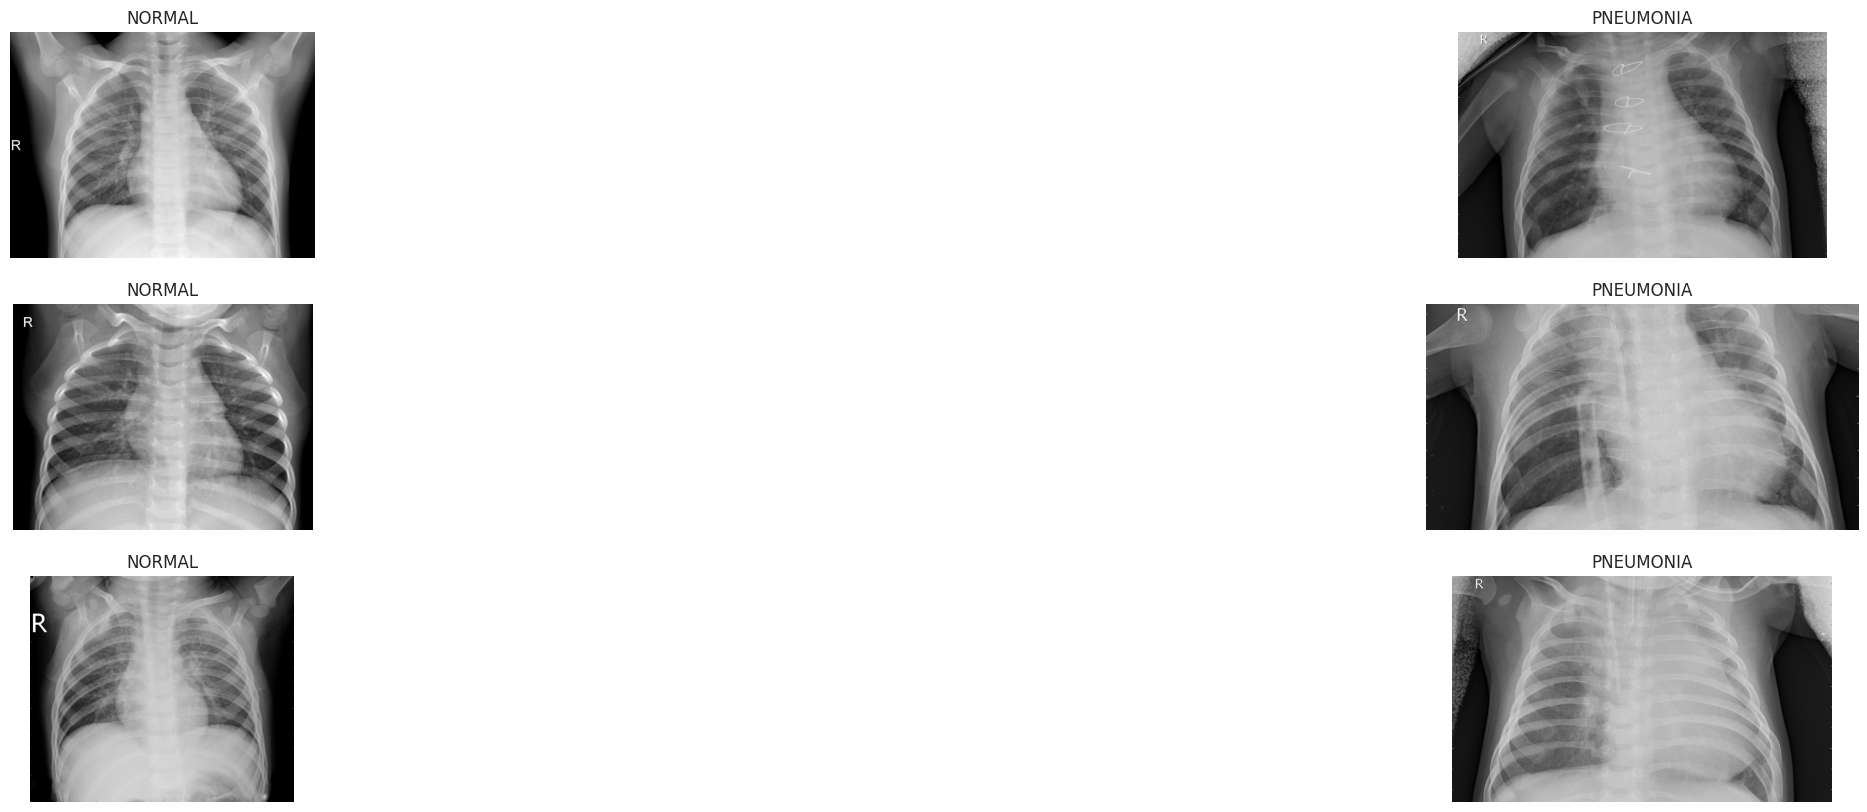

Размер класса NORMAL составляет 1341
Размер класса PNEUMONIA составляет 3875

Общий размер базы для обучения: 5216


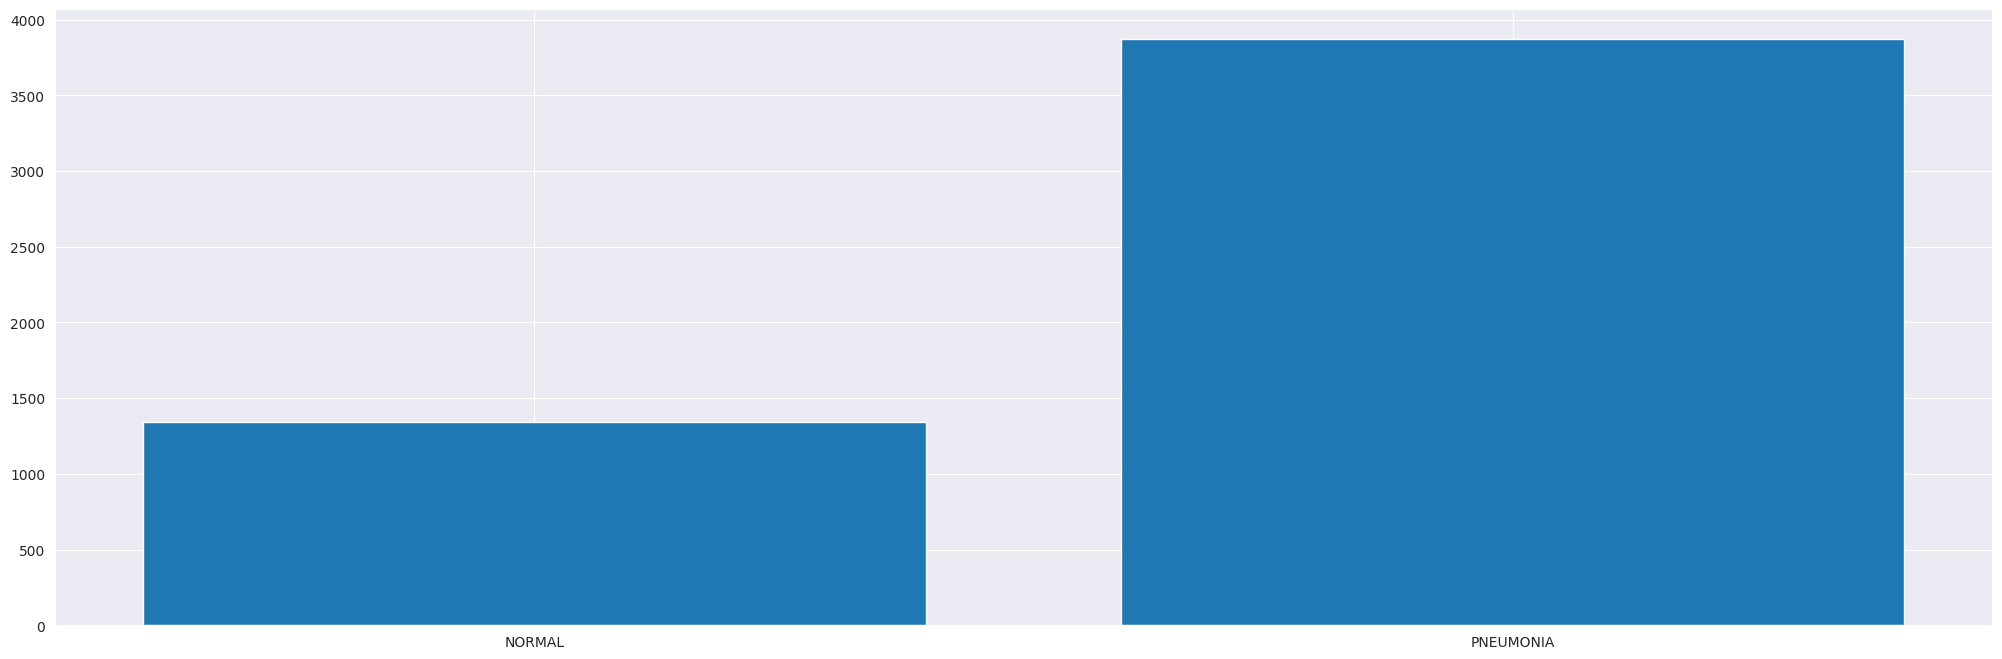

In [ ]:
#@title <h1><b>---- RUN WORKERS --- <h1><b>
# Загрузка датасета
worker.load_dataset()
#
# Показ примеров
worker.show_samples()
#
# Информация о датасете
worker.dataset_info()
#

<h1><b>---- Эксперименты (свои модели) ----</h1><b>

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                      

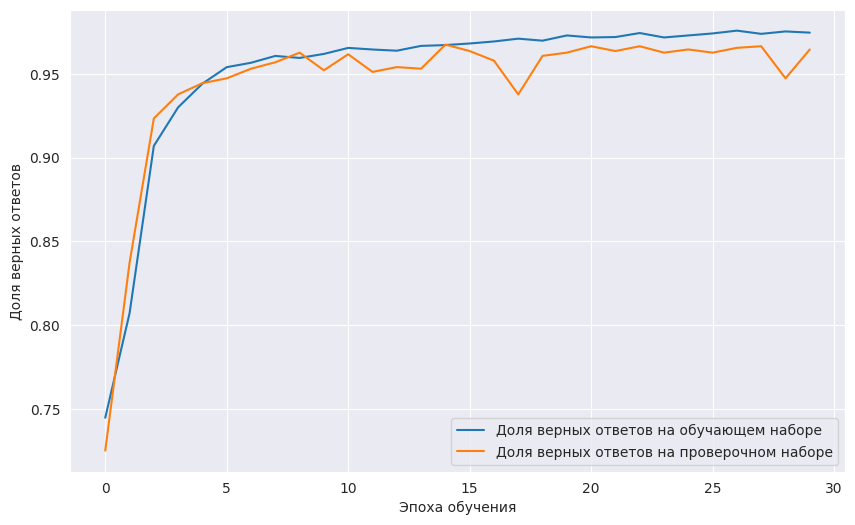

Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.967

Матрица ошибок для обучающей выборки:


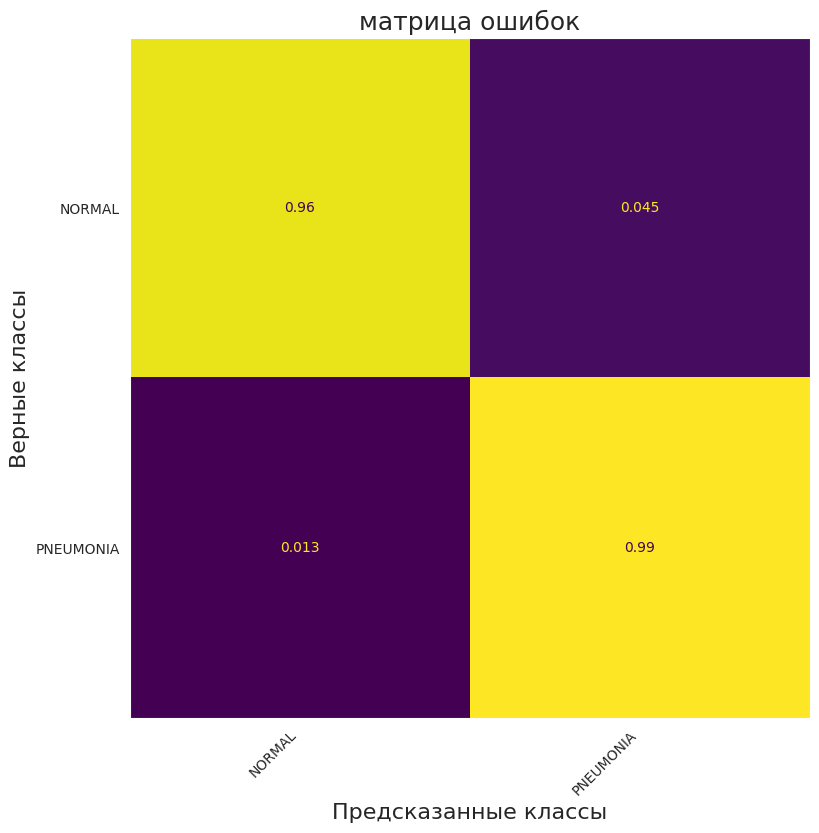


Матрица ошибок для проверочной выборки:


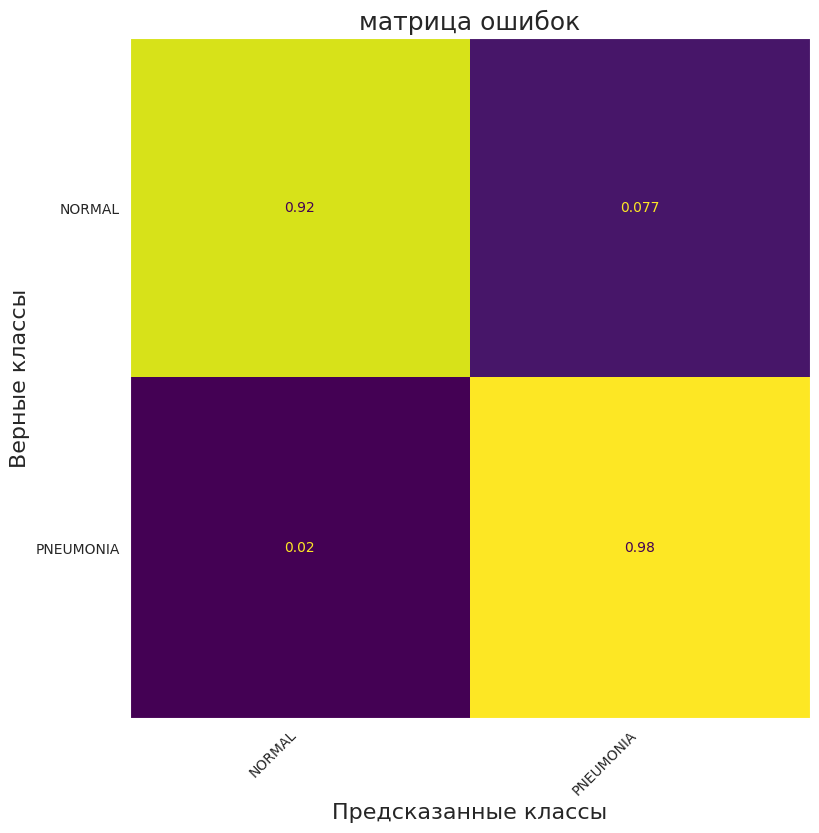

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.981
Максимальная точность на проверочной выборке: 0.975


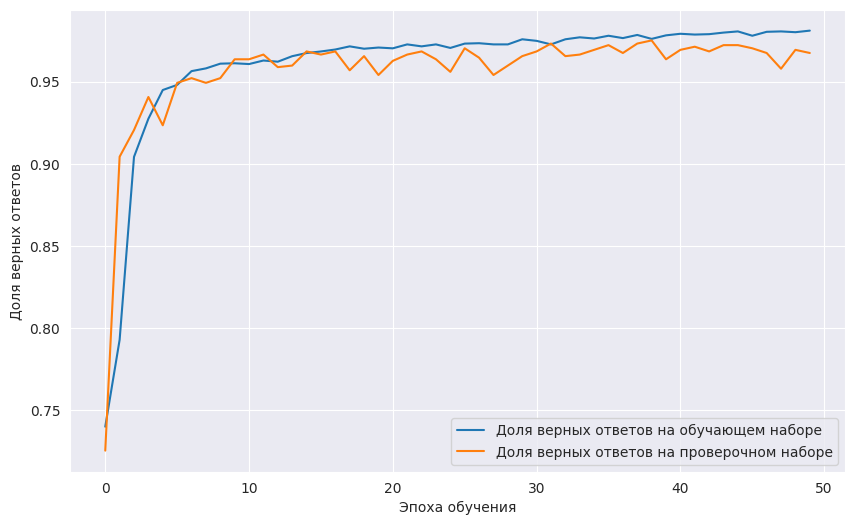





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.981
Максимальная точность на проверочной выборке: 0.973


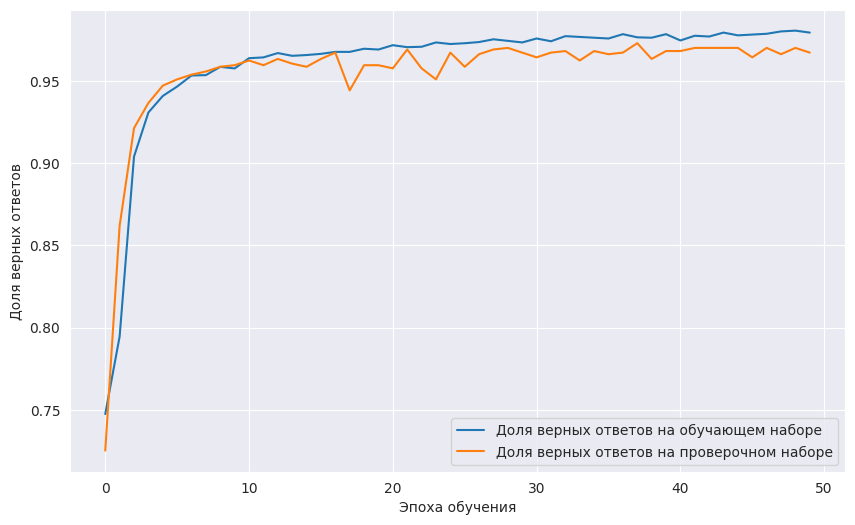





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.98
Максимальная точность на проверочной выборке: 0.97


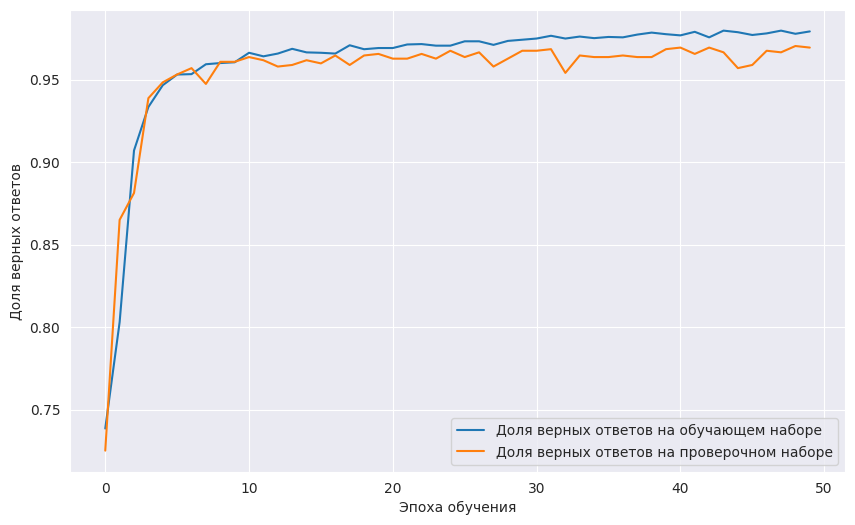





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.979
Максимальная точность на проверочной выборке: 0.971


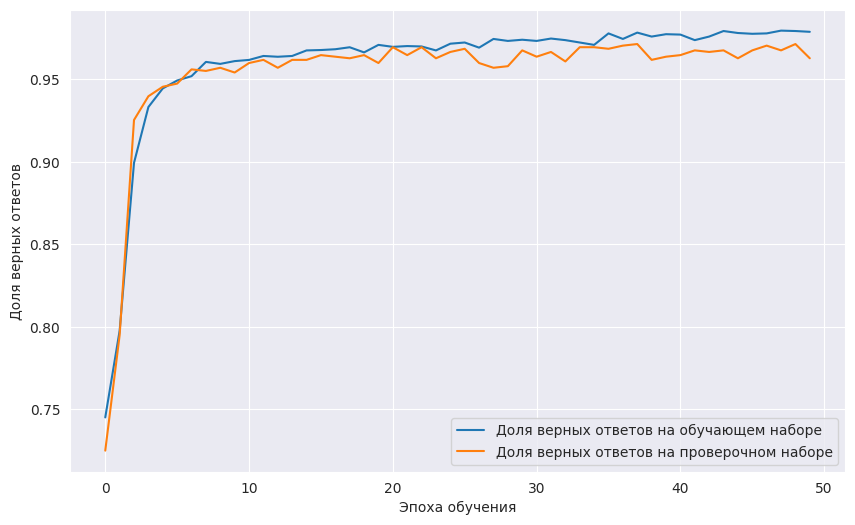





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.983
Максимальная точность на проверочной выборке: 0.972


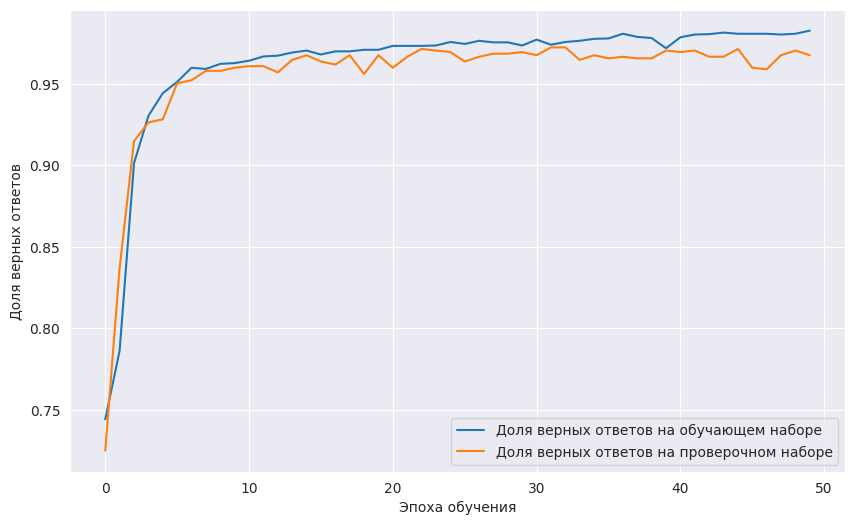





Средняя точность на обучающей выборке: 0.981
Максимальная точность на обучающей выборке: 0.983
Средняя точность на проверочной выборке: 0.972
Максимальная точность на проверочной выборке: 0.975


In [ ]:
#@title ### Эксп. №1 (97.4%, 97.4%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model, False)
#
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               16777344  
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 16787041 (64.04 MB)
Trainable params: 16787041 (64.04 MB)
Non-trainable params: 0 (0.00 

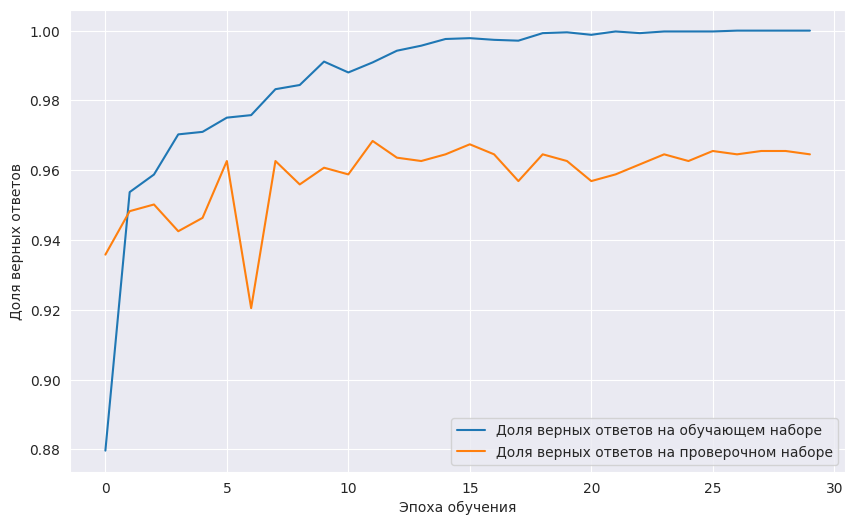

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.968

Матрица ошибок для обучающей выборки:


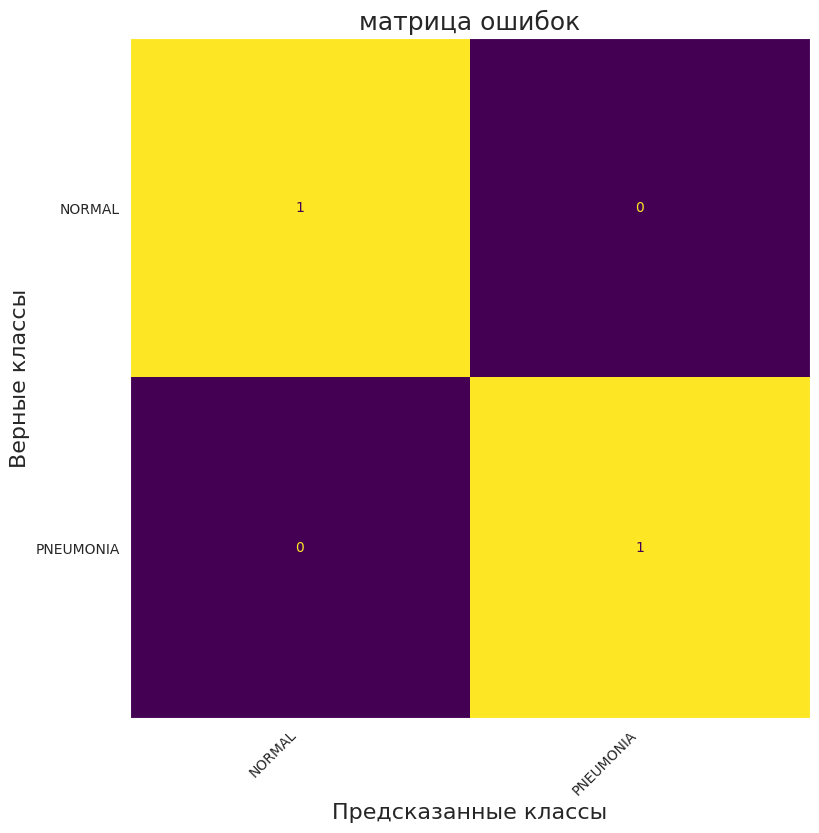


Матрица ошибок для проверочной выборки:


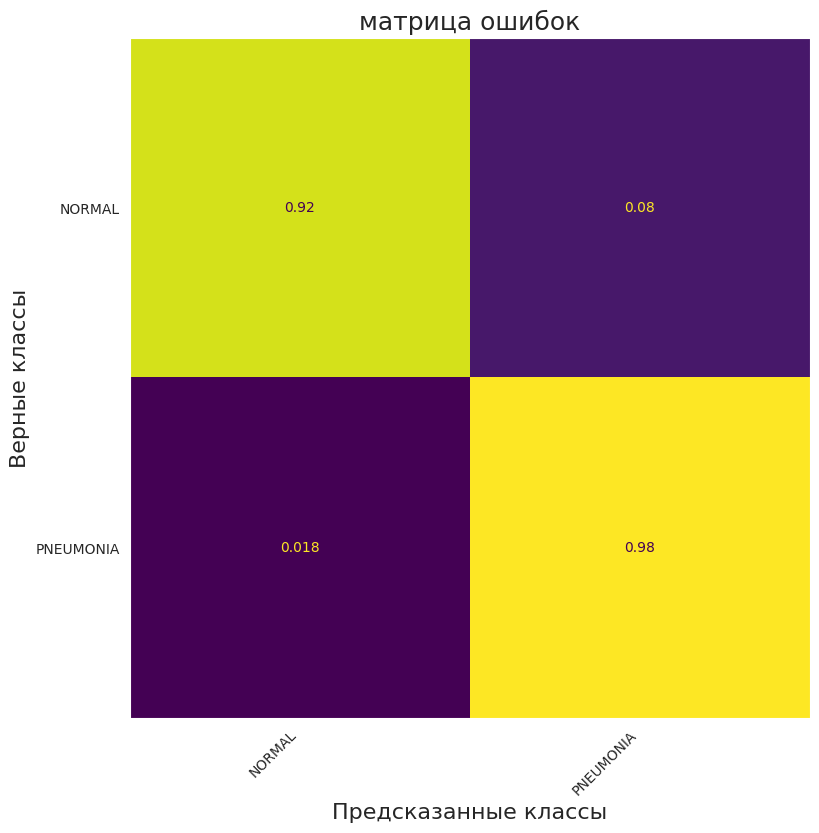

In [ ]:
#@title ### Эксп. №2 (убран макс-пуллинг) (96.6% 96.6%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  #model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  #model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.974


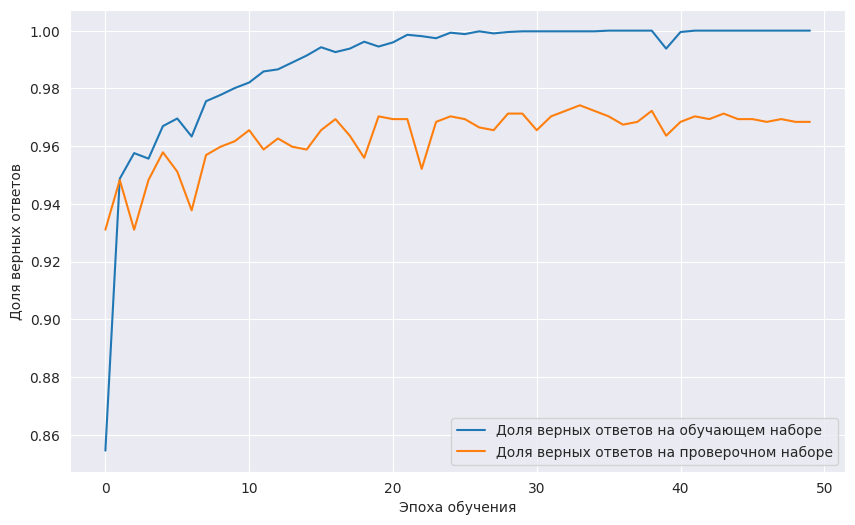





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.969


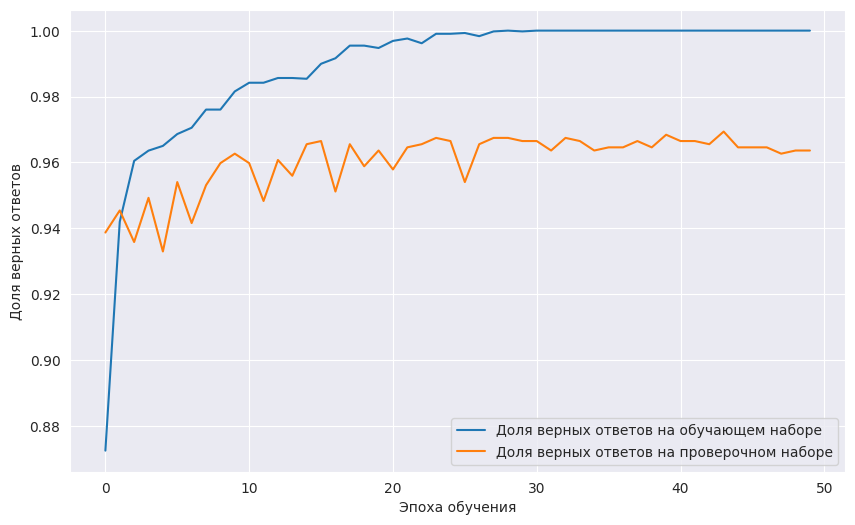





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.969


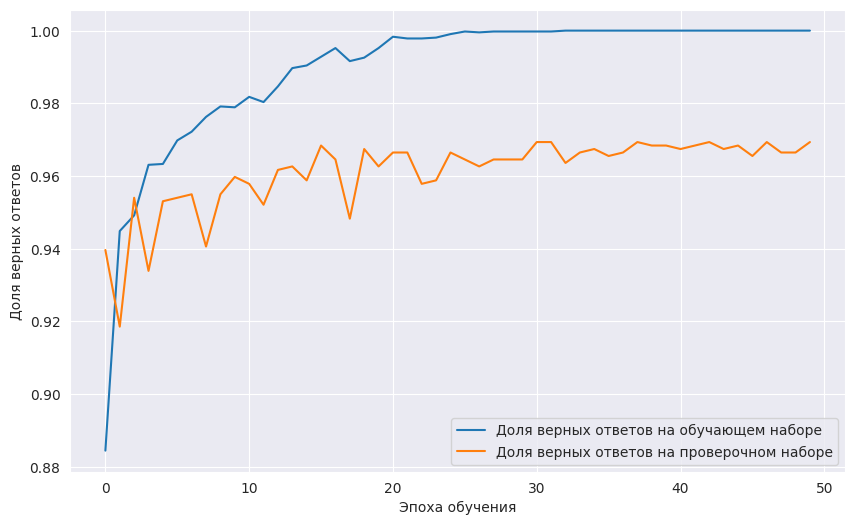





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.967


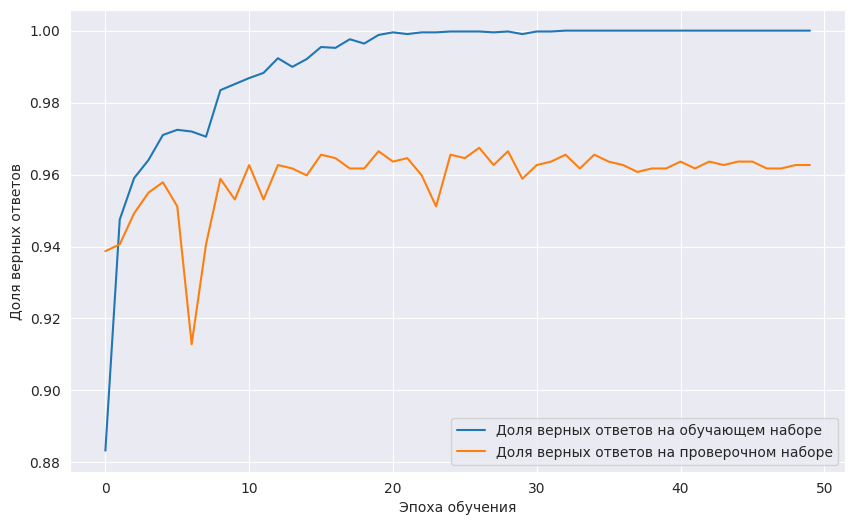





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.968


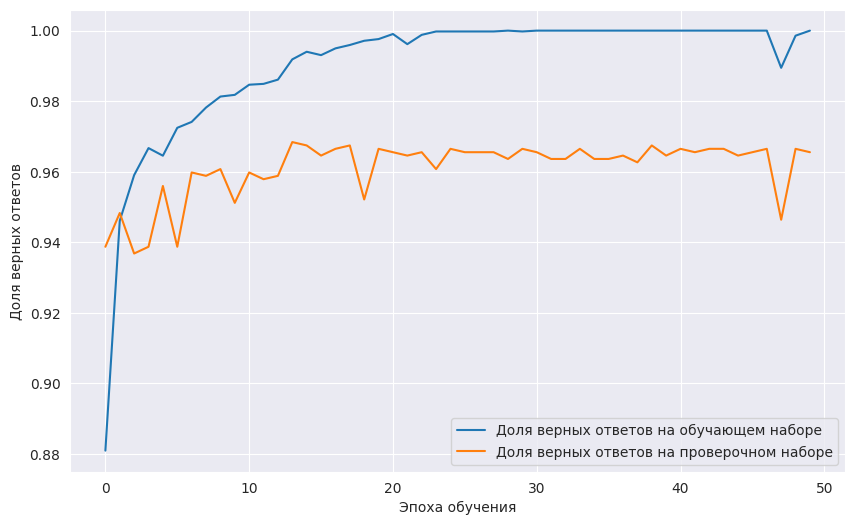





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.97
Максимальная точность на проверочной выборке: 0.974


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 1568)              0         
                                   

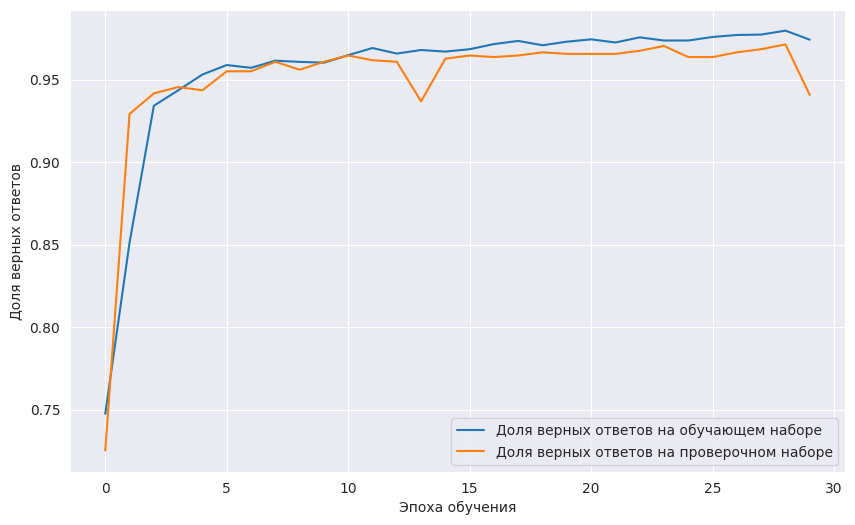

Максимальная точность на обучающей выборке: 0.98
Максимальная точность на проверочной выборке: 0.971

Матрица ошибок для обучающей выборки:


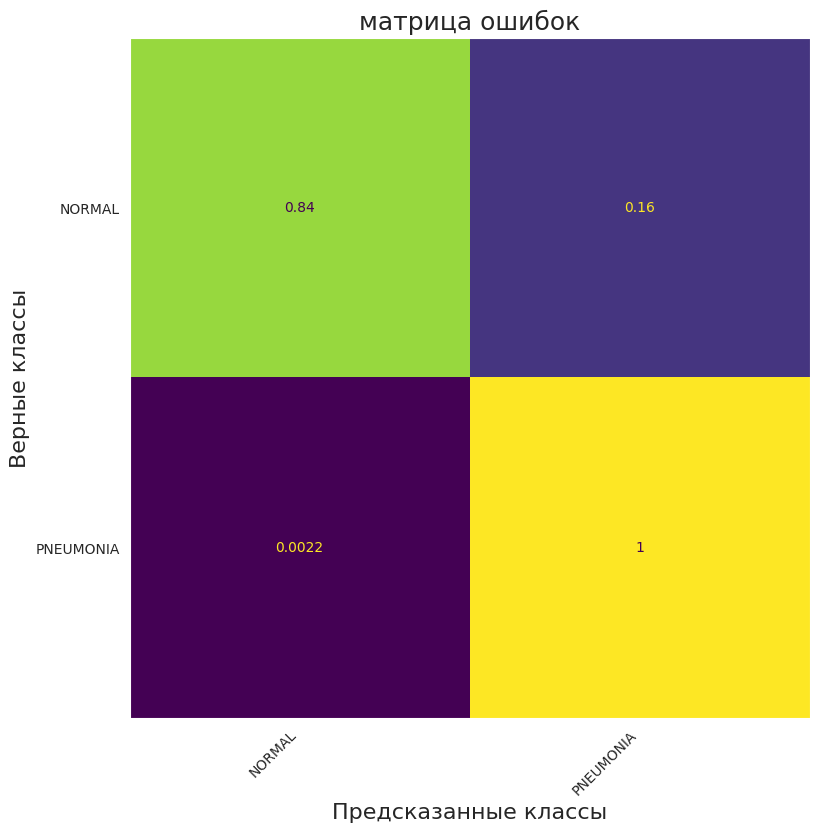


Матрица ошибок для проверочной выборки:


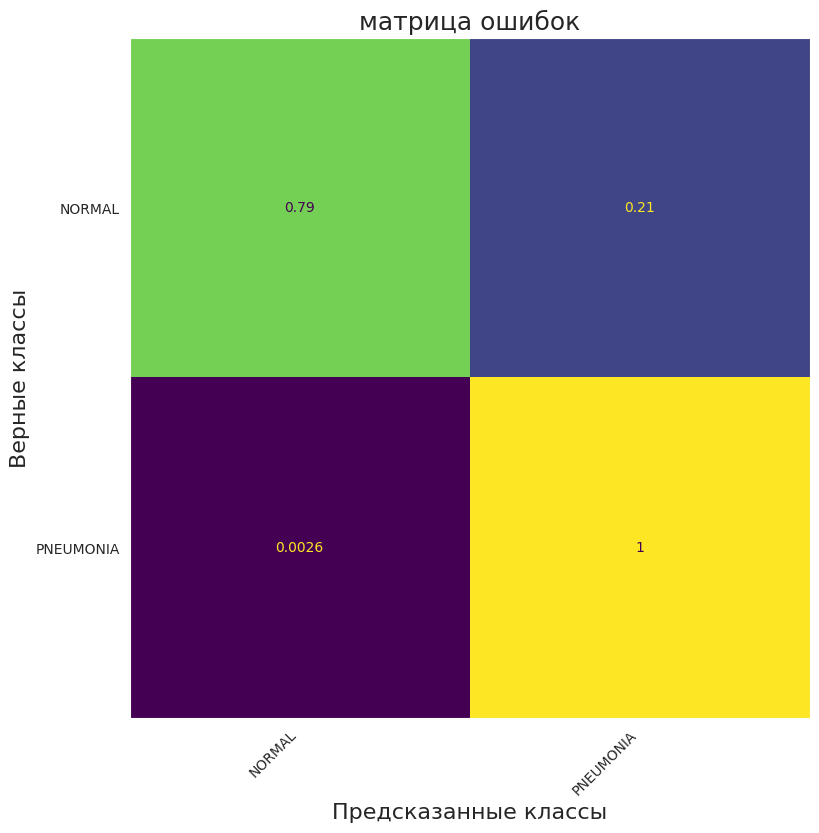

In [ ]:
#@title ### Эксп. №3 (добавлен полносвязный слой в конце) (97.5% 97.6%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.991
Максимальная точность на проверочной выборке: 0.973


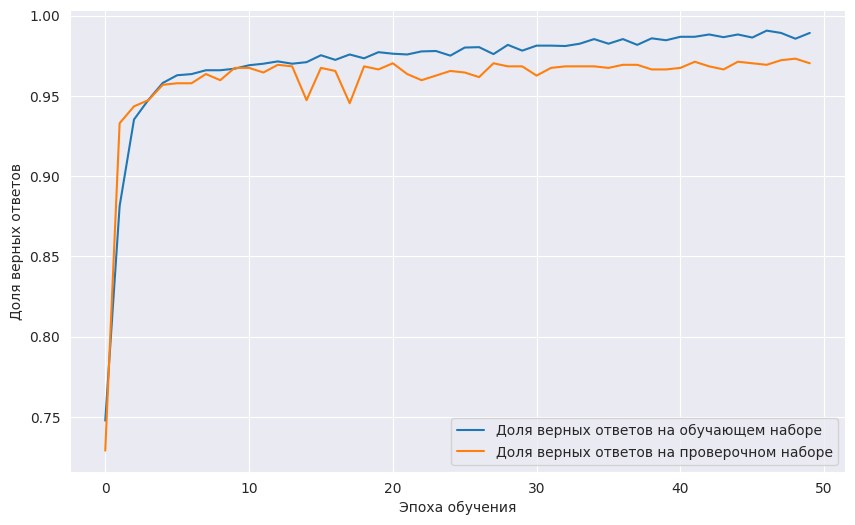





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.99
Максимальная точность на проверочной выборке: 0.979


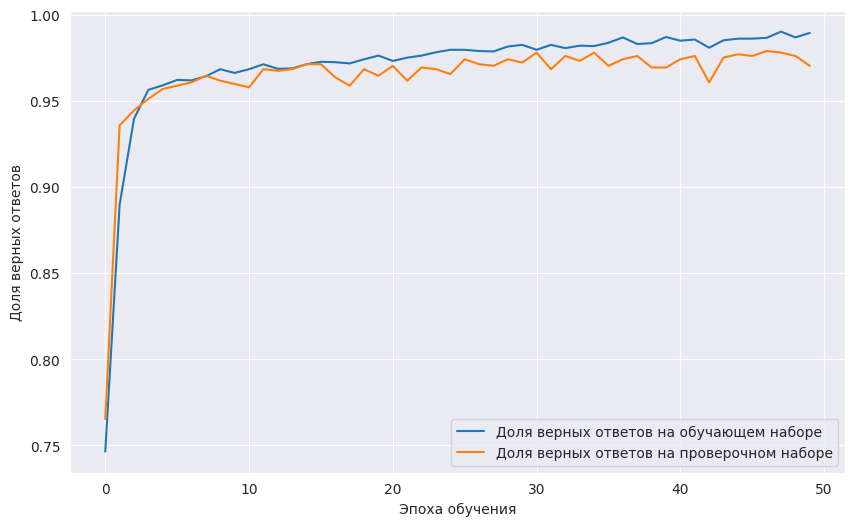





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.986
Максимальная точность на проверочной выборке: 0.971


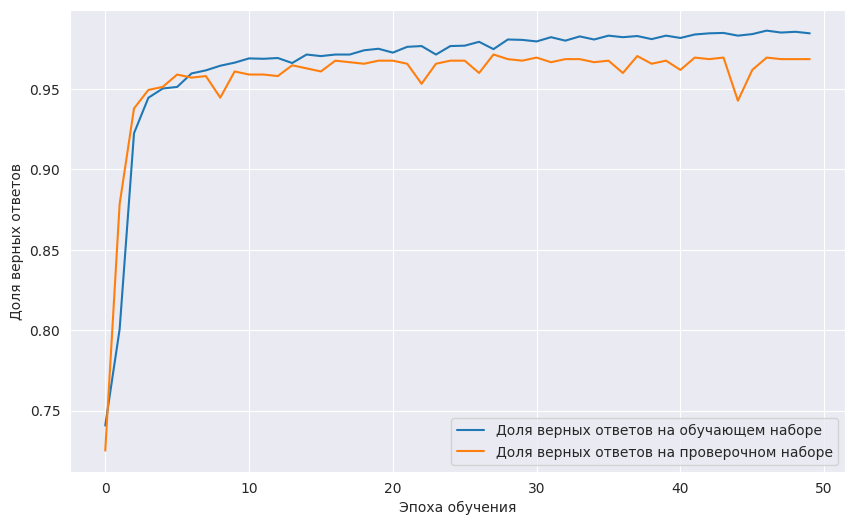





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.991
Максимальная точность на проверочной выборке: 0.971


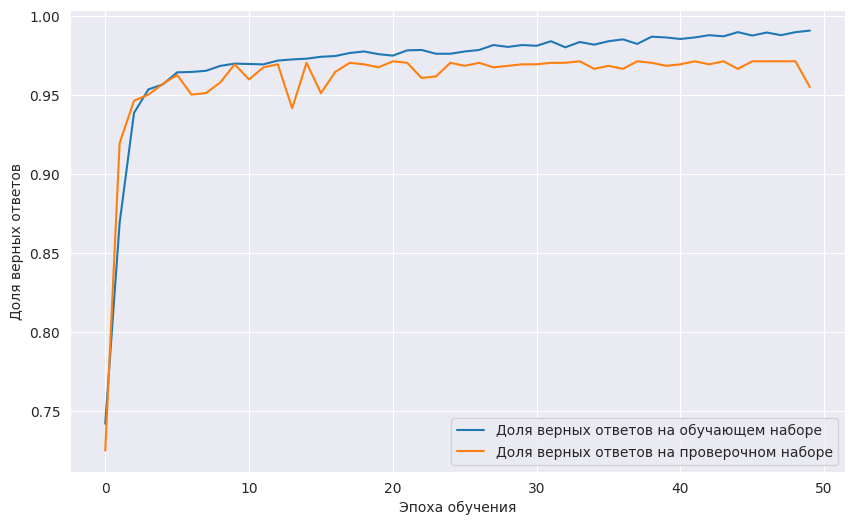





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.988
Максимальная точность на проверочной выборке: 0.969


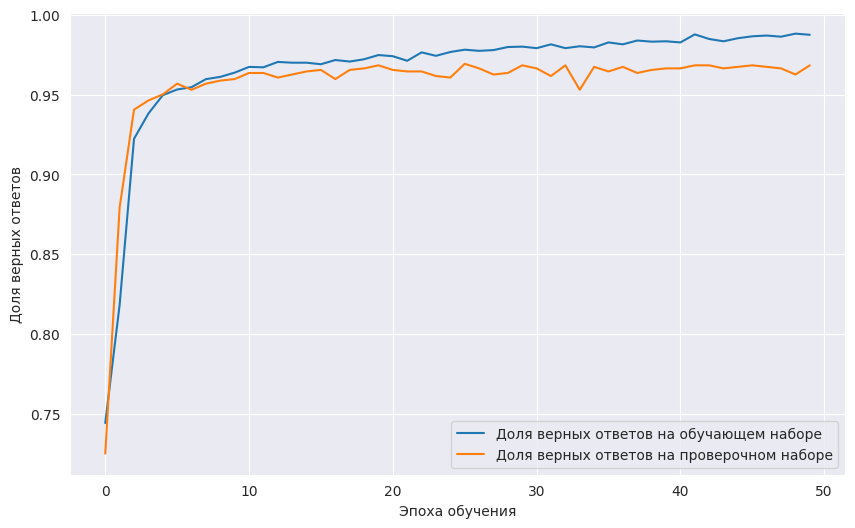





Средняя точность на обучающей выборке: 0.989
Максимальная точность на обучающей выборке: 0.991
Средняя точность на проверочной выборке: 0.973
Максимальная точность на проверочной выборке: 0.979


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 1568)              0         
                                   

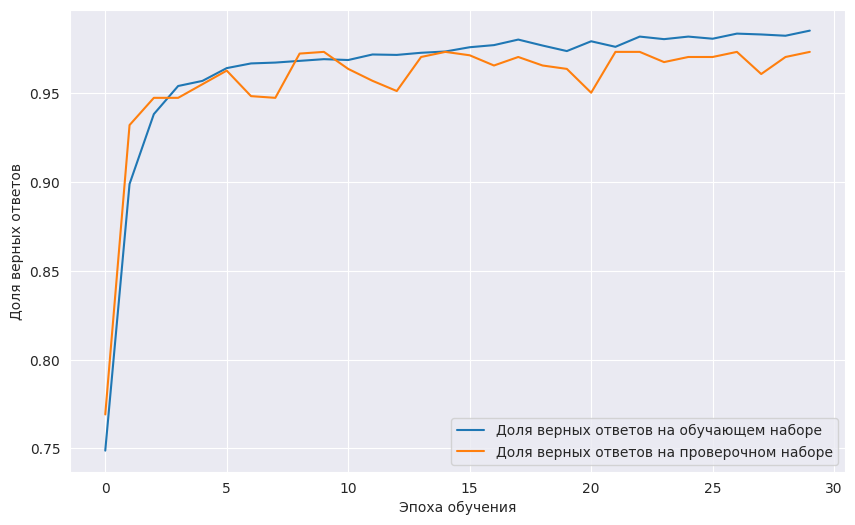

Максимальная точность на обучающей выборке: 0.985
Максимальная точность на проверочной выборке: 0.973

Матрица ошибок для обучающей выборки:


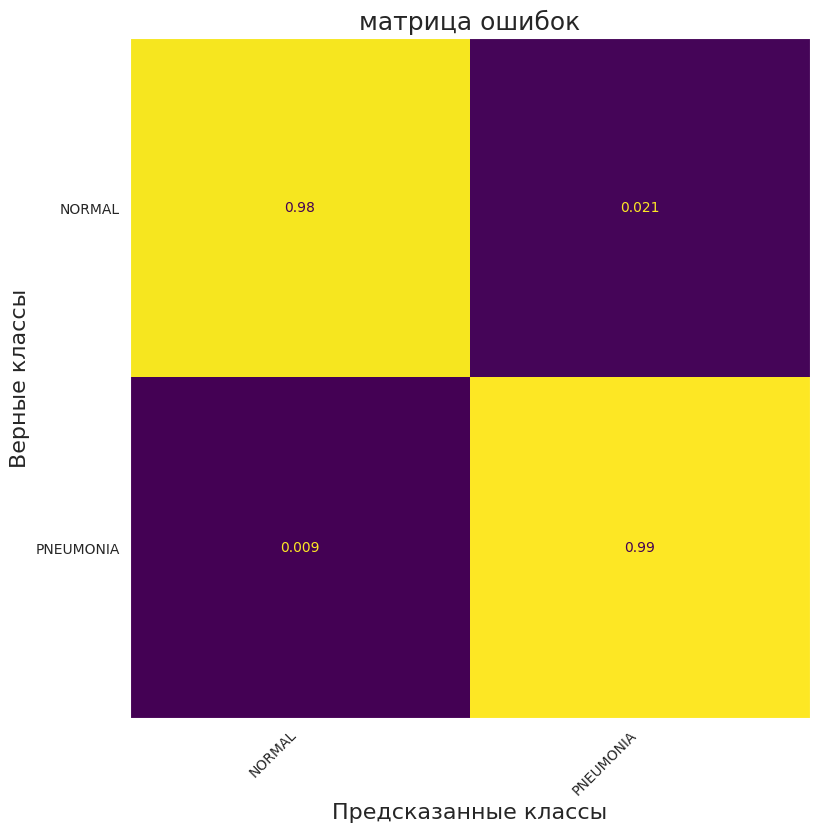


Матрица ошибок для проверочной выборки:


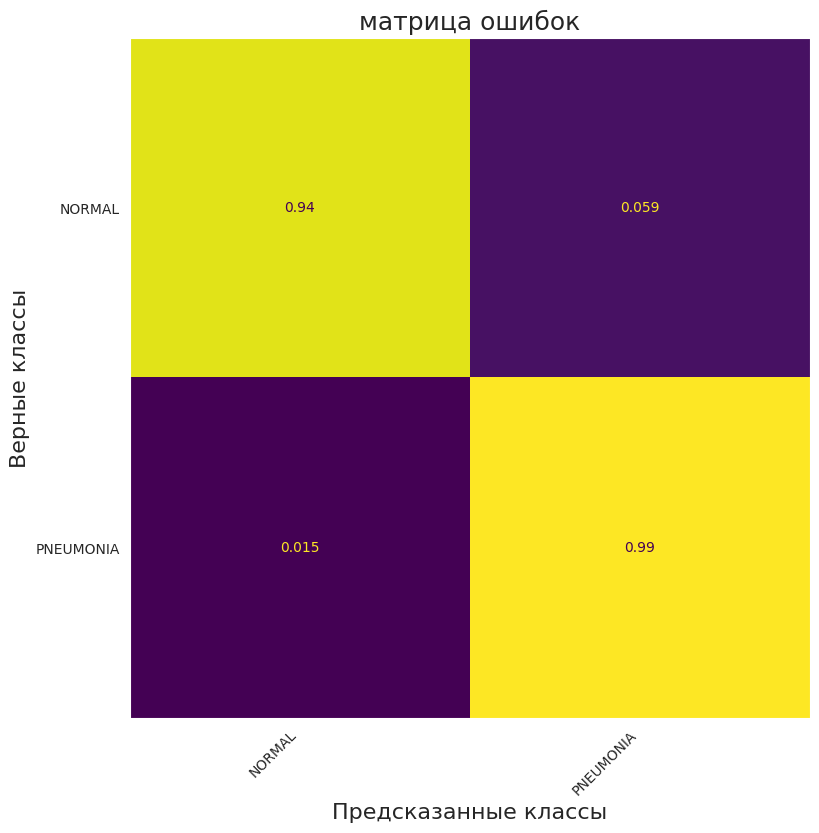

In [ ]:
#@title ### Эксп. №4 (усилен полносвязный слой в конце) (97.5% 97.6%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.993
Максимальная точность на проверочной выборке: 0.975


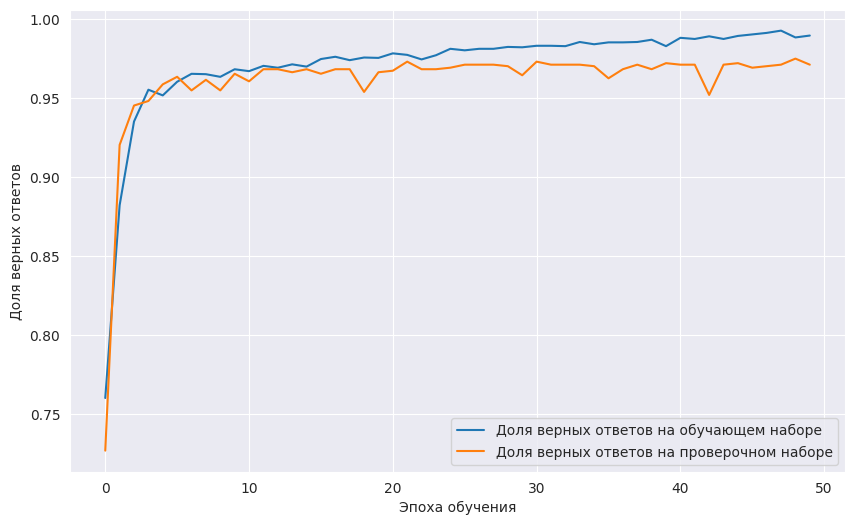





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.992
Максимальная точность на проверочной выборке: 0.971


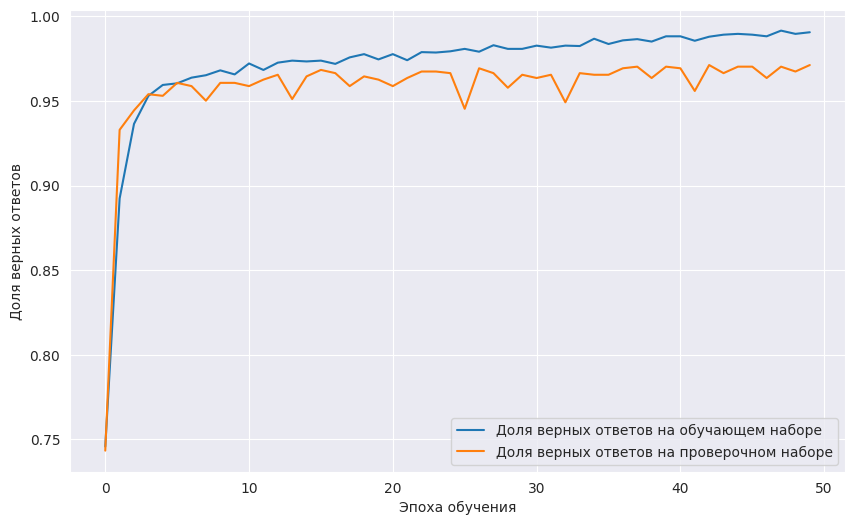





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.994
Максимальная точность на проверочной выборке: 0.975


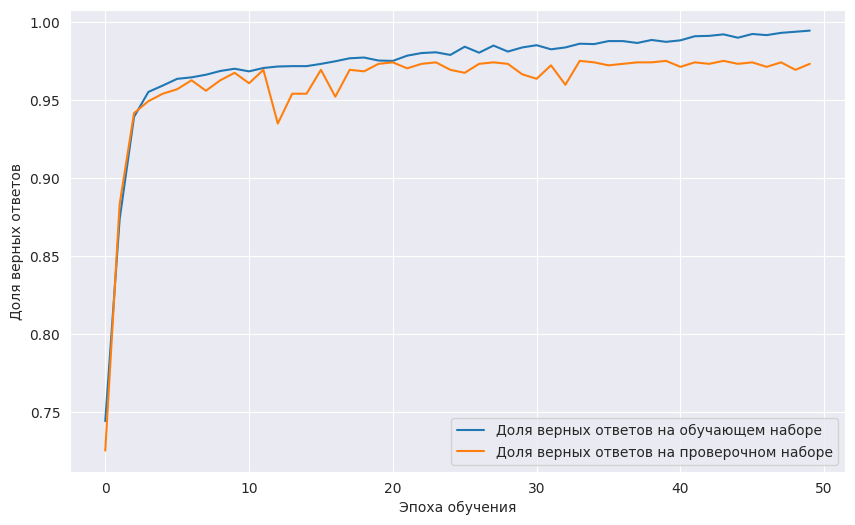





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.989
Максимальная точность на проверочной выборке: 0.972


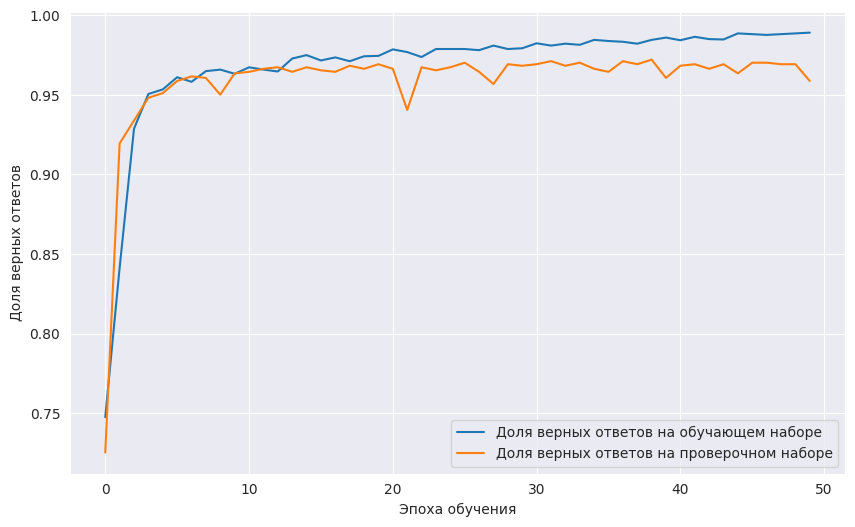





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.995
Максимальная точность на проверочной выборке: 0.973


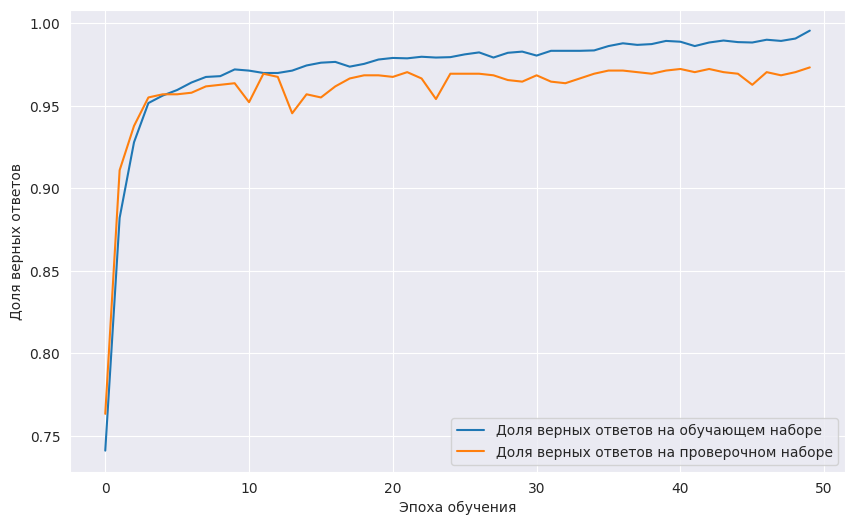





Средняя точность на обучающей выборке: 0.993
Максимальная точность на обучающей выборке: 0.995
Средняя точность на проверочной выборке: 0.973
Максимальная точность на проверочной выборке: 0.975


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 1568)              0         
                                   

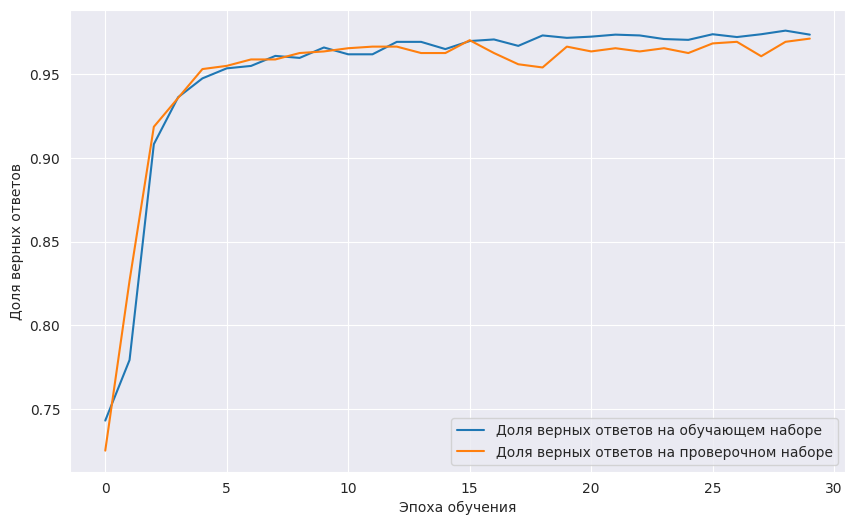

Максимальная точность на обучающей выборке: 0.976
Максимальная точность на проверочной выборке: 0.971

Матрица ошибок для обучающей выборки:


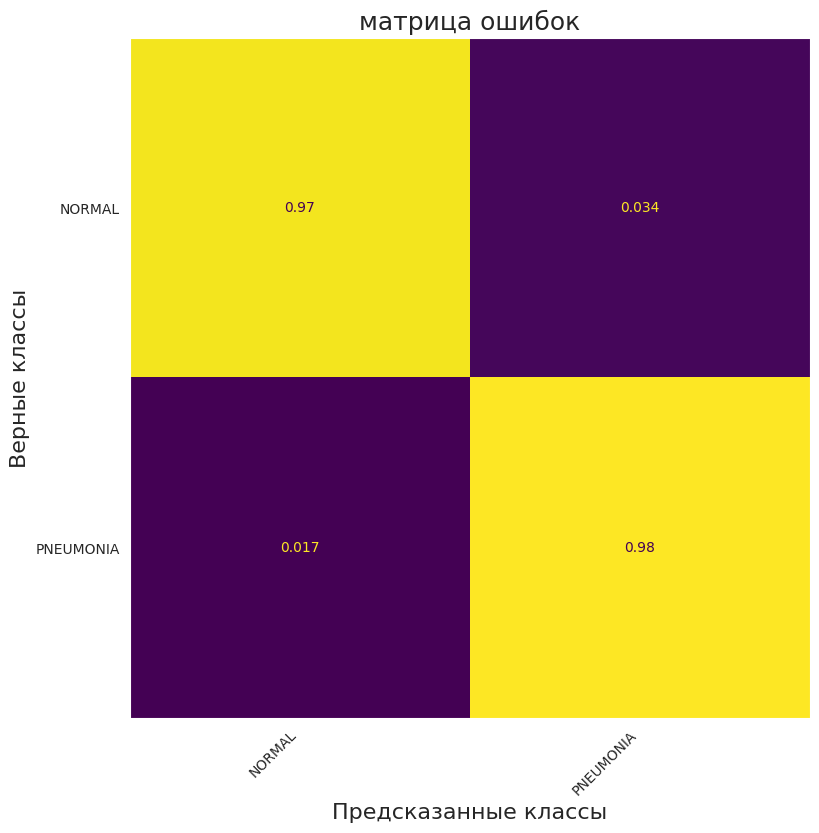


Матрица ошибок для проверочной выборки:


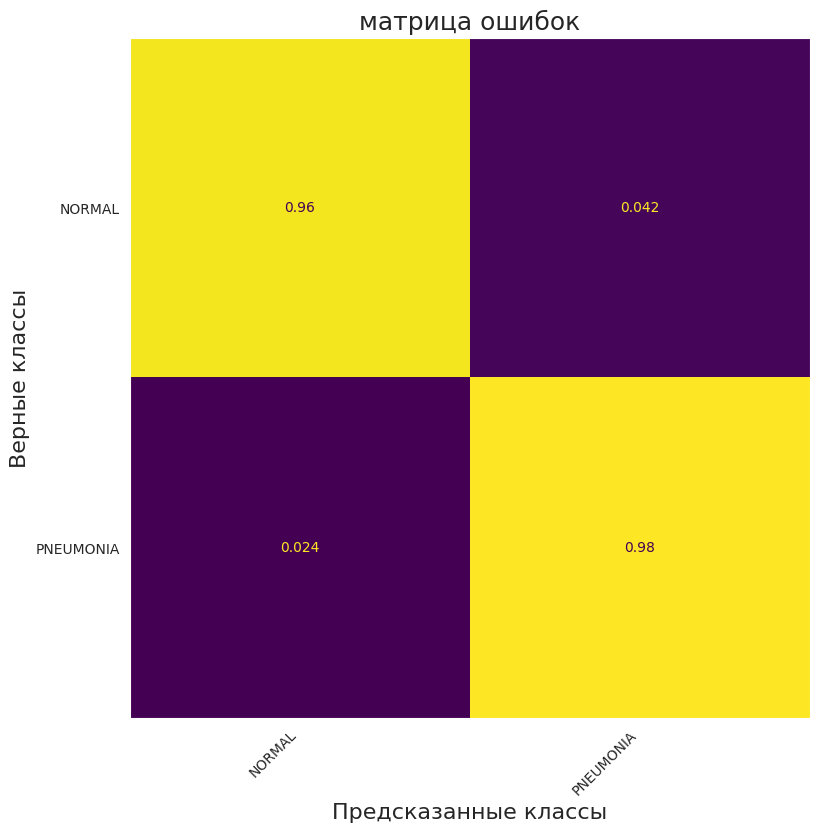

In [ ]:
#@title ### Эксп. №5 (ослабили полносвязный в конце) (97.5% 97.7%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.984
Максимальная точность на проверочной выборке: 0.97


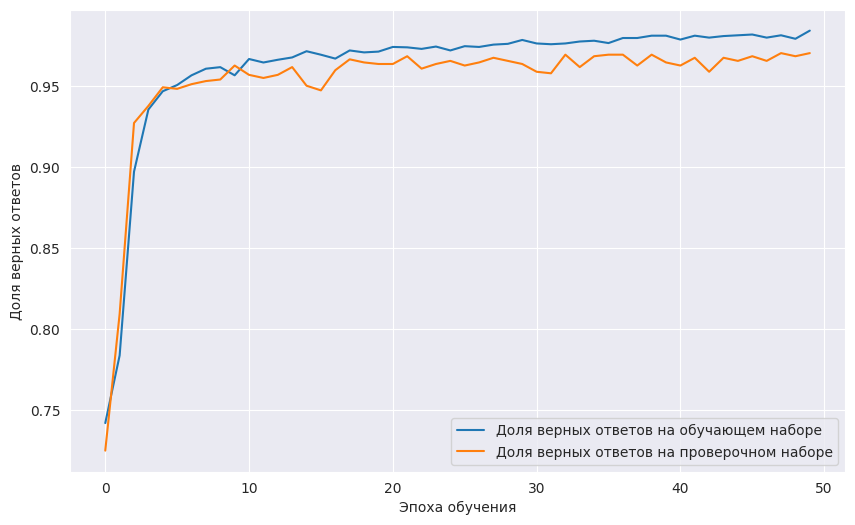





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.983
Максимальная точность на проверочной выборке: 0.971


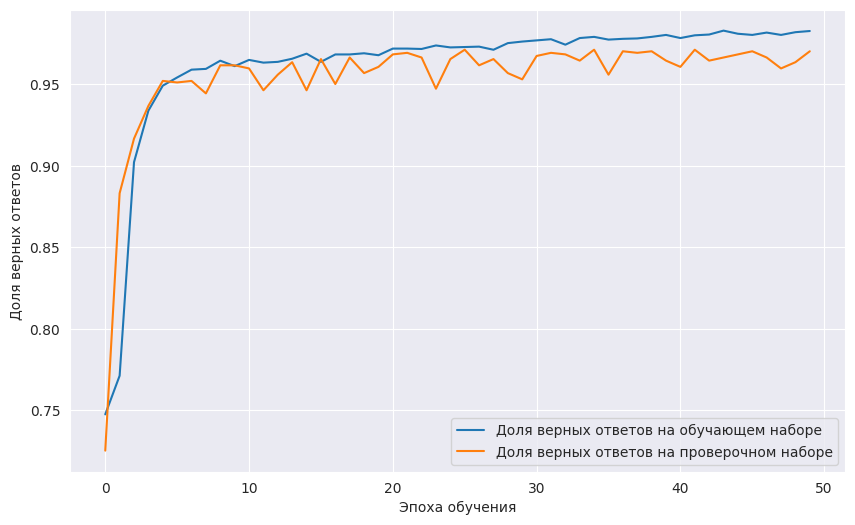





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.985
Максимальная точность на проверочной выборке: 0.971


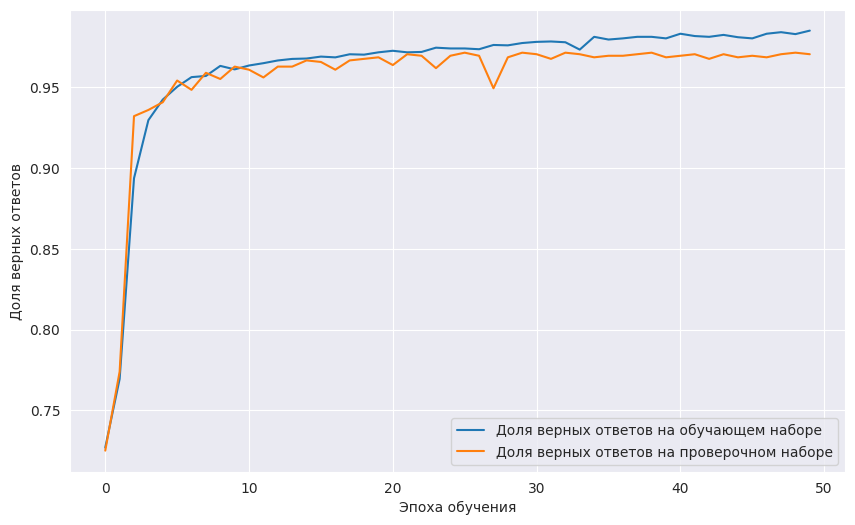





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.982
Максимальная точность на проверочной выборке: 0.972


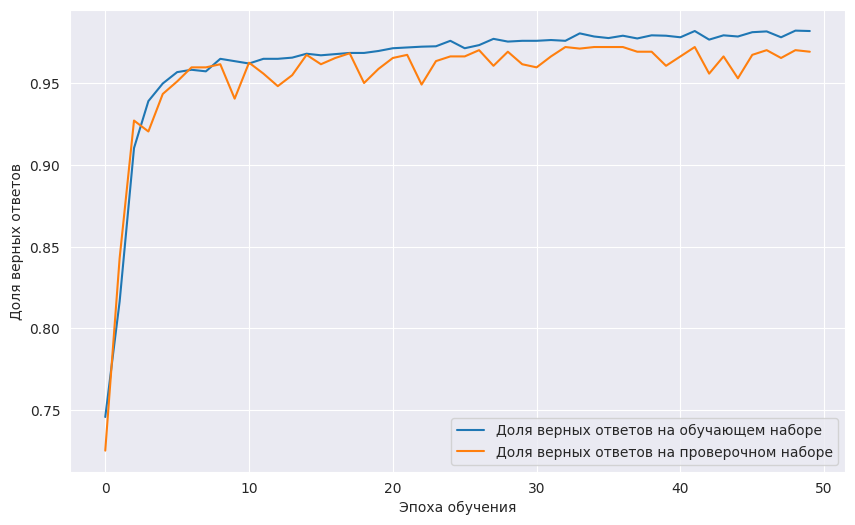





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.983
Максимальная точность на проверочной выборке: 0.973


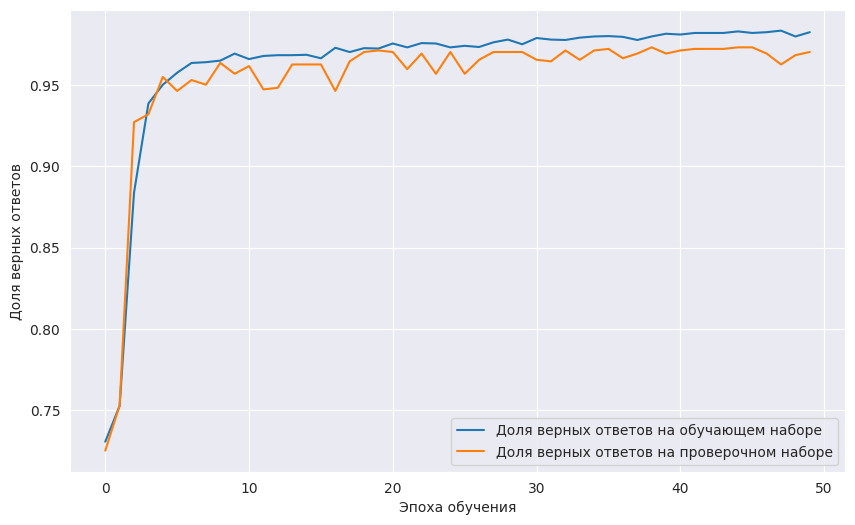





Средняя точность на обучающей выборке: 0.984
Максимальная точность на обучающей выборке: 0.985
Средняя точность на проверочной выборке: 0.972
Максимальная точность на проверочной выборке: 0.973


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 64, 64, 12)        120       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 21, 21, 12)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 21, 21, 32)        3488      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_30 (Flatten)        (None, 1568)              0         
                                   

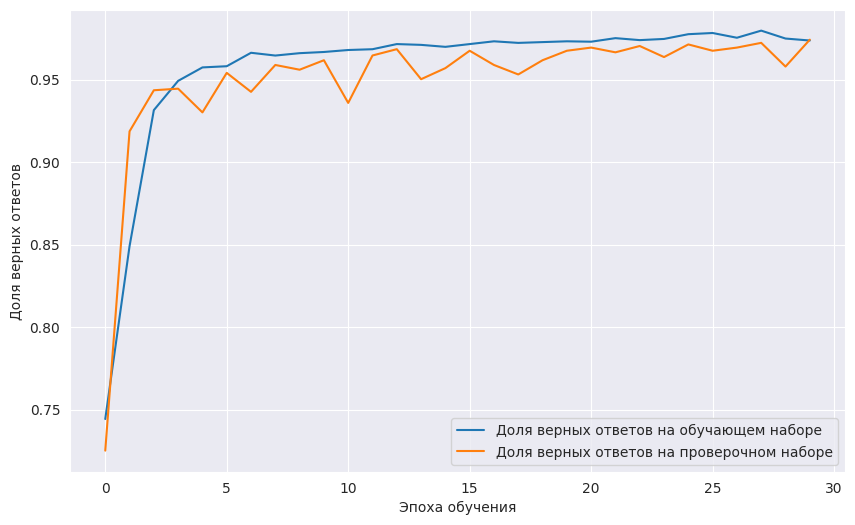

Максимальная точность на обучающей выборке: 0.98
Максимальная точность на проверочной выборке: 0.974

Матрица ошибок для обучающей выборки:


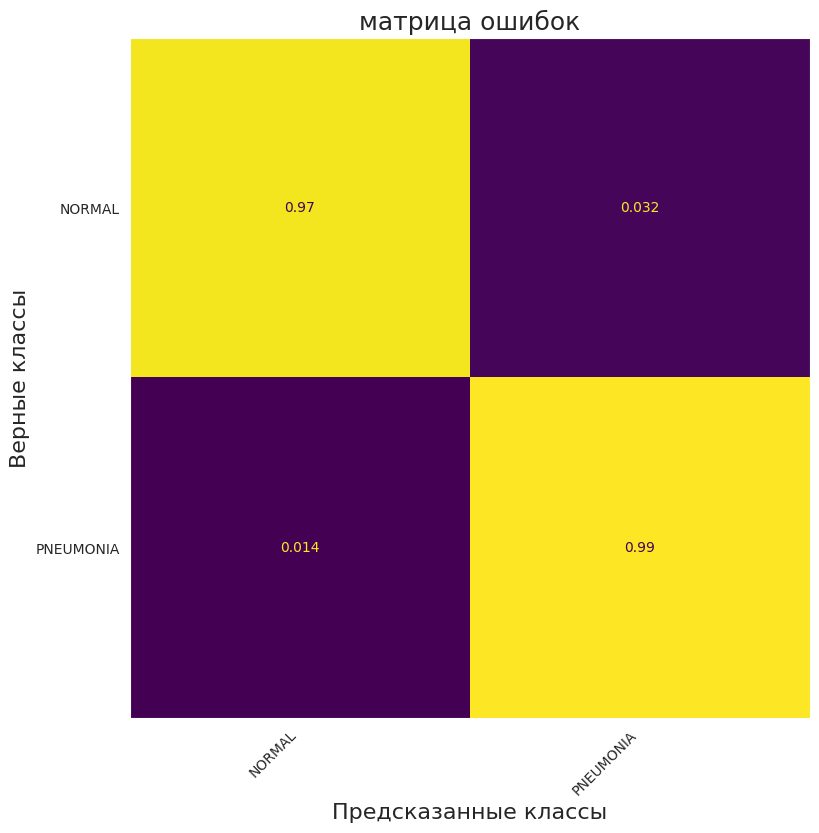


Матрица ошибок для проверочной выборки:


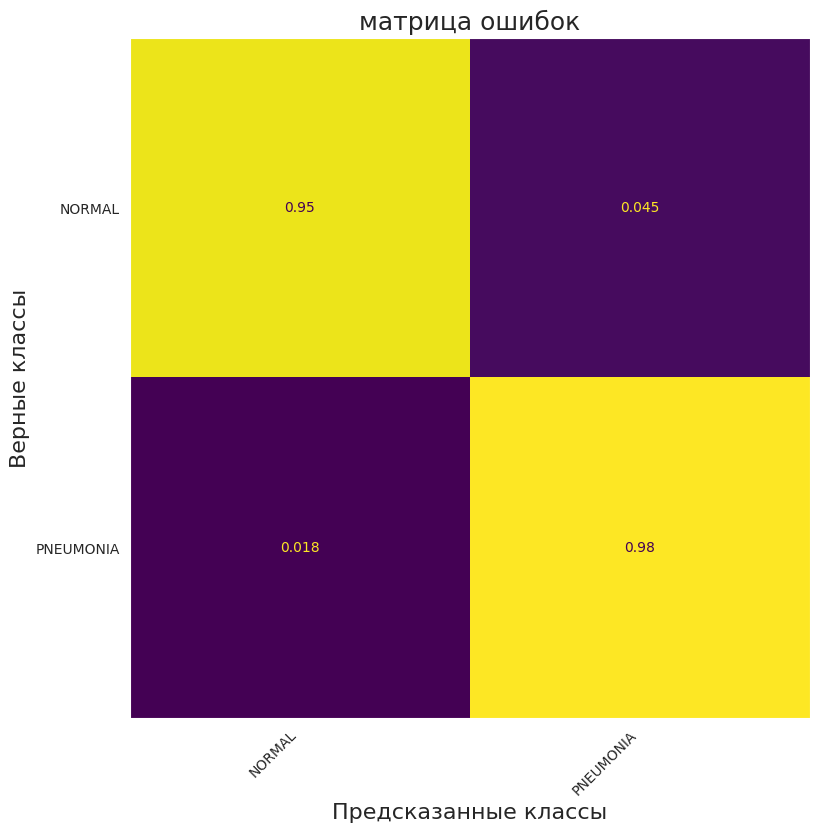

In [ ]:
#@title ### Эксп. №6 (ослабили первый сверточный) (97.4% 97.7%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(12, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.983
Максимальная точность на проверочной выборке: 0.971


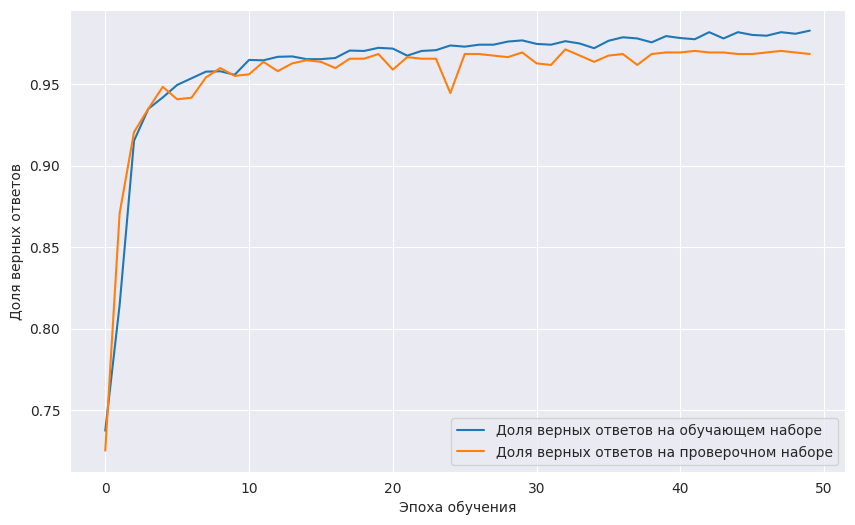





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.986
Максимальная точность на проверочной выборке: 0.975


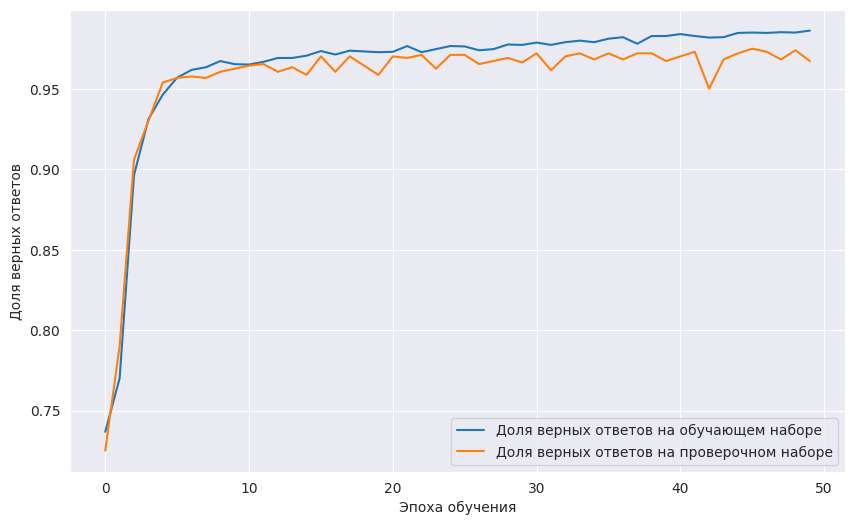





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.984
Максимальная точность на проверочной выборке: 0.974


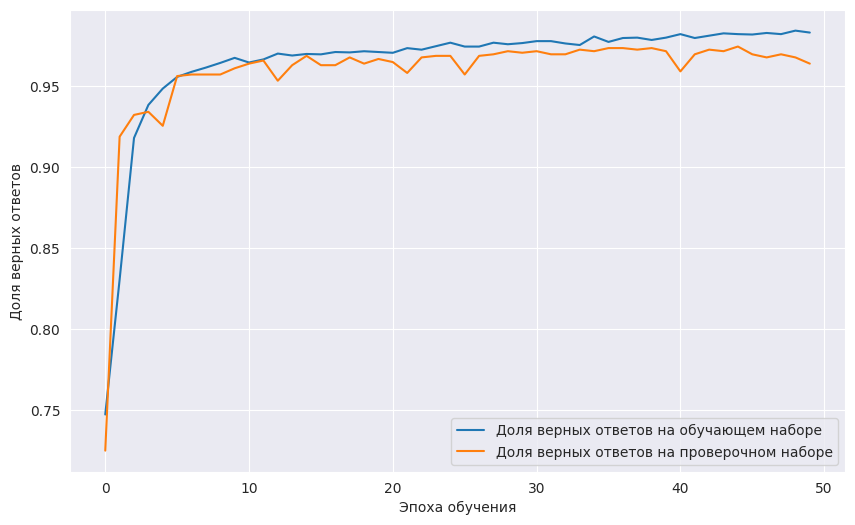





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.987
Максимальная точность на проверочной выборке: 0.973


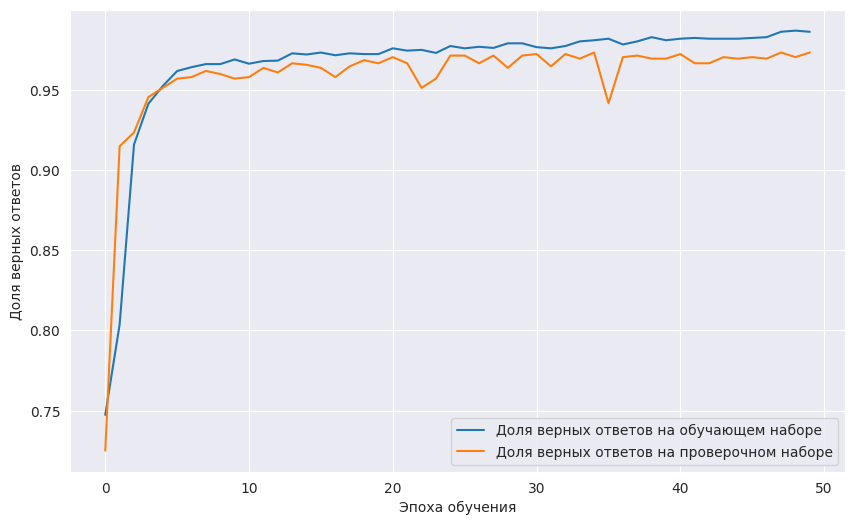





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.989
Максимальная точность на проверочной выборке: 0.974


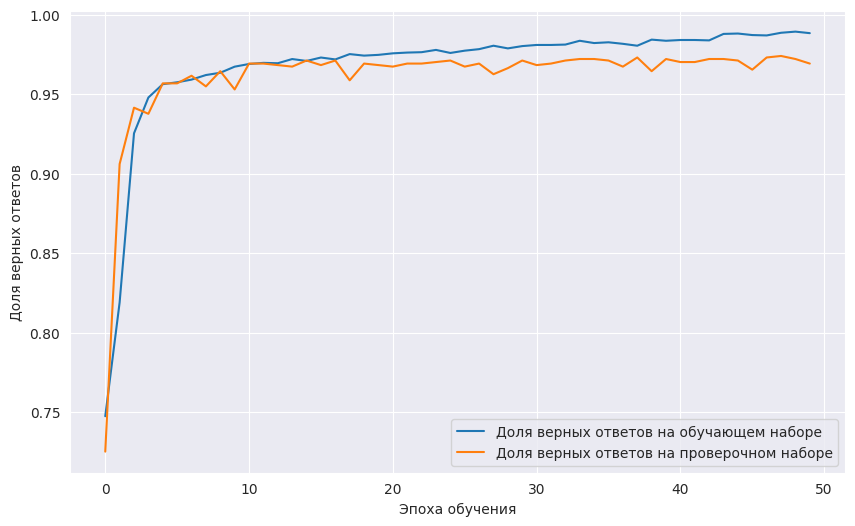





Средняя точность на обучающей выборке: 0.986
Максимальная точность на обучающей выборке: 0.989
Средняя точность на проверочной выборке: 0.974
Максимальная точность на проверочной выборке: 0.975


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 64, 64, 128)       1280      
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (None, 21, 21, 32)        36896     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_36 (Flatten)        (None, 1568)              0         
                                   

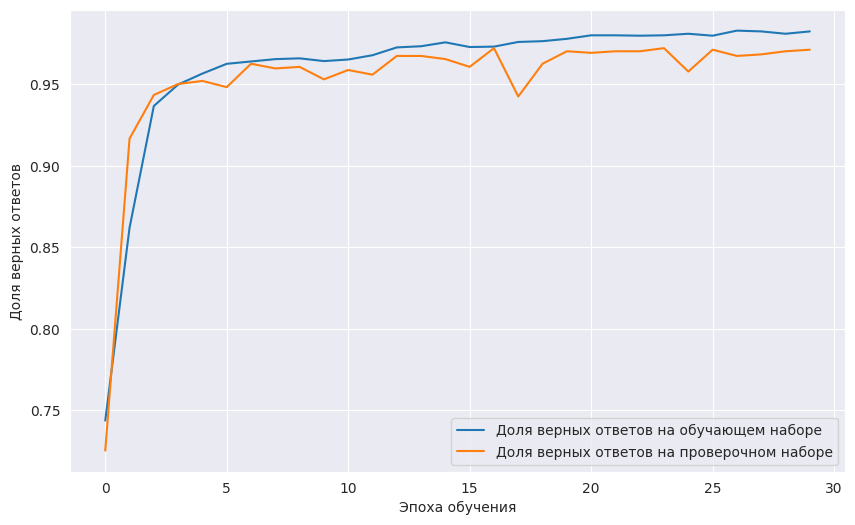

Максимальная точность на обучающей выборке: 0.983
Максимальная точность на проверочной выборке: 0.972

Матрица ошибок для обучающей выборки:


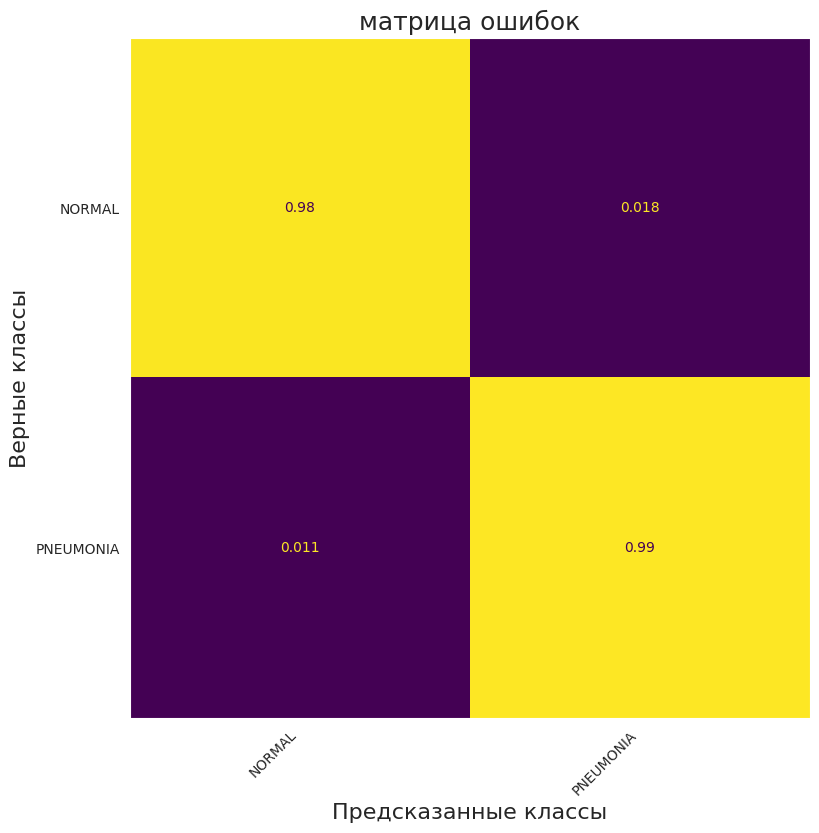


Матрица ошибок для проверочной выборки:


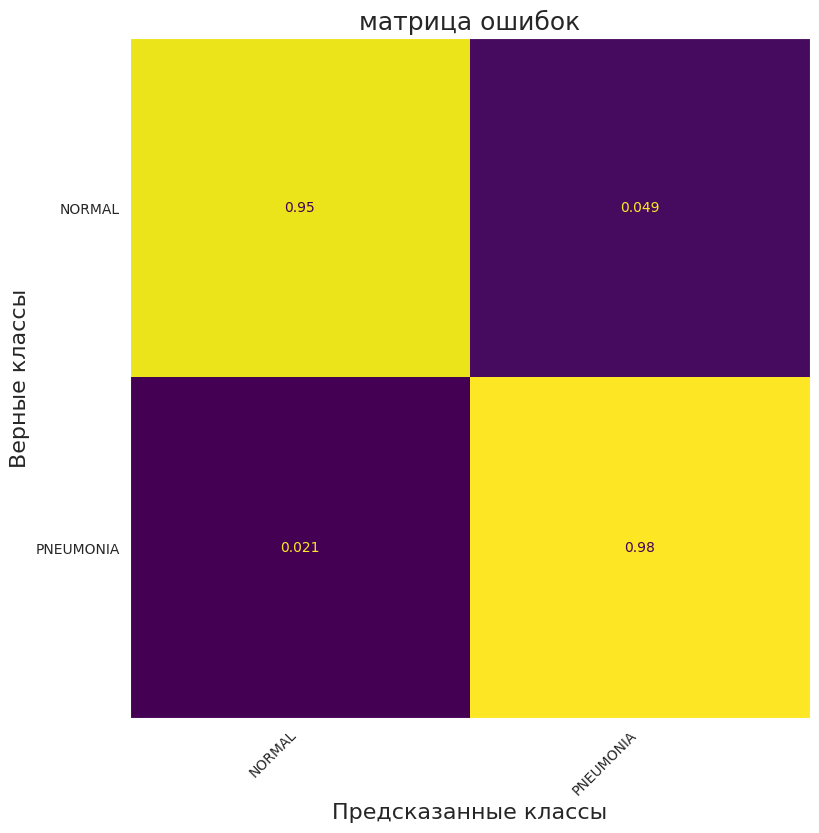

In [ ]:
#@title ### Эксп. №7 (усилили первый сверточный) (97.4% 97.7%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 0.995
Максимальная точность на проверочной выборке: 0.974


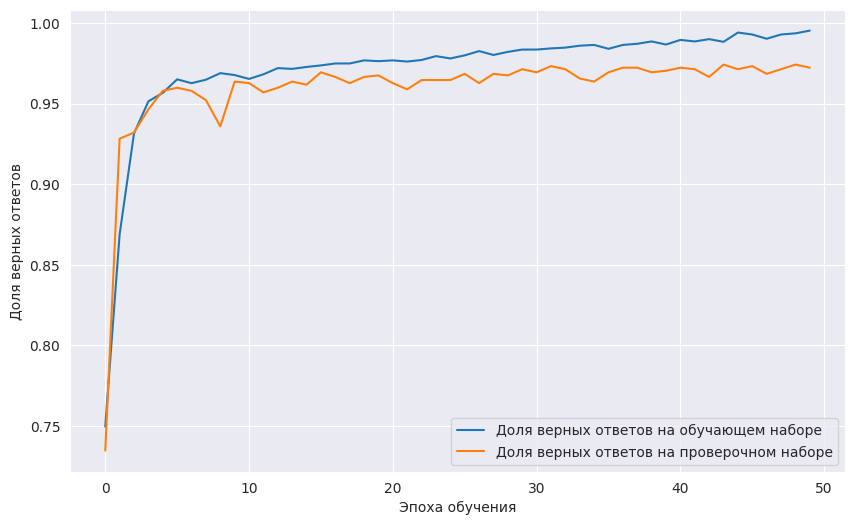





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 0.99
Максимальная точность на проверочной выборке: 0.976


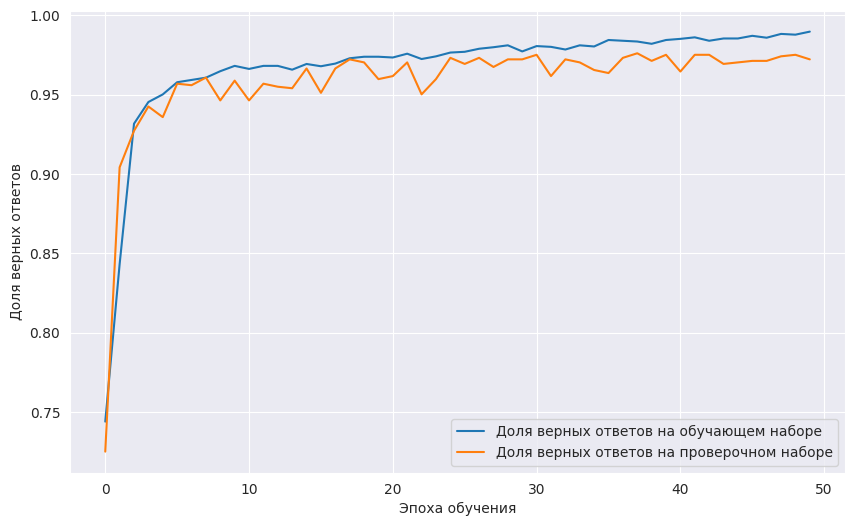





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 0.992
Максимальная точность на проверочной выборке: 0.974


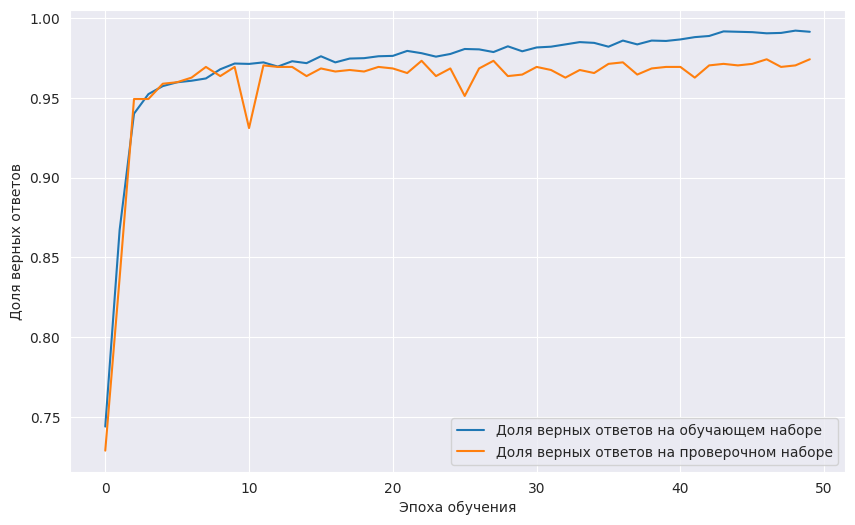





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 0.993
Максимальная точность на проверочной выборке: 0.974


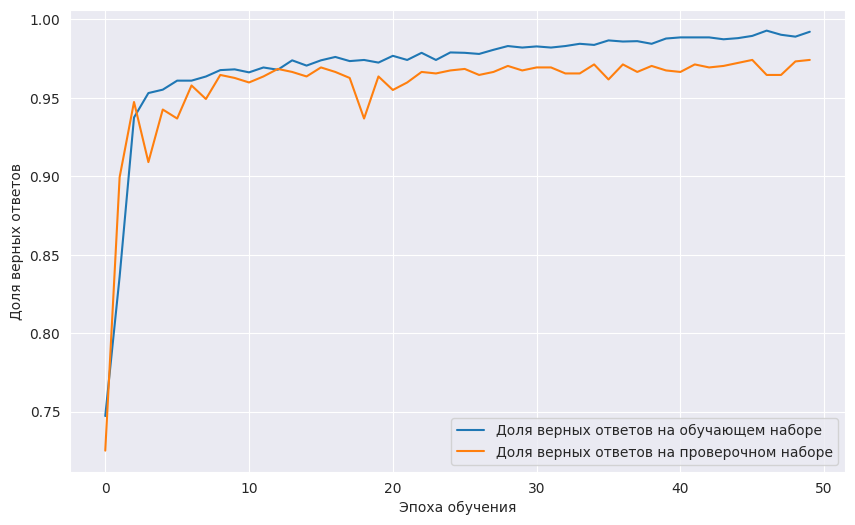





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 0.993
Максимальная точность на проверочной выборке: 0.973


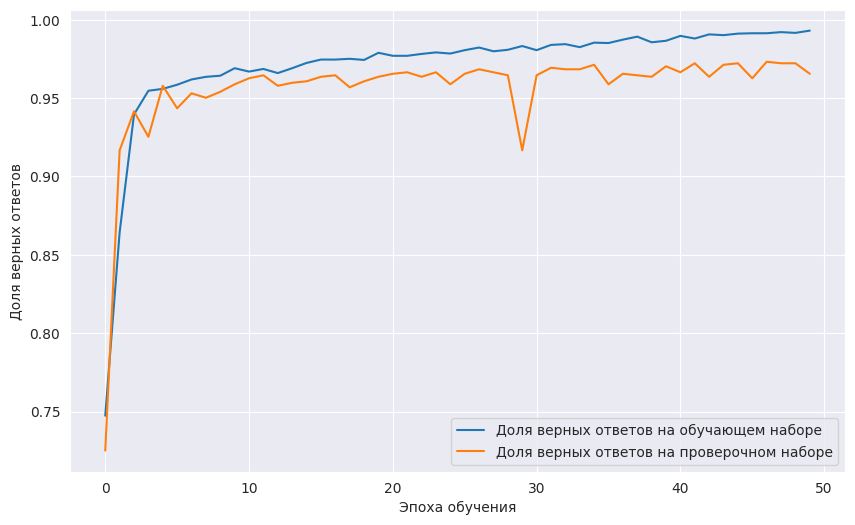





Средняя точность на обучающей выборке: 0.993
Максимальная точность на обучающей выборке: 0.995
Средняя точность на проверочной выборке: 0.974
Максимальная точность на проверочной выборке: 0.976


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 64, 64, 128)       1280      
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_95 (Conv2D)          (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 7, 7, 256)         0         
 ng2D)                                                           
                                                                 
 flatten_47 (Flatten)        (None, 12544)             0         
                                   

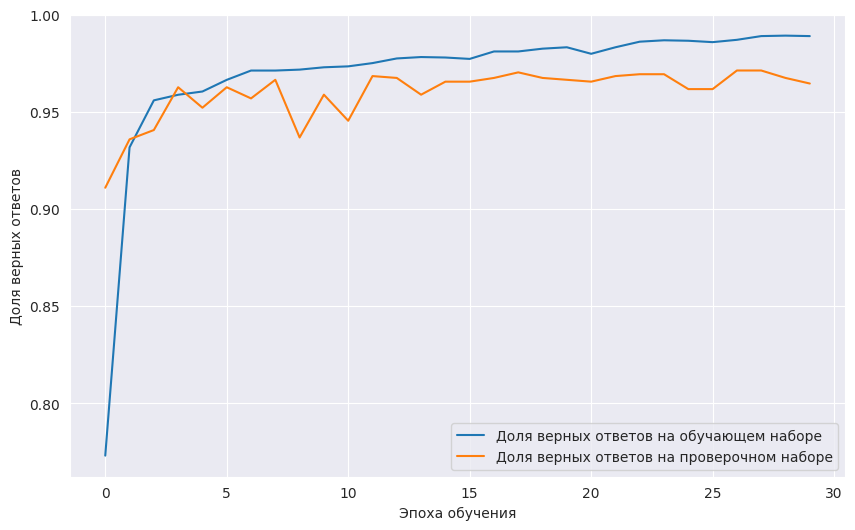

Максимальная точность на обучающей выборке: 0.989
Максимальная точность на проверочной выборке: 0.971

Матрица ошибок для обучающей выборки:


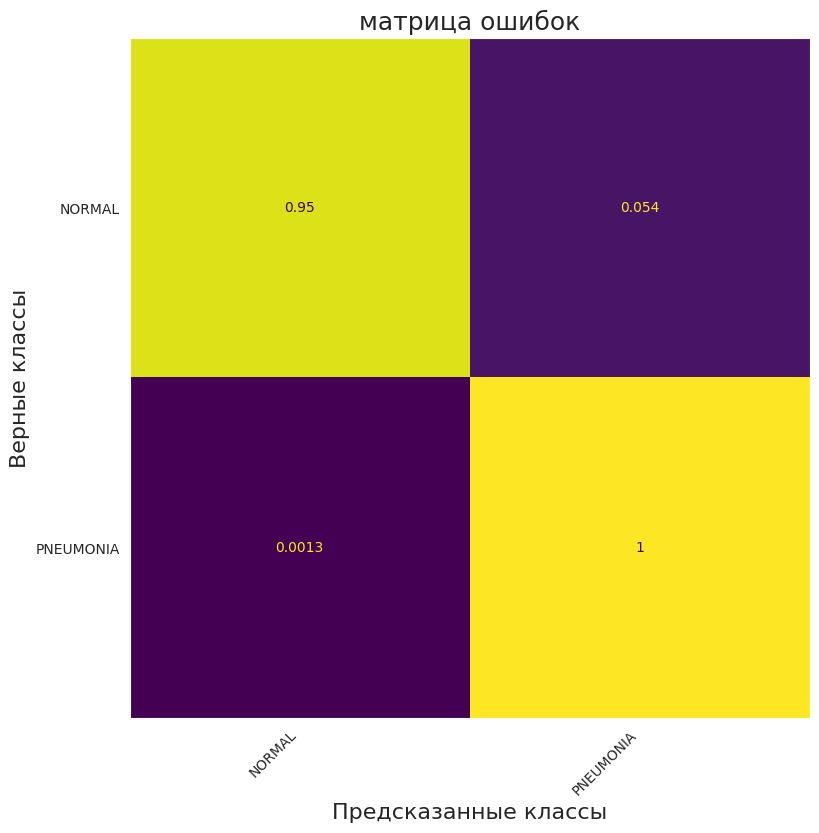


Матрица ошибок для проверочной выборки:


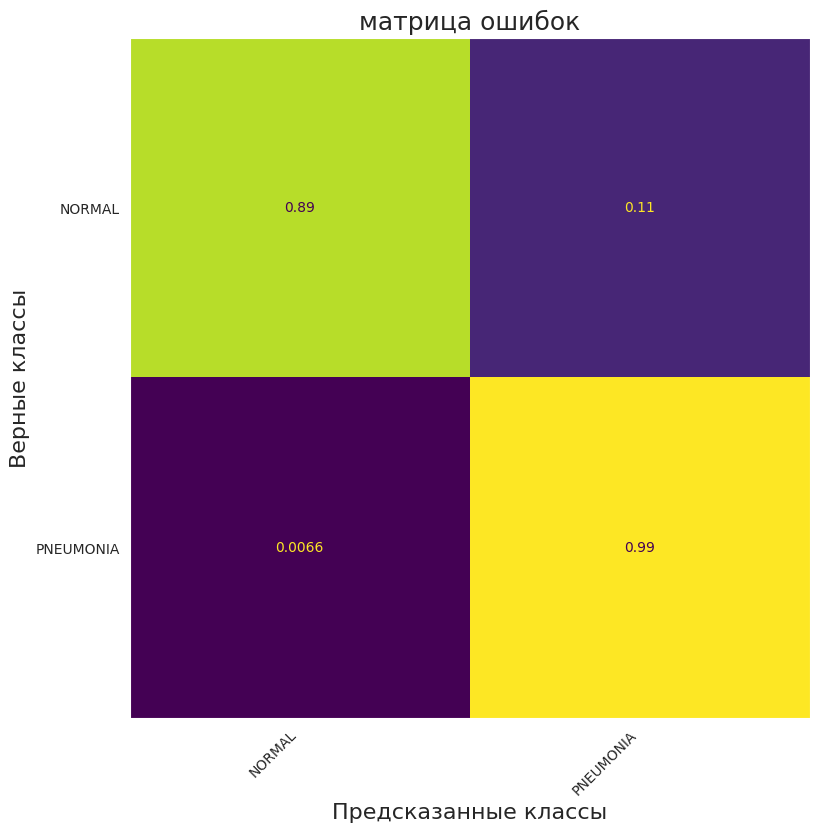

In [ ]:
#@title ### Эксп. №8 (усилен второй сверточный) (97.8% 98.1%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  # Первый сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.977


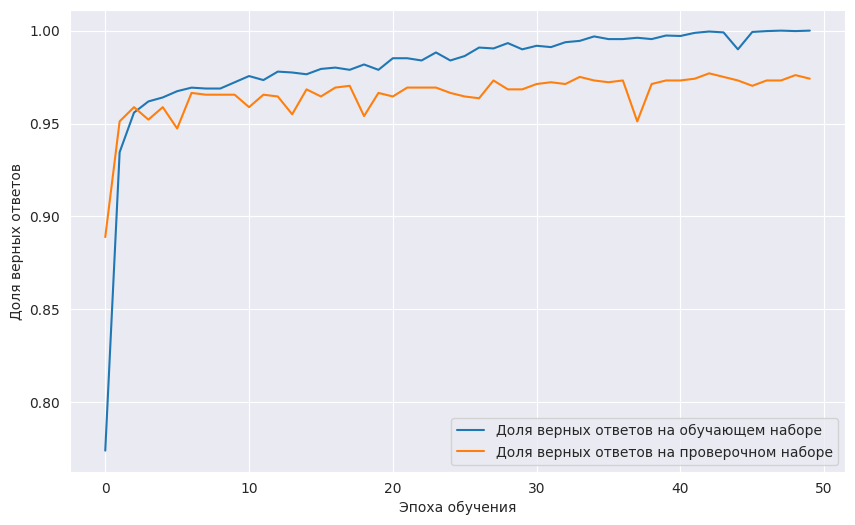





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.978


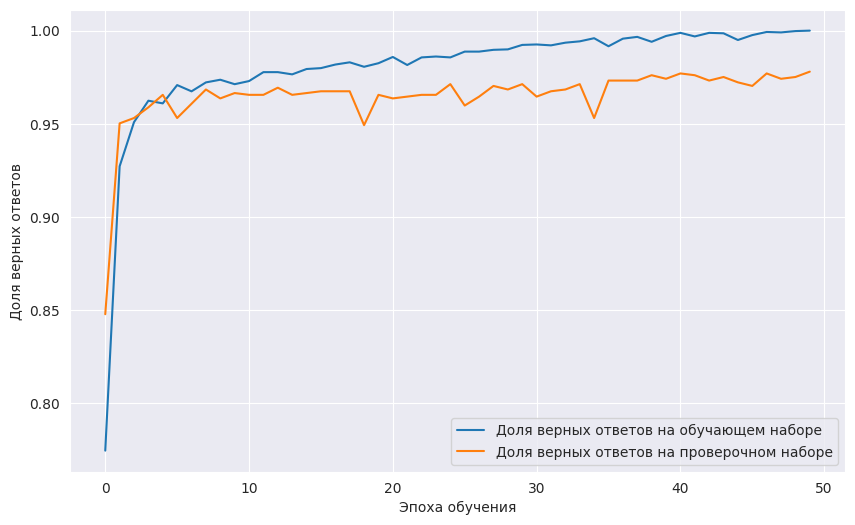





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.978


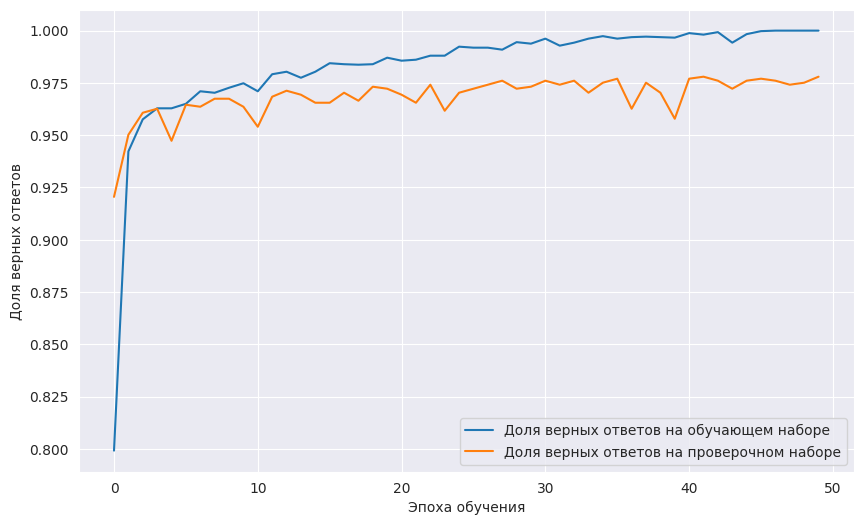





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.979


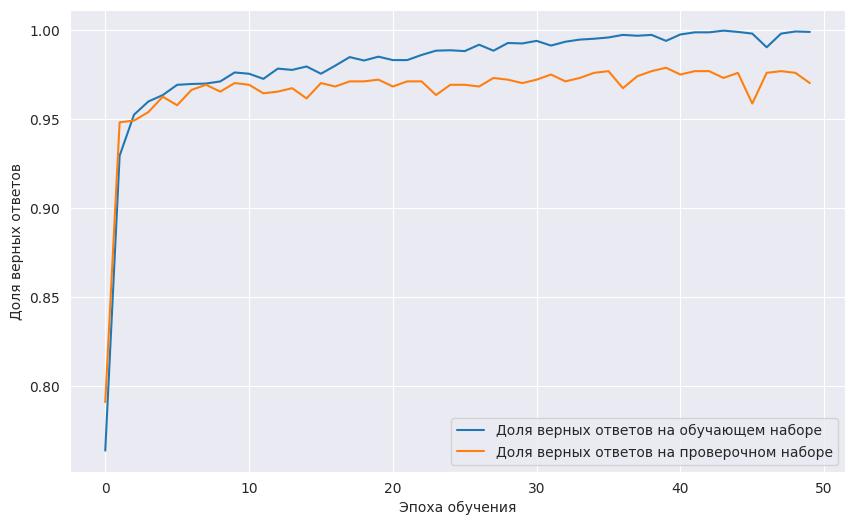





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.978


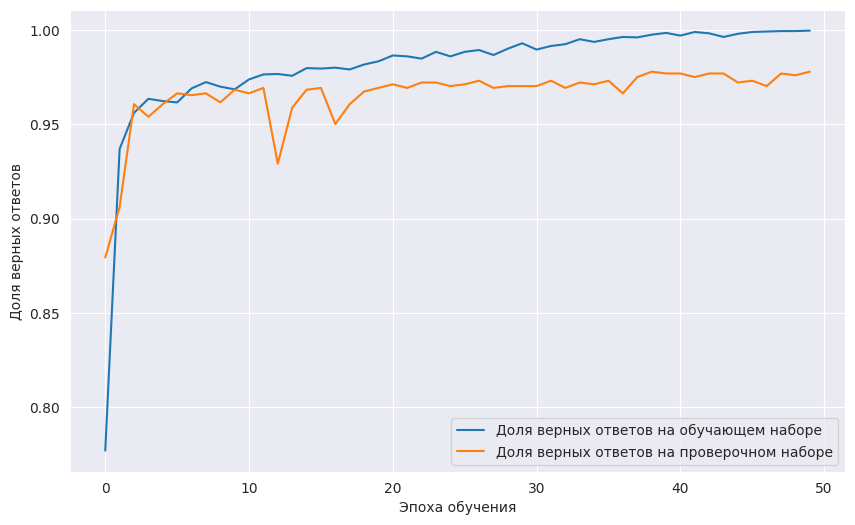





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.978
Максимальная точность на проверочной выборке: 0.979


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 64, 64, 128)       1280      
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_107 (Conv2D)         (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_108 (Conv2D)         (None, 7, 7, 128)         147584    
                                   

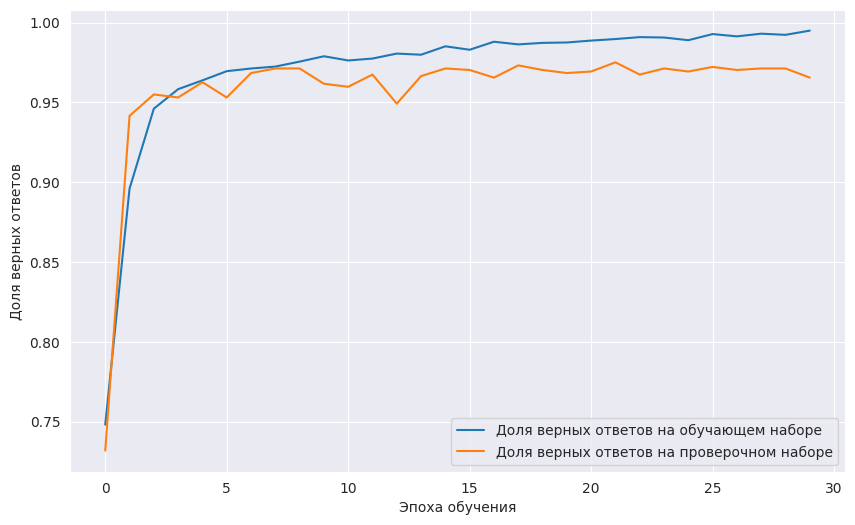

Максимальная точность на обучающей выборке: 0.995
Максимальная точность на проверочной выборке: 0.975

Матрица ошибок для обучающей выборки:


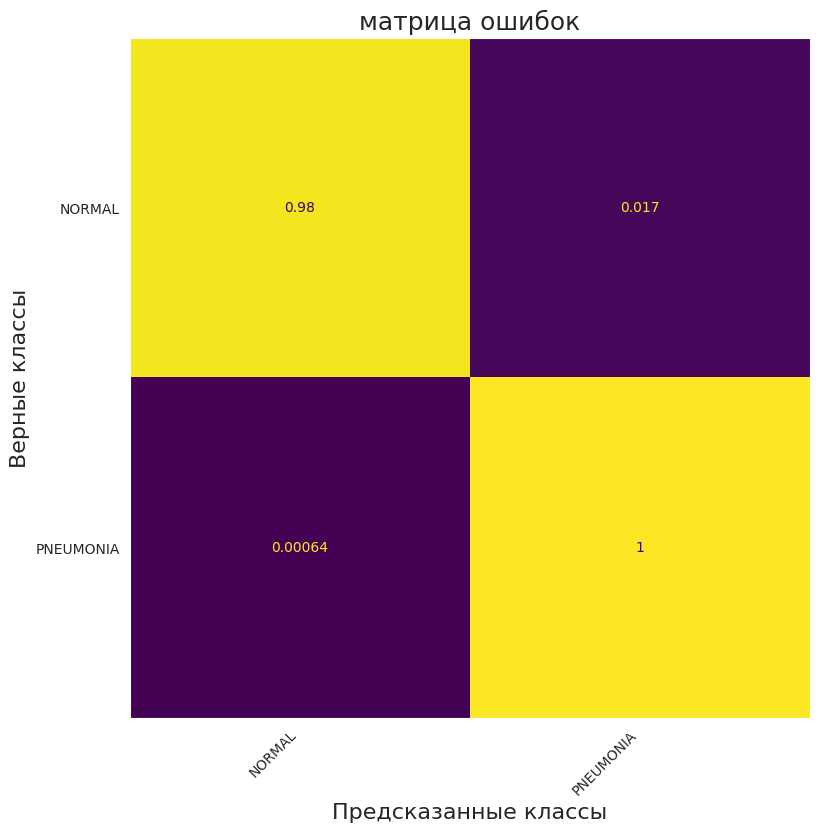


Матрица ошибок для проверочной выборки:


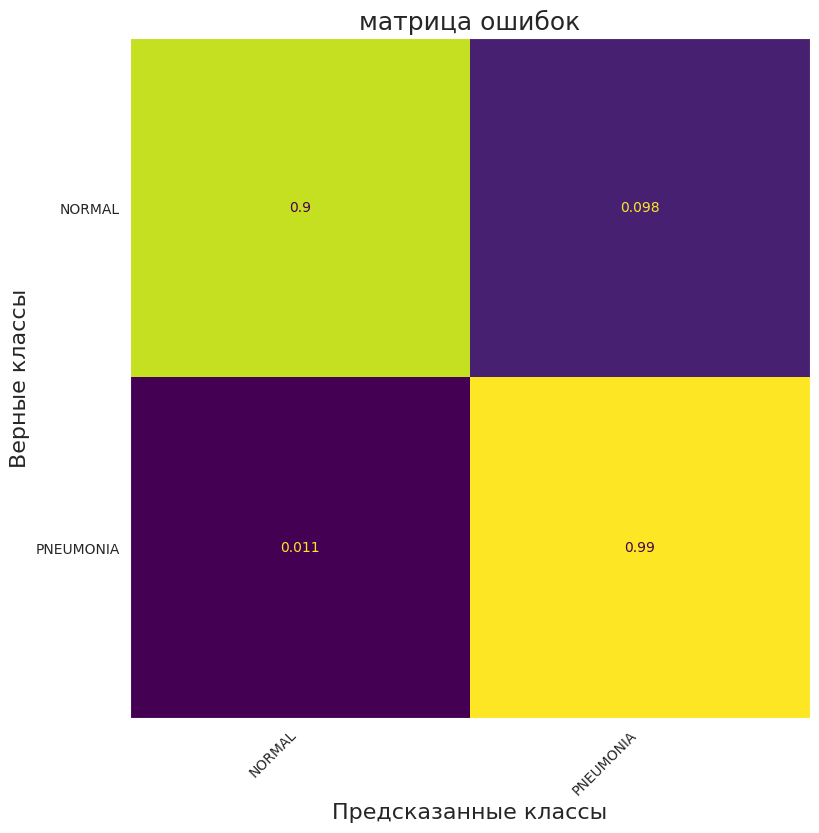

In [ ]:
#@title ### Эксп. №9 (добавление третьего сверточного блока) (98.1% 98.4%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Третий сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.978


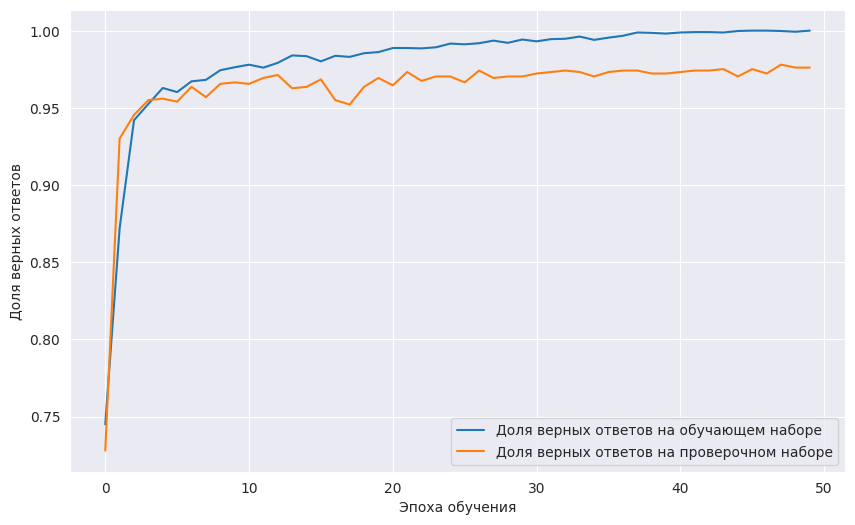





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.974


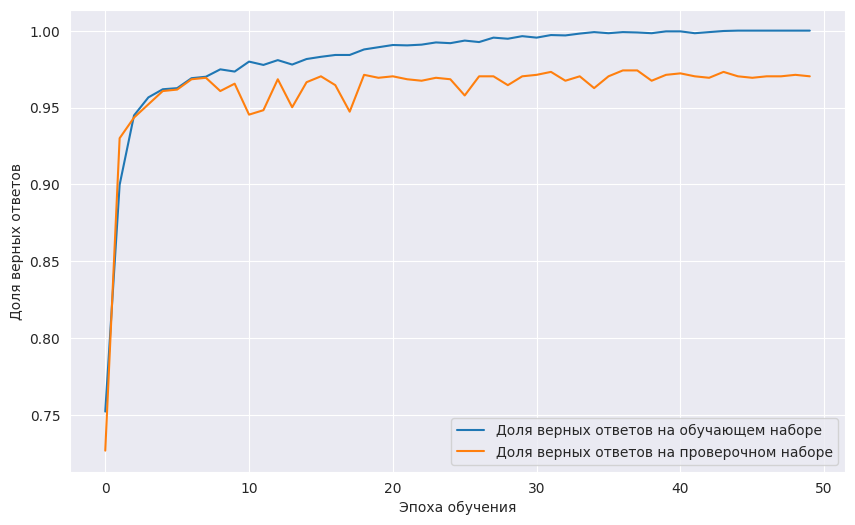





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.975


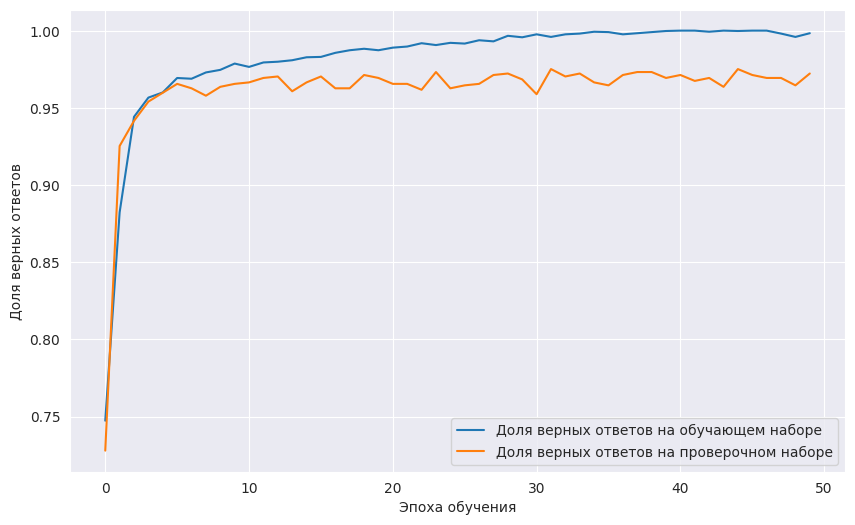





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.974


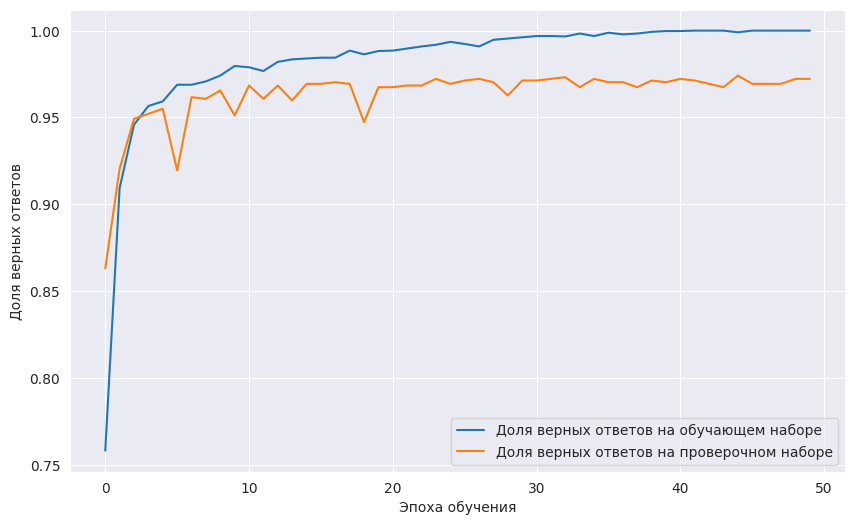





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.978


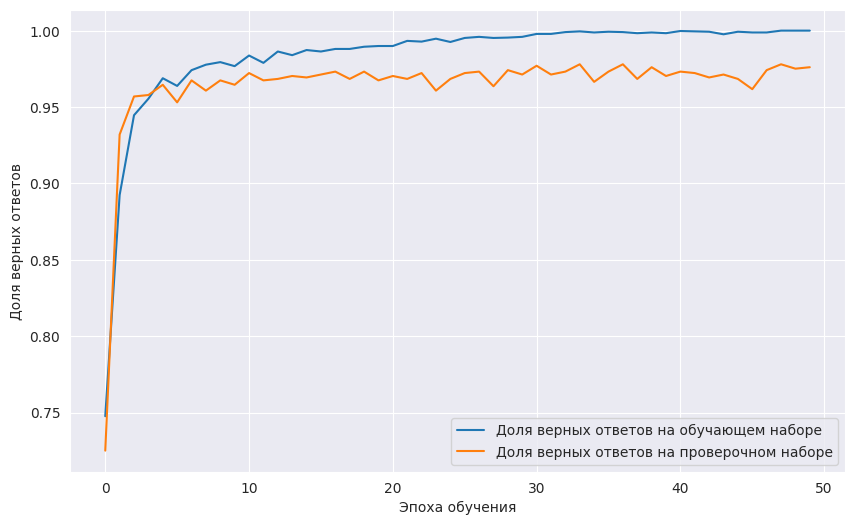





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.976
Максимальная точность на проверочной выборке: 0.978


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 64, 64, 128)       1280      
                                                                 
 max_pooling2d_112 (MaxPool  (None, 32, 32, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_125 (Conv2D)         (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_113 (MaxPool  (None, 16, 16, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_126 (Conv2D)         (None, 16, 16, 128)       147584    
                                   

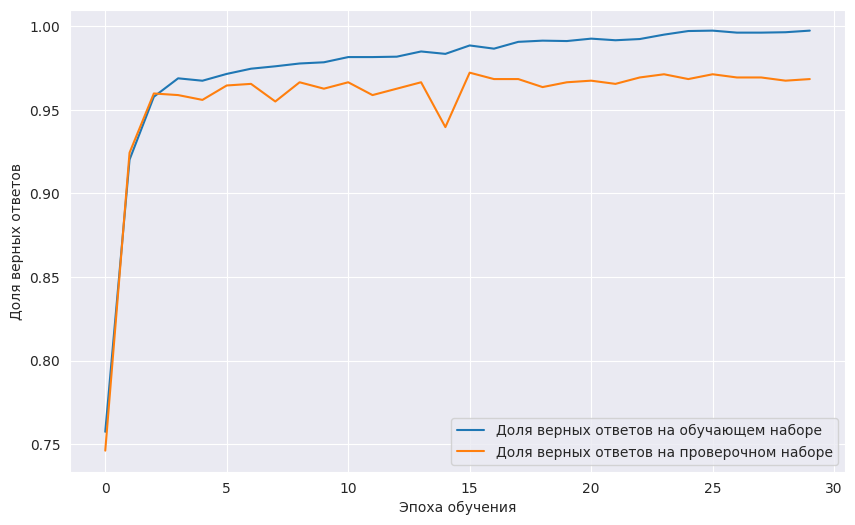

Максимальная точность на обучающей выборке: 0.997
Максимальная точность на проверочной выборке: 0.972

Матрица ошибок для обучающей выборки:


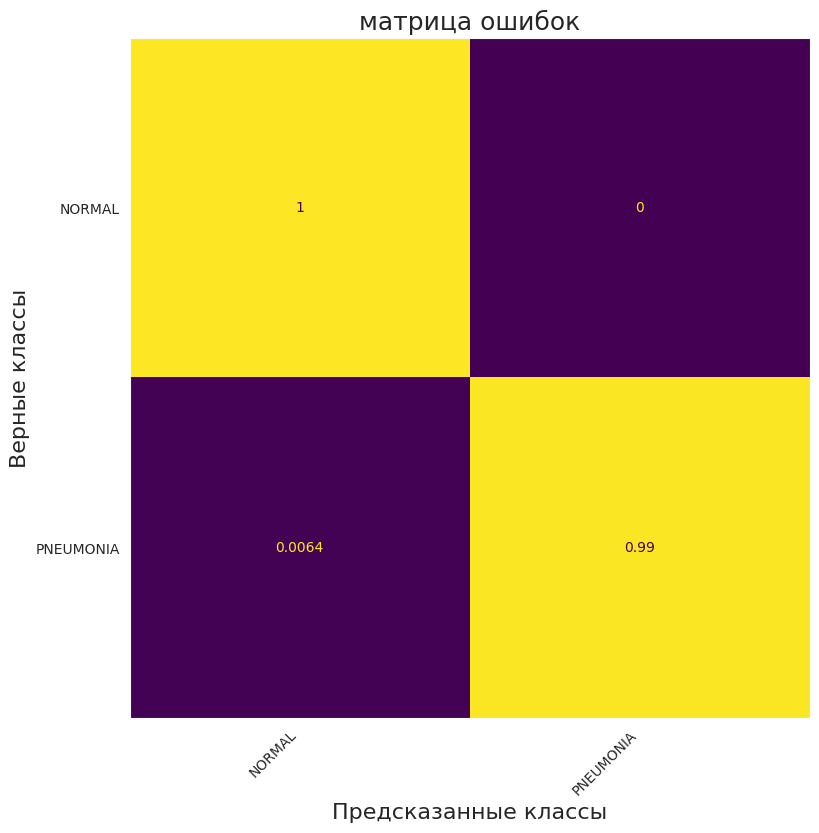


Матрица ошибок для проверочной выборки:


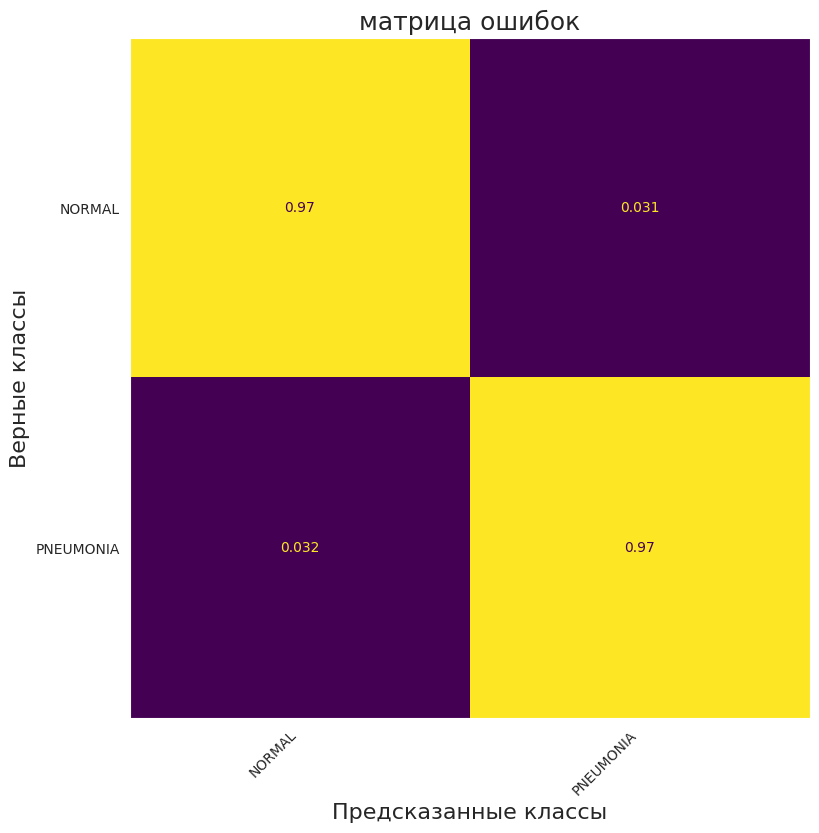

In [ ]:
#@title ### Эксп. №10 (добавление четвертого сверточного блока) (98.3% 98.6%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
#
  # Второй сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
#
  # Третий сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
#
  # Четвертый сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.977


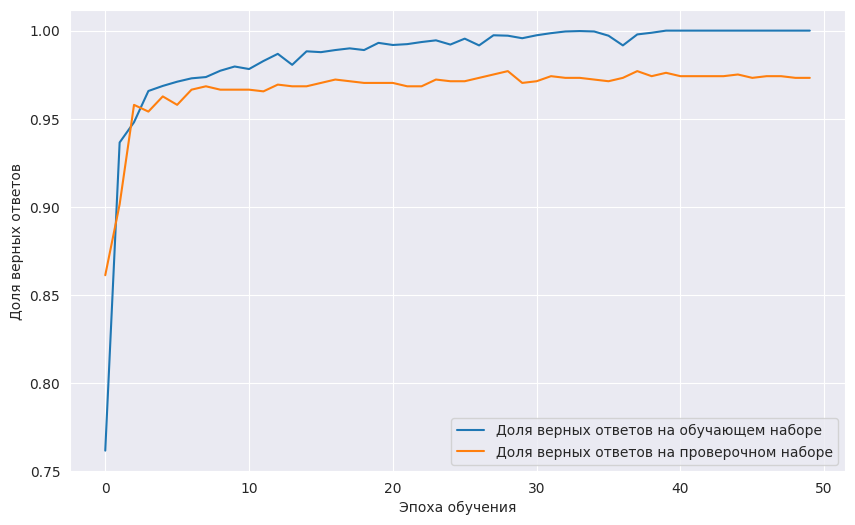





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.974


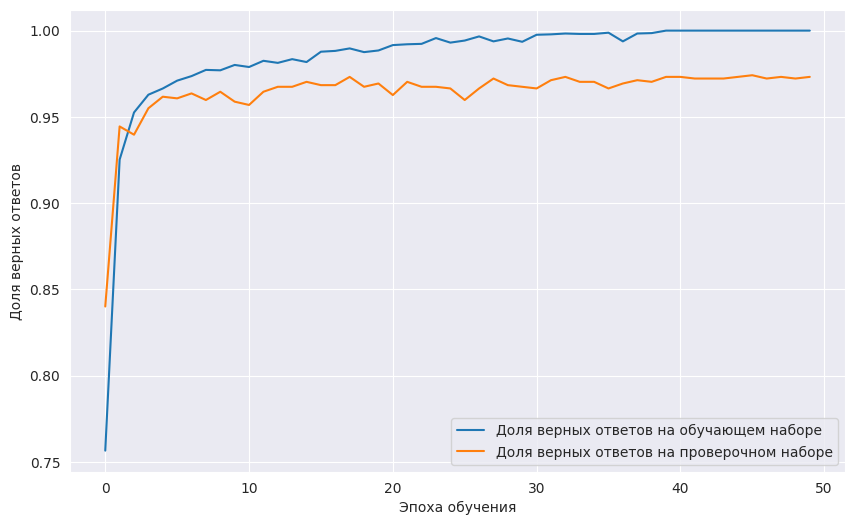





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.977


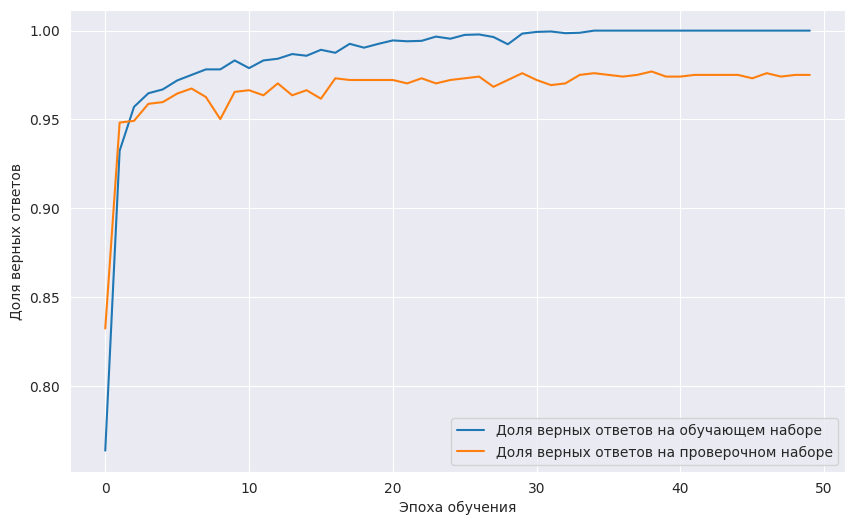





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.976


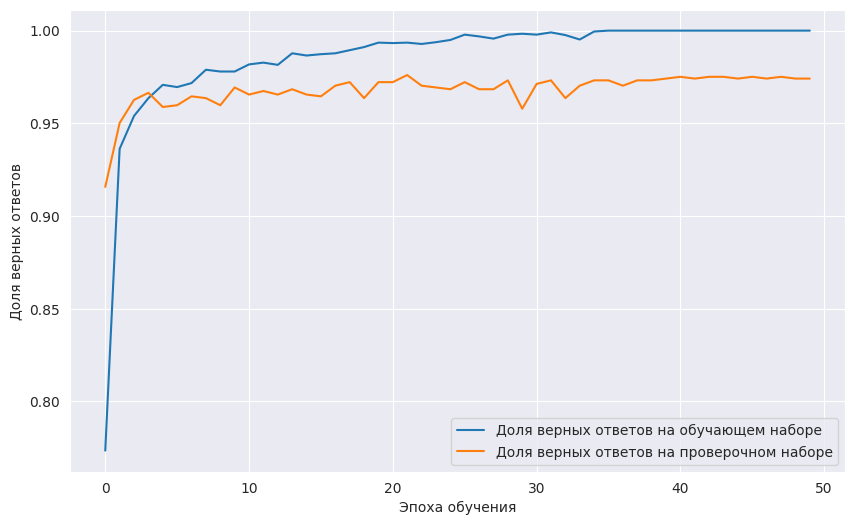





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.975


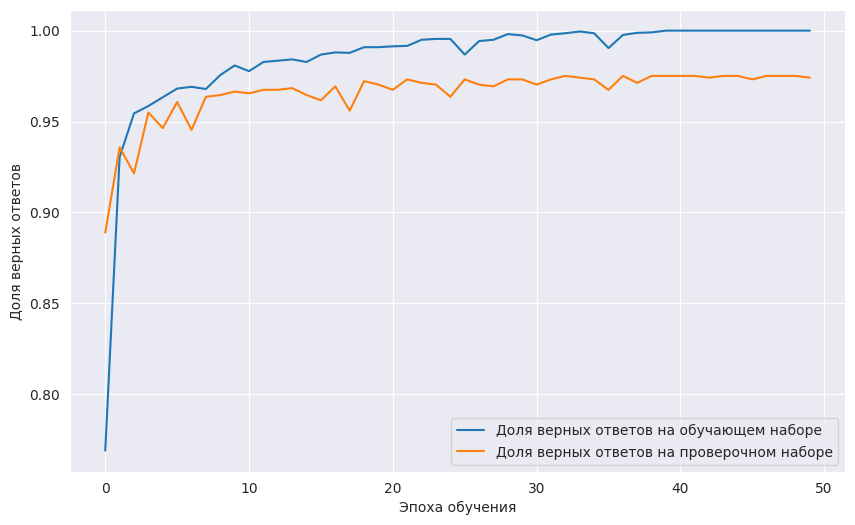





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.976
Максимальная точность на проверочной выборке: 0.977


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 64, 64)
Размер проверочной выборки: (1044, 64, 64)
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_148 (Conv2D)         (None, 64, 64, 128)       1280      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d_136 (MaxPool  (None, 21, 21, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_149 (Conv2D)         (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_137 (MaxPool  (None, 7, 7, 128)         0         
 ing2D)                            

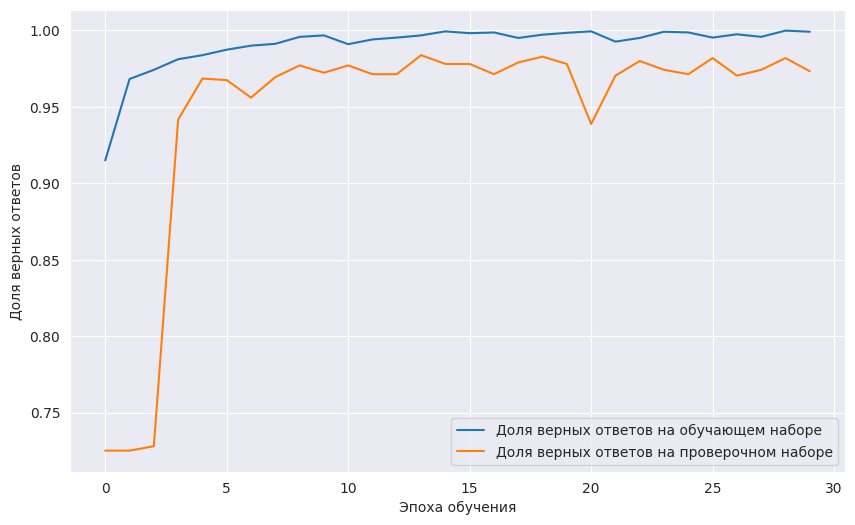

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.984

Матрица ошибок для обучающей выборки:


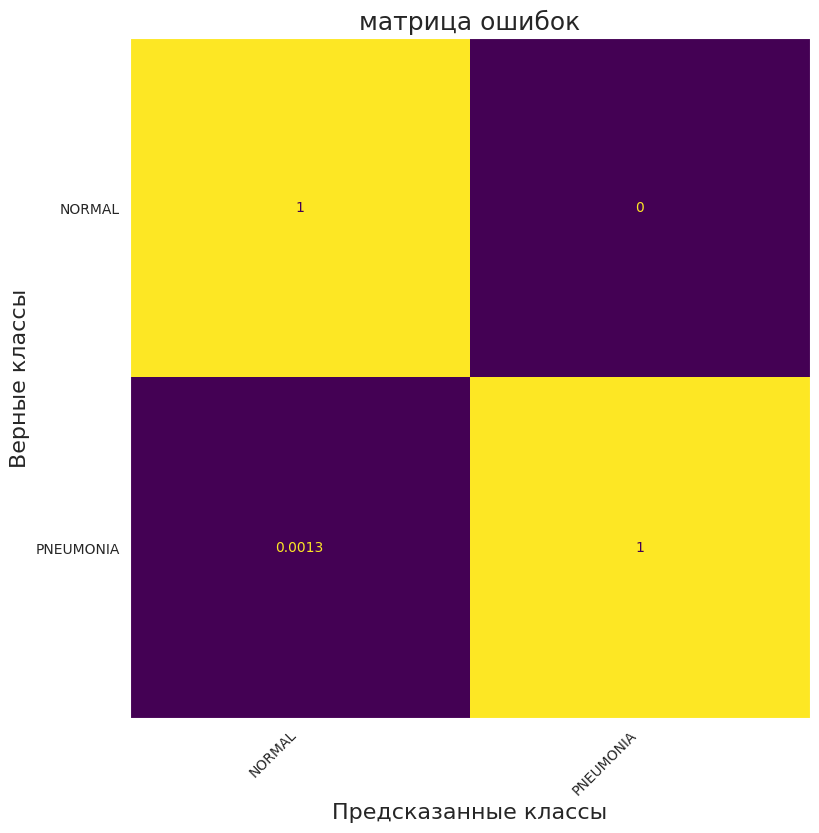


Матрица ошибок для проверочной выборки:


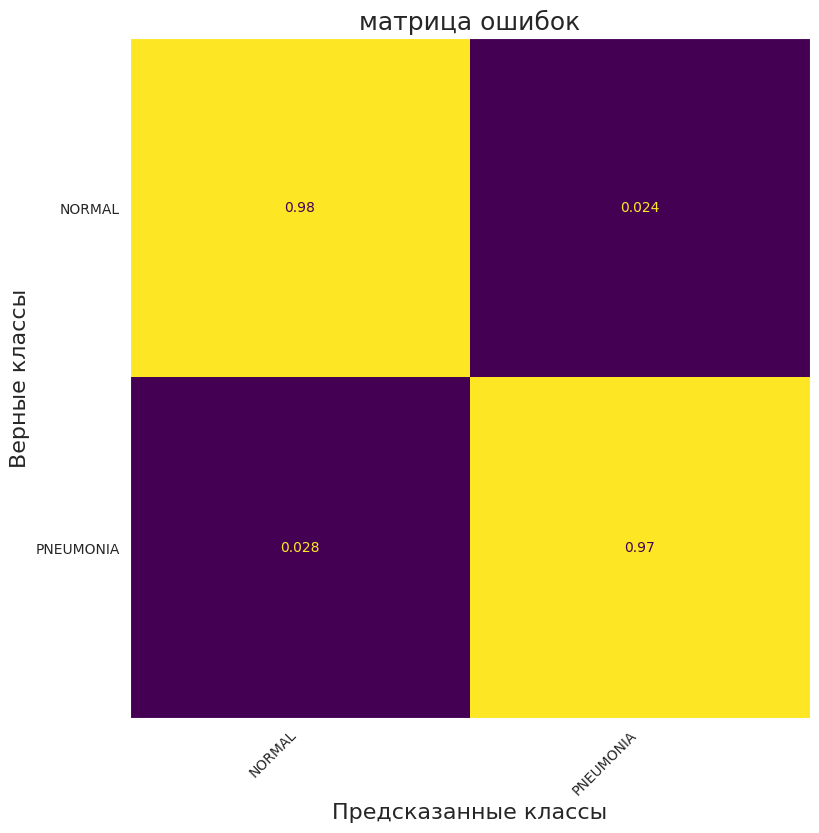

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


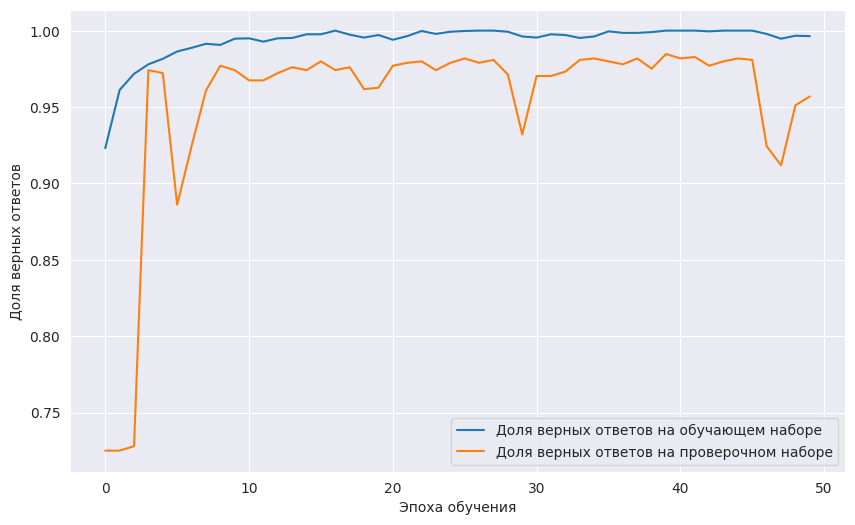





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


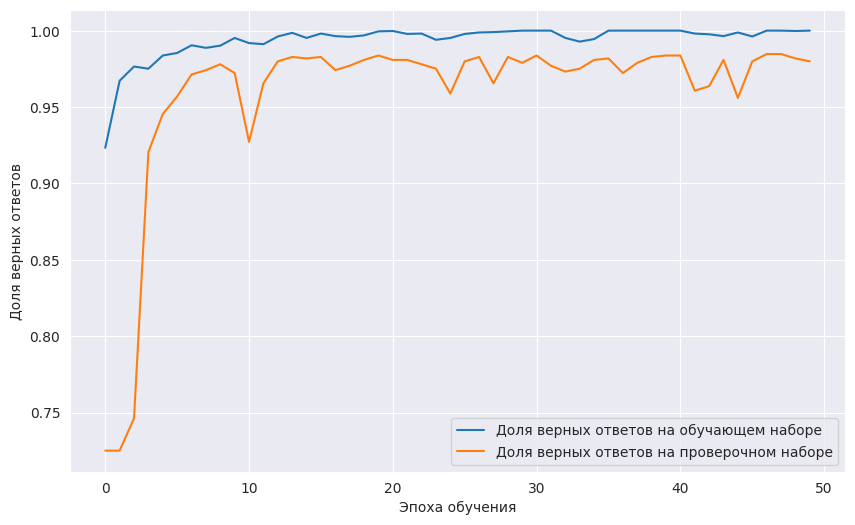





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.986


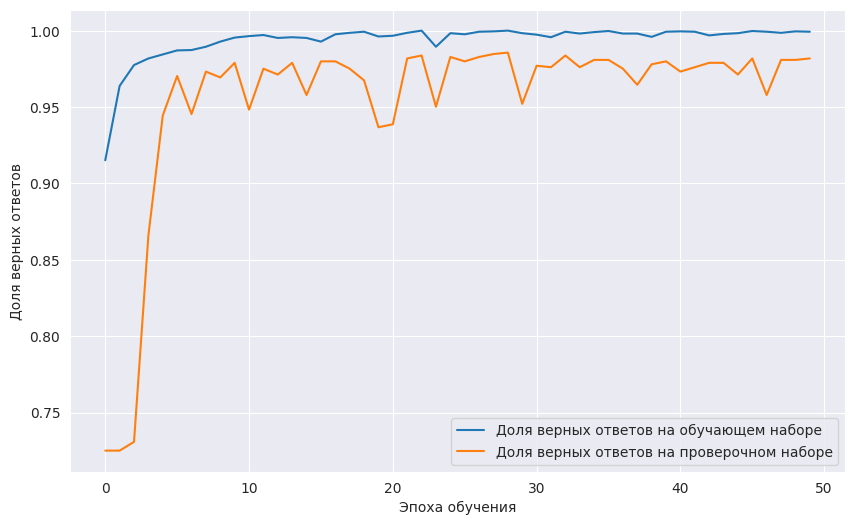





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.984


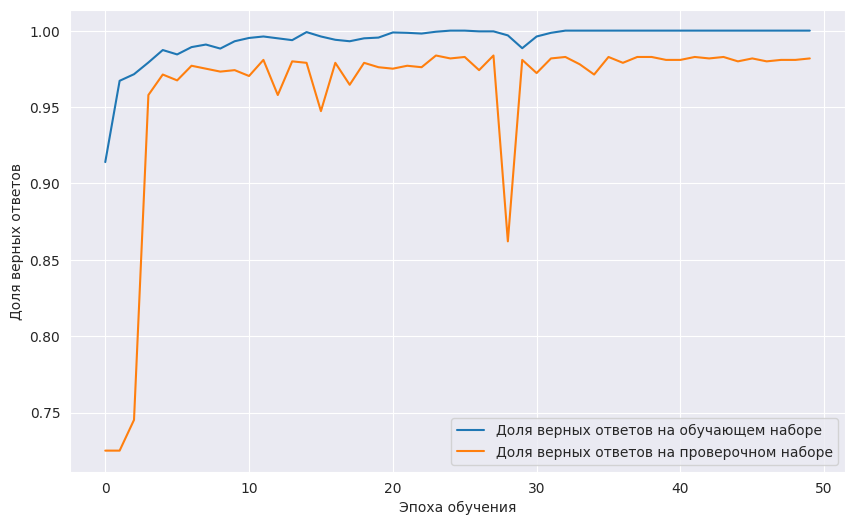





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


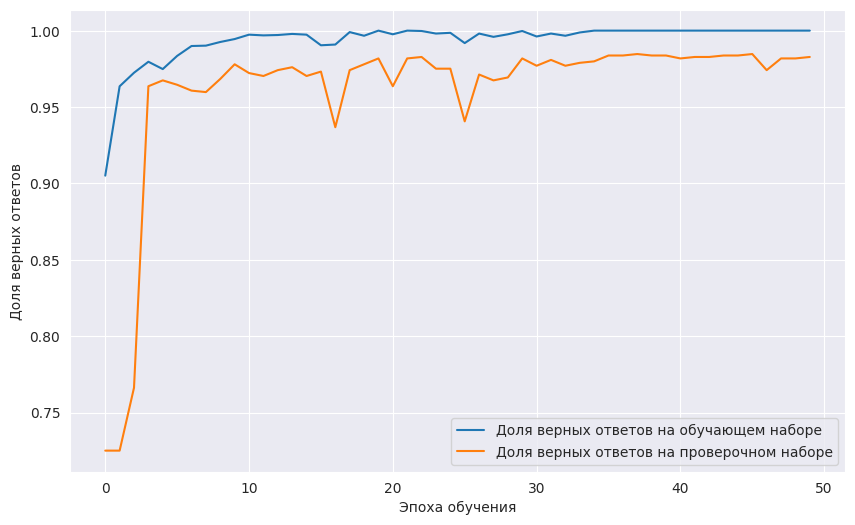





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.985
Максимальная точность на проверочной выборке: 0.986


In [ ]:
#@title ### Эксп. №11 (добавление BatchNorm + Dropout) (98.7% 98.9%)
#
# Создание выборок
IMG_HEIGHT = 64
IMG_WIDTH = 64
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.2))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 128, 128)
Размер проверочной выборки: (1044, 128, 128)
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_172 (Conv2D)         (None, 128, 128, 128)     1280      
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 128)     512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_154 (MaxPool  (None, 42, 42, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_173 (Conv2D)         (None, 42, 42, 128)       147584    
                                                                 
 max_pooling2d_155 (MaxPool  (None, 14, 14, 128)       0         
 ing2D)                        

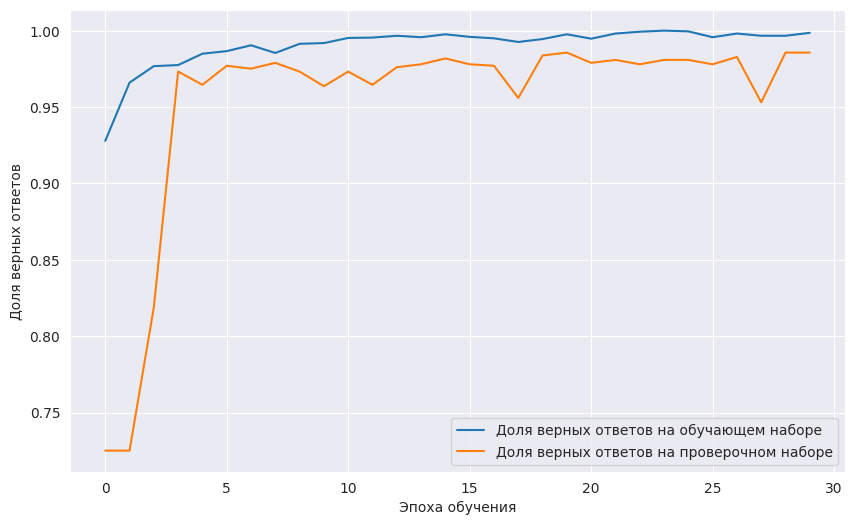

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.986

Матрица ошибок для обучающей выборки:


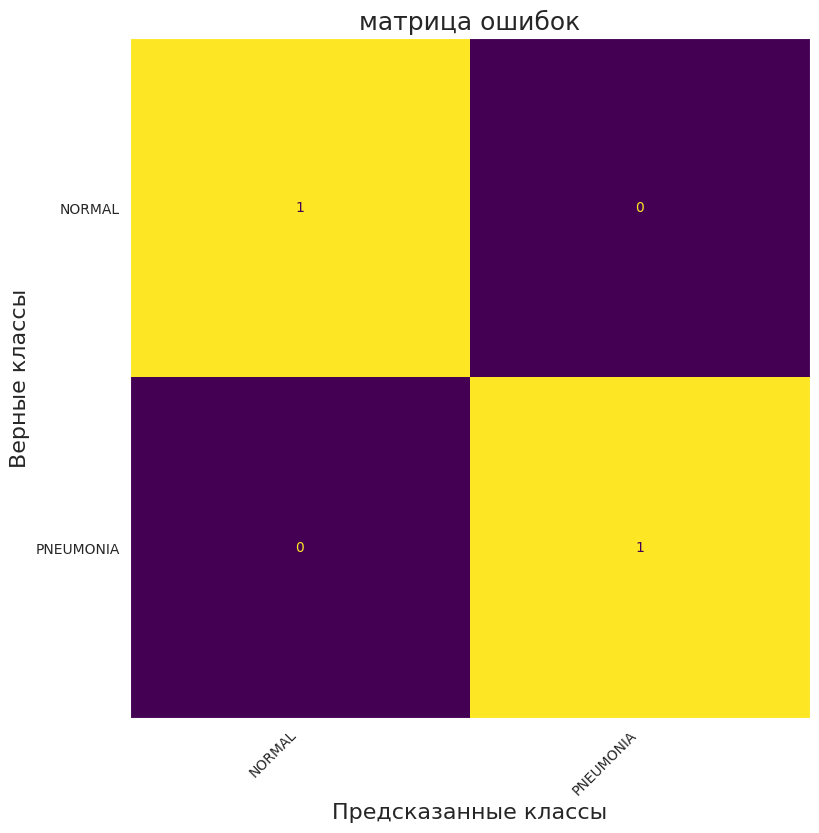


Матрица ошибок для проверочной выборки:


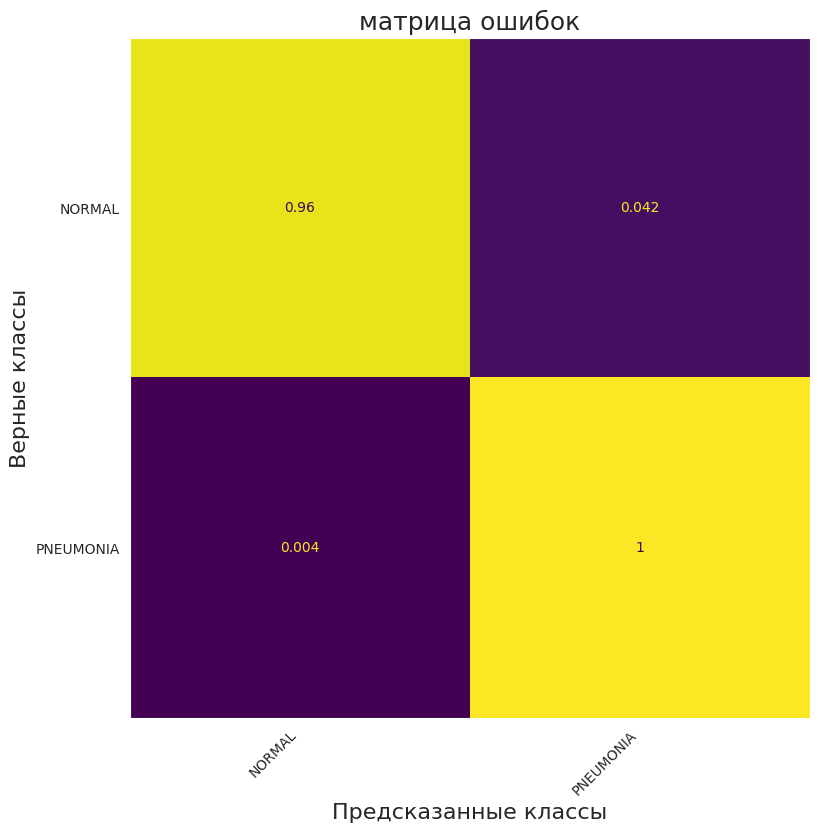

In [ ]:
#@title ### Эксп. №12 (Переход на 128х128) (98.9% 98.9%)
#
# Создание выборок
IMG_HEIGHT = 128
IMG_WIDTH = 128
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  # Второй сверточный блок
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.2))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.987


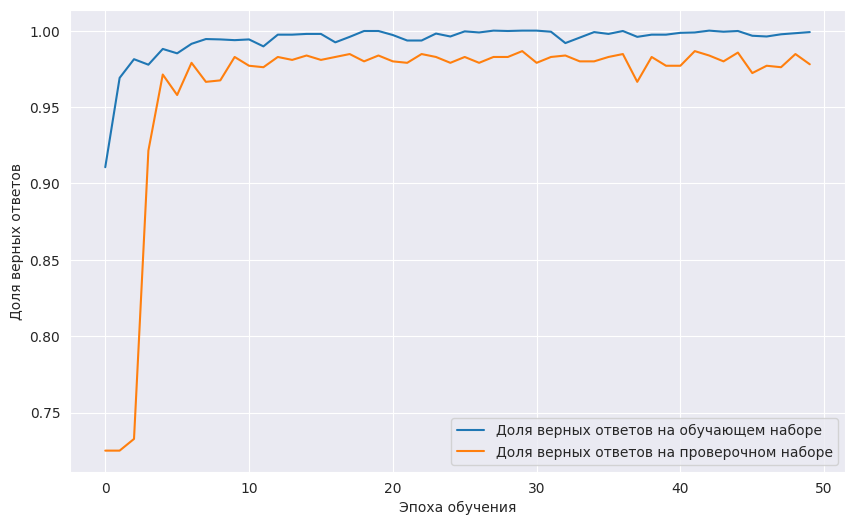





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.989


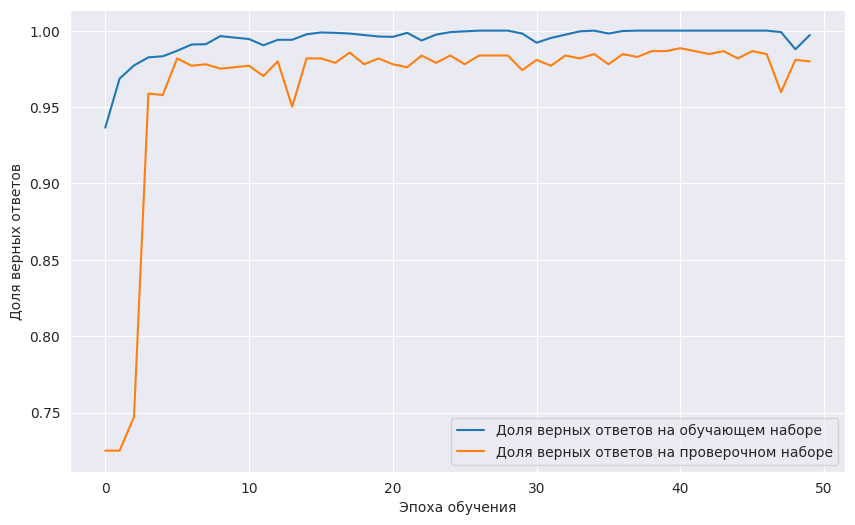





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.987


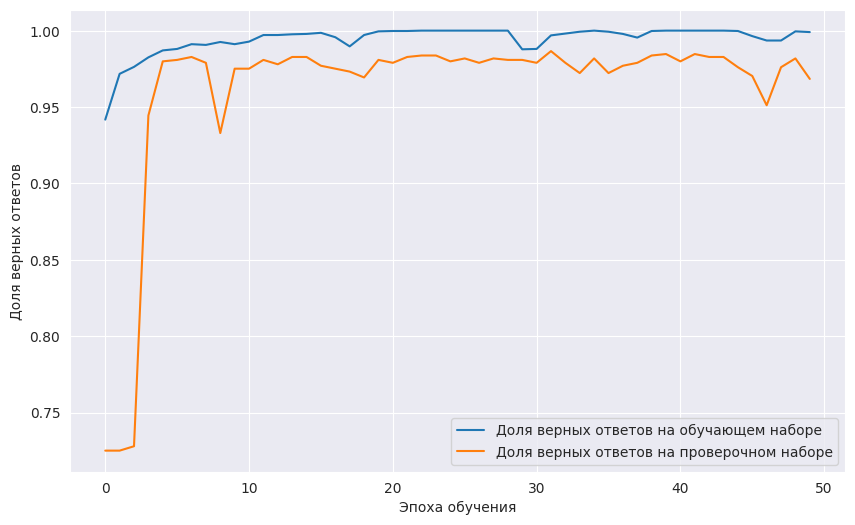





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.989


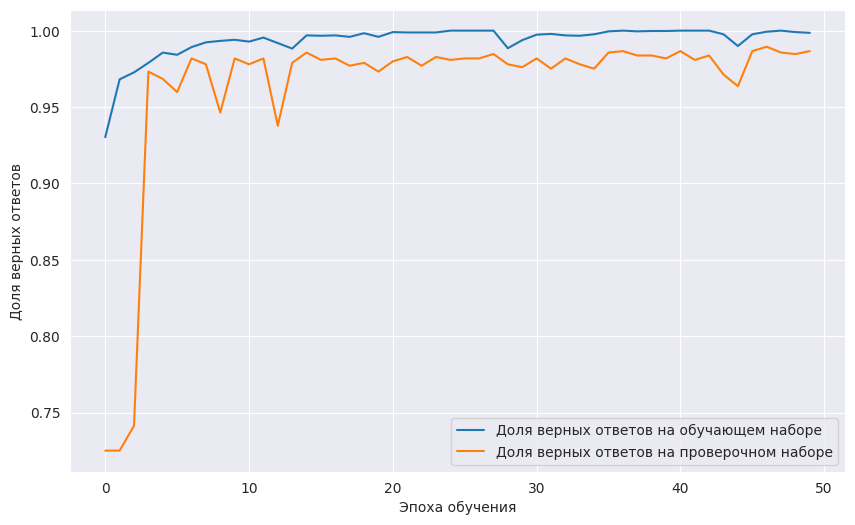





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.988


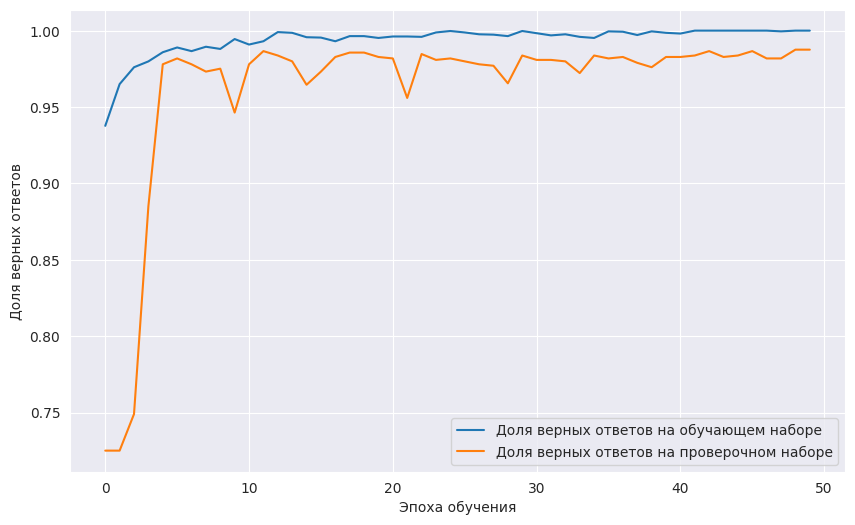





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.988
Максимальная точность на проверочной выборке: 0.989


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 128, 128)
Размер проверочной выборки: (1044, 128, 128)
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 128, 128, 128)     640       
                                                                 
 batch_normalization_24 (Ba  (None, 128, 128, 128)     512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_172 (MaxPool  (None, 42, 42, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_197 (Conv2D)         (None, 42, 42, 128)       147584    
                                                                 
 batch_normalization_25 (Ba  (None, 42, 42, 128)       512       
 tchNormalization)             

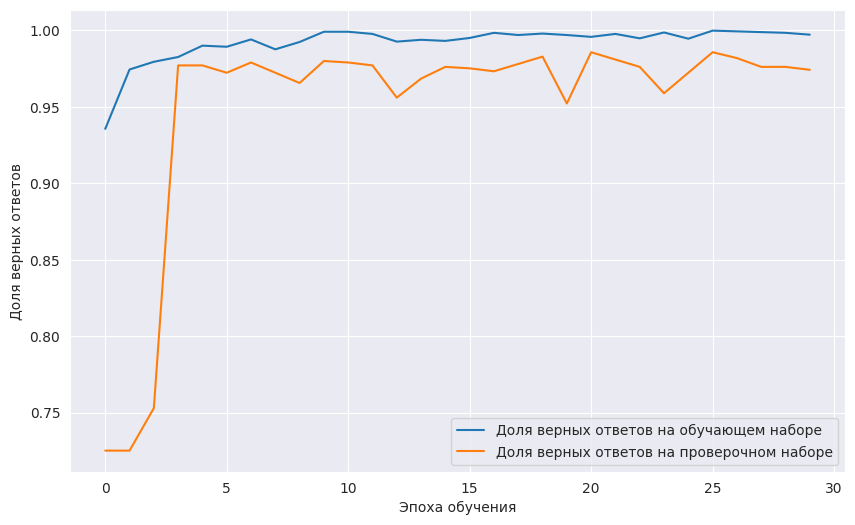

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.986

Матрица ошибок для обучающей выборки:


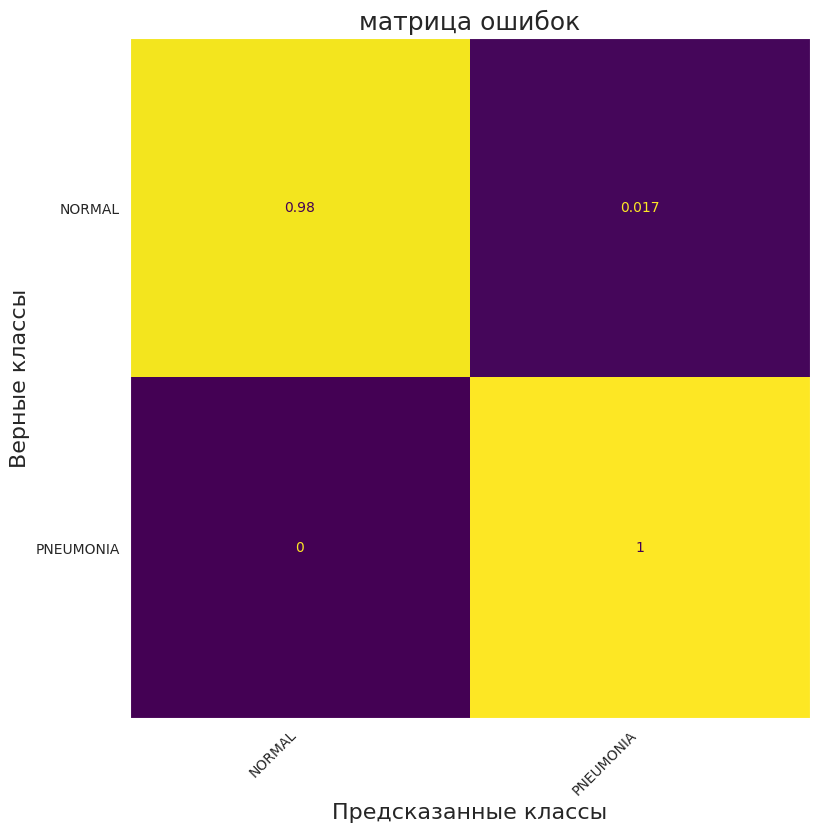


Матрица ошибок для проверочной выборки:


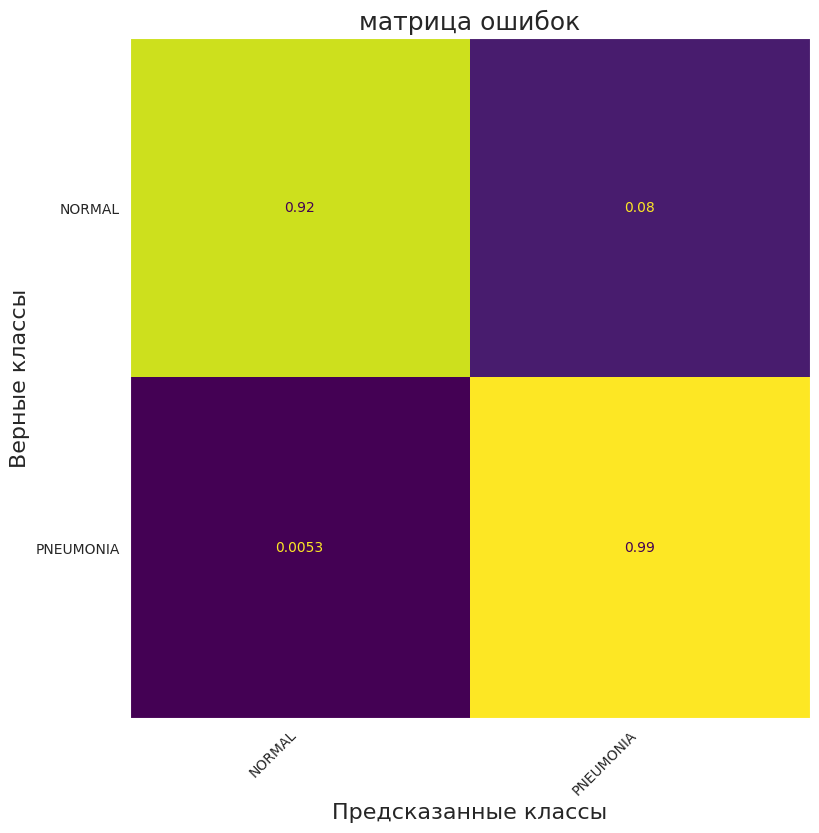

In [ ]:
#@title ### Эксп. №13 (Смена ядра сверточного слоя) (98.9% 98.9%)
#
# Создание выборок
IMG_HEIGHT = 128
IMG_WIDTH = 128
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
  model.add(Conv2D(128, (2, 2), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
#
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Dropout(0.2))
#
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.989


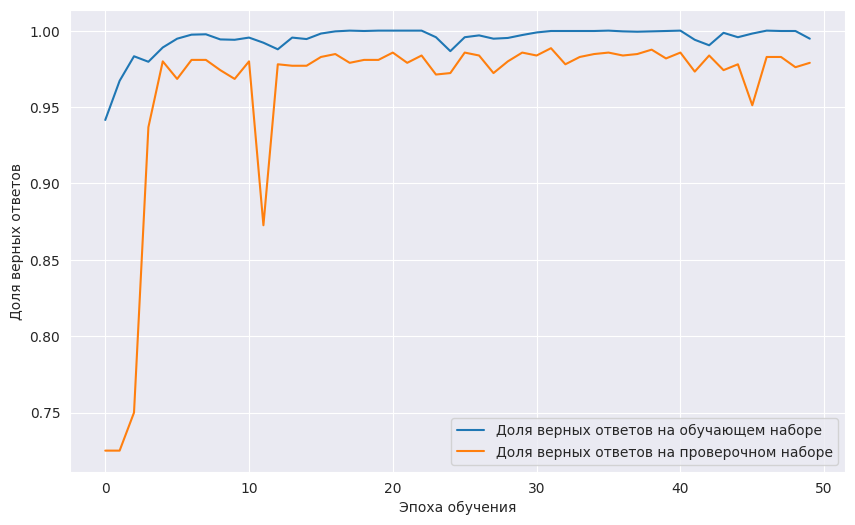





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.986


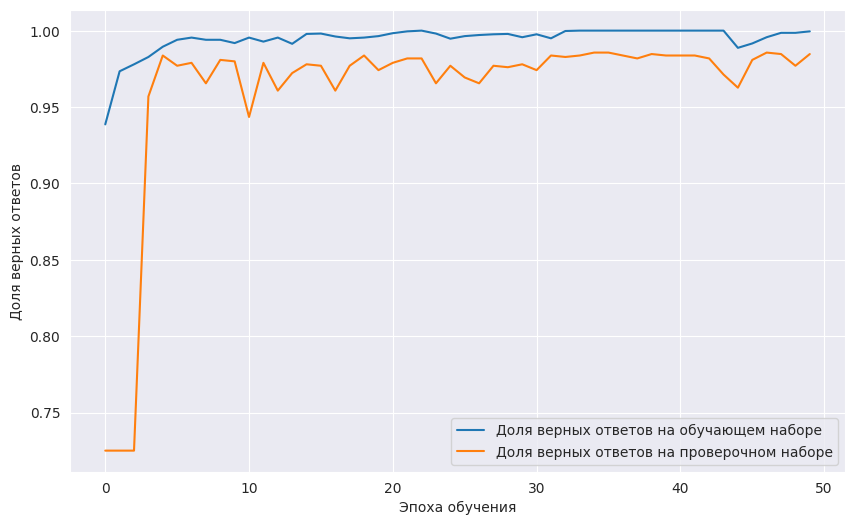





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


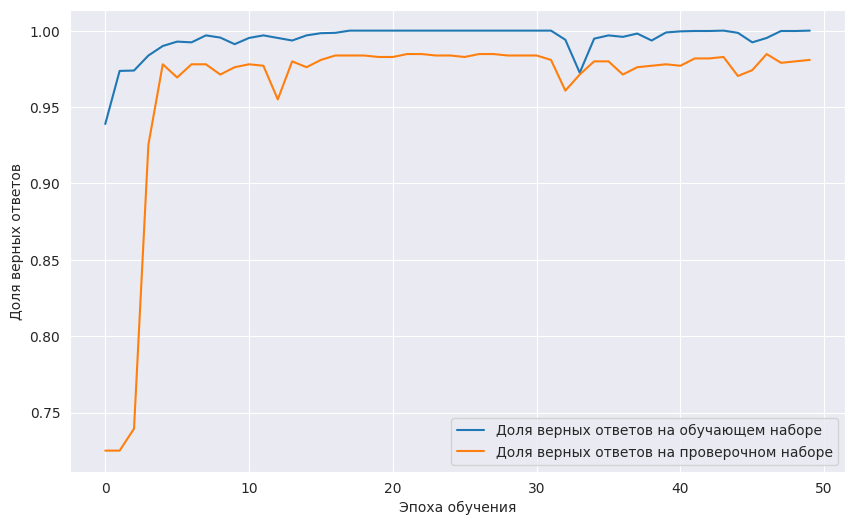





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.99


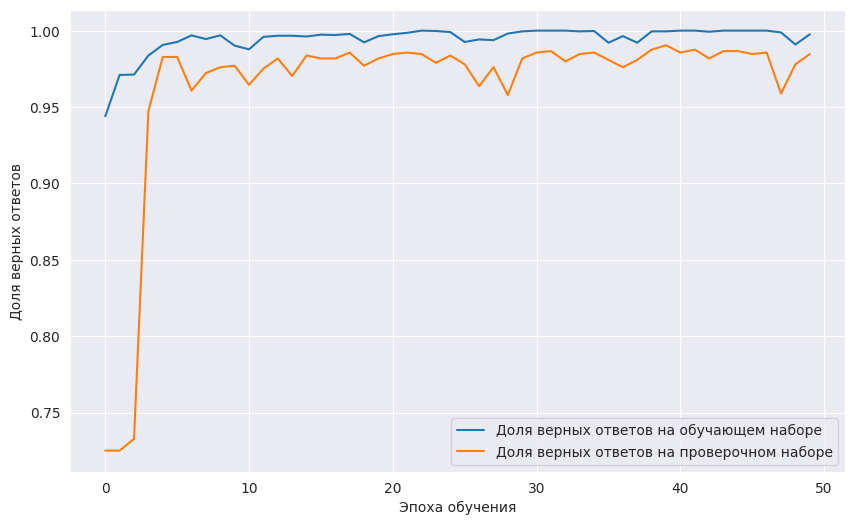





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.989


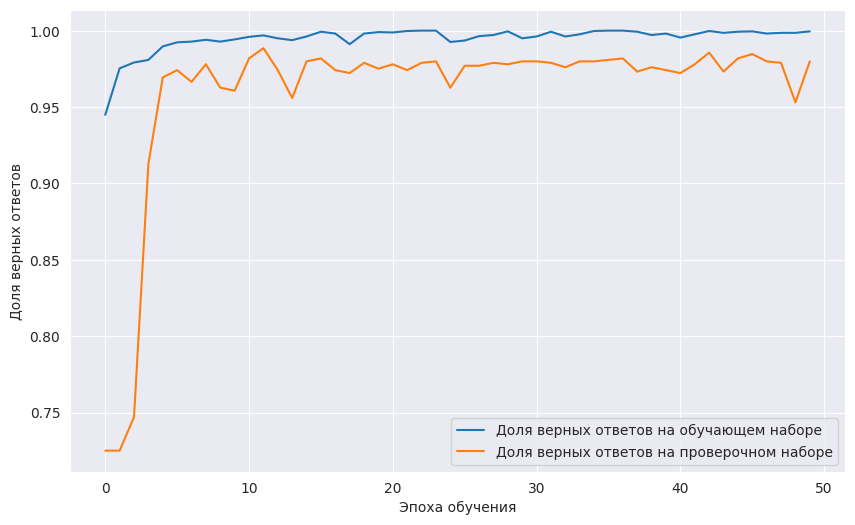





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.988
Максимальная точность на проверочной выборке: 0.99


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

Размер обучающей выборки: (4172, 128, 128)
Размер проверочной выборки: (1044, 128, 128)
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_266 (Conv2D)         (None, 128, 128, 128)     640       
                                                                 
 batch_normalization_94 (Ba  (None, 128, 128, 128)     512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_214 (MaxPool  (None, 42, 42, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_267 (Conv2D)         (None, 42, 42, 128)       409728    
                                                                 
 batch_normalization_95 (Ba  (None, 42, 42, 128)       512       
 tchNormalization)             

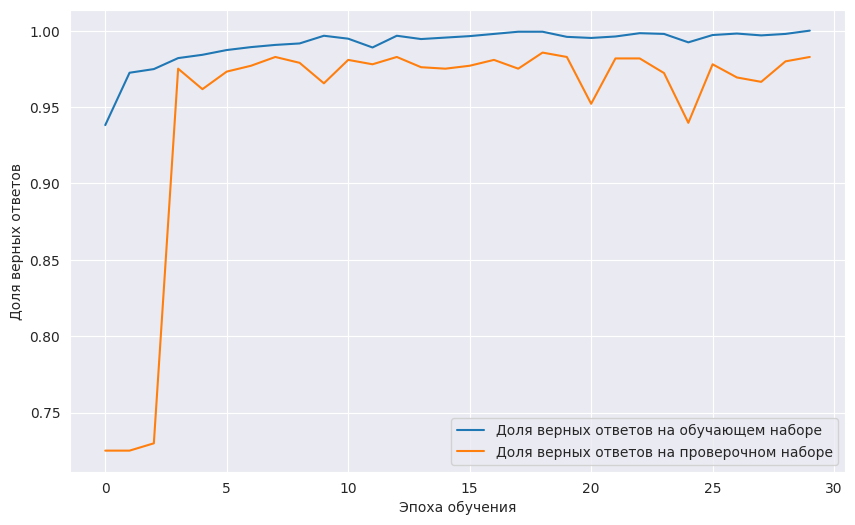

Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.986

Матрица ошибок для обучающей выборки:


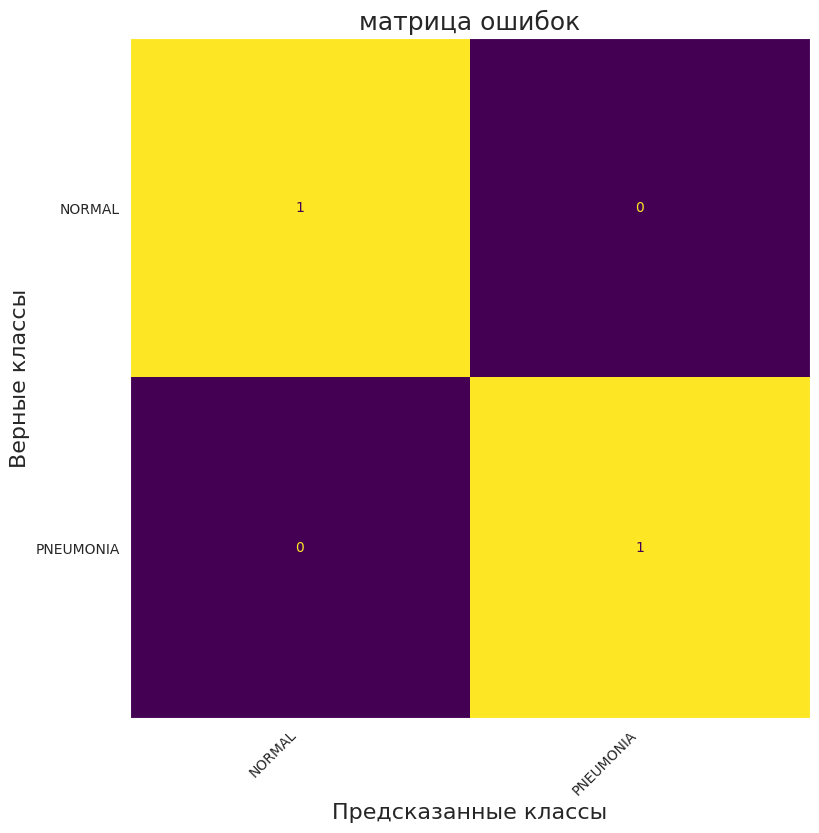


Матрица ошибок для проверочной выборки:


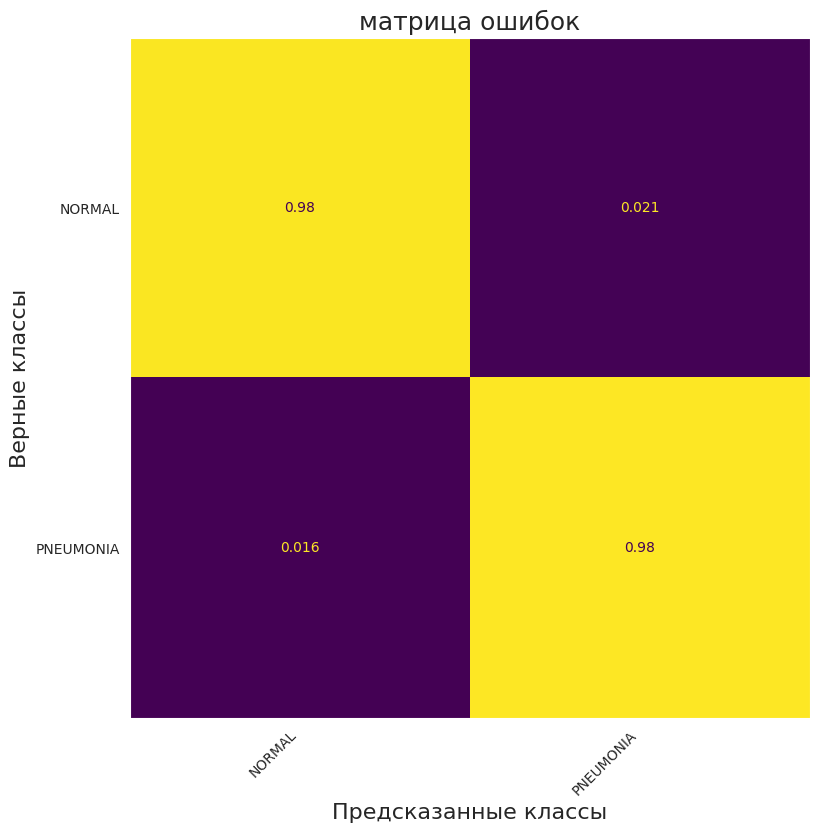

In [ ]:
#@title ### Эксп. №14 (Смена ядра 2 и последующих сверточных слоев) (98.8% 99.1%)
#
# Создание выборок
IMG_HEIGHT = 128
IMG_WIDTH = 128
x_train, x_test, y_train, y_test = worker.create_sets((IMG_HEIGHT, IMG_WIDTH))
#
def create_model():
  model = Sequential()
#
  model.add(Conv2D(128, (2, 2), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
#
  model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
#
  model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
#
  model.add(Dropout(0.2))
#
  # Блок классификации
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Компиляция модели
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model
#
model = create_model()
#
model.summary()
#
# Обучение модели сверточной нейронной сети на подготовленных данных
#
store_learning = model.fit(x_train,
                           y_train,
                           validation_data=(x_test, y_test),
                           shuffle=True,
                           batch_size=25,
                           epochs=30,
                           verbose=1)
#
worker.show_learning_information(store_learning, model)
#

Обучение №1 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


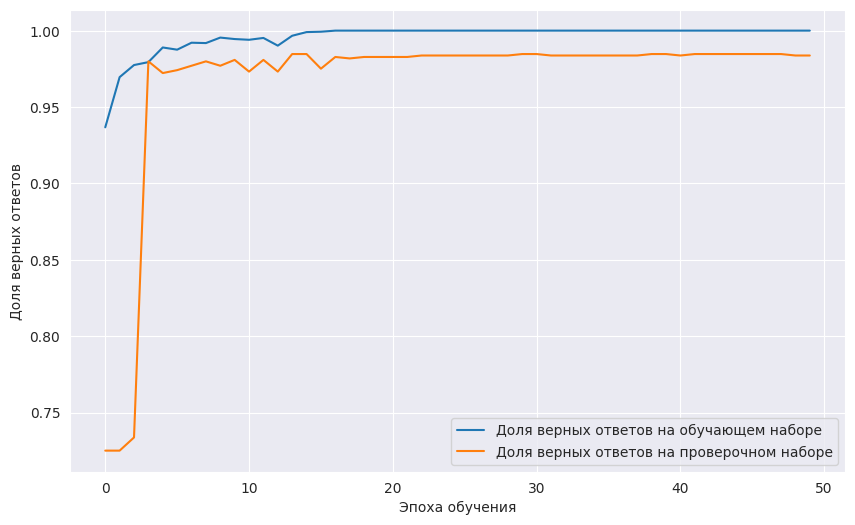





Обучение №2 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.987


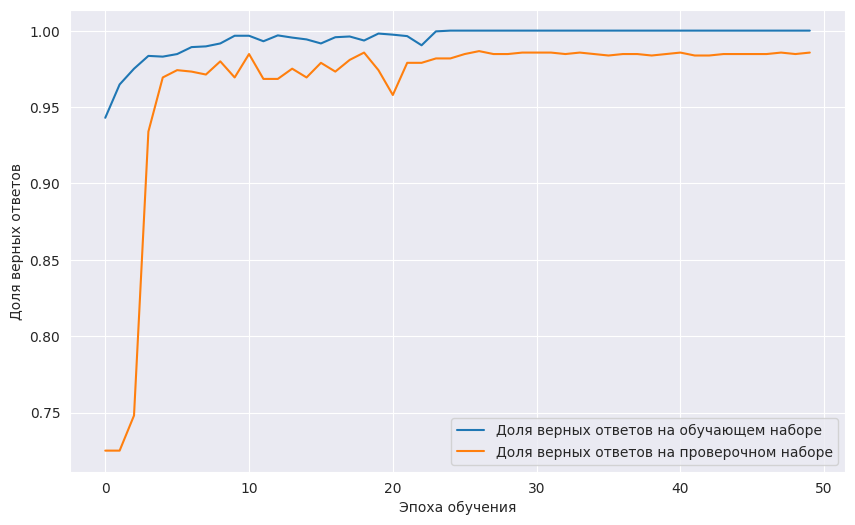





Обучение №3 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


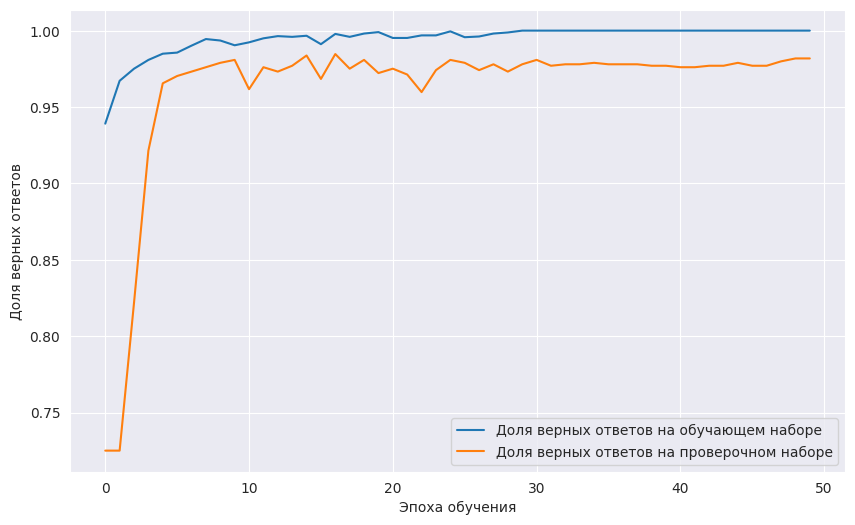





Обучение №4 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


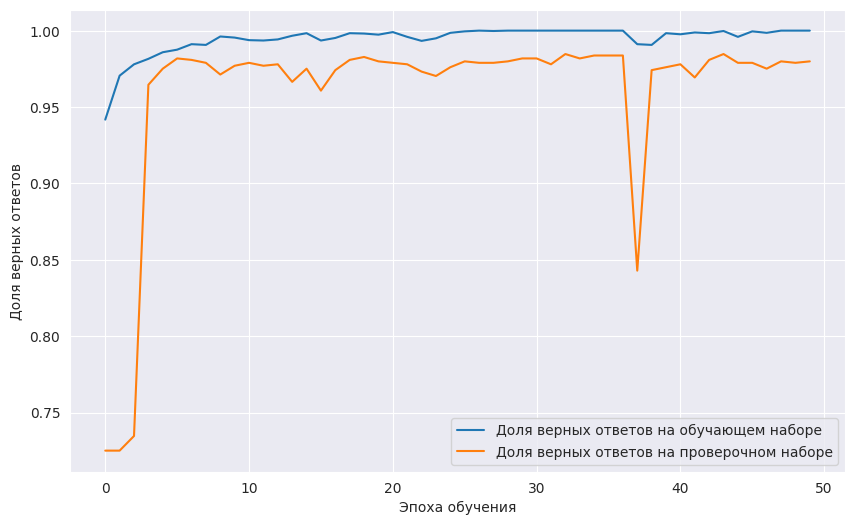





Обучение №5 завершено. Результаты
Максимальная точность на обучающей выборке: 1.0
Максимальная точность на проверочной выборке: 0.985


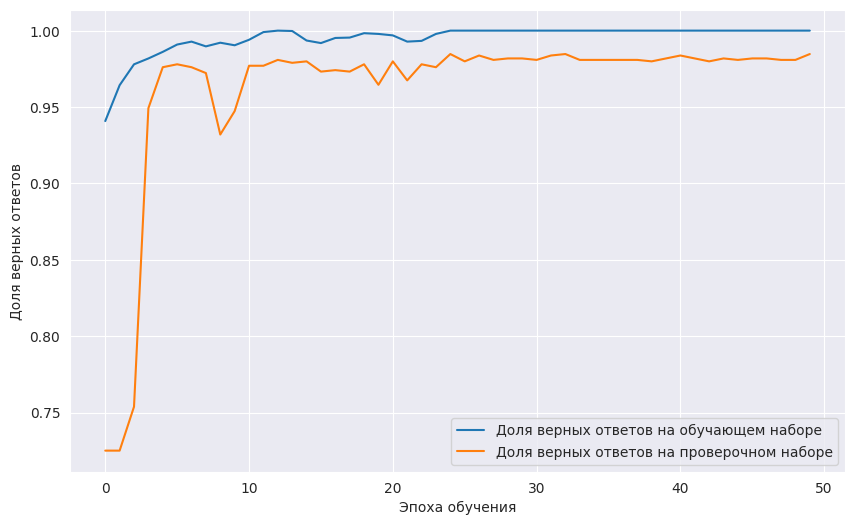





Средняя точность на обучающей выборке: 1.0
Максимальная точность на обучающей выборке: 1.0
Средняя точность на проверочной выборке: 0.985
Максимальная точность на проверочной выборке: 0.987


In [ ]:
#@title Несколько запусков
#
worker.train_model(
    funcModel=create_model,
    count=5)
#

In [ ]:
#@title <h1><b> Эксперименты (предобученные модели)</b></h1>
#
# Загрузка датасета
worker_pretrain.load_dataset()
#

Downloading...
From: https://storage.yandexcloud.net/aiueducation/marketing/datasets/chest_xray.zip
To: /content/chest_xray.zip
100%|██████████| 1.14G/1.14G [01:06<00:00, 17.2MB/s]


Датасет загружен!

Количество классов: 2
Метки классов:
  * NORMAL
  * PNEUMONIA


In [ ]:
#@title ### Эксп. №1 NASNetMobile (99.3%)
#
import time as time
model = worker_pretrain.createAndTrainNASNetMobile()
#
# Схема сети
plot_model(model.layers[4])
#

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
19993432/19993432 [==============================] - 1s 0us/step
Epoch 1/20
131/131 [==============================] - 1477s 11s/step - loss: 0.1716 - accuracy: 0.9341 - val_loss: 0.1051 - val_accuracy: 0.9492
Epoch 2/20
131/131 [==============================] - 1294s 10s/step - loss: 0.0785 - accuracy: 0.9722 - val_loss: 0.0460 - val_accuracy: 0.9827
Epoch 3/20
131/131 [==============================] - 1306s 10s/step - loss: 0.0498 - accuracy: 0.9825 - val_loss: 0.0639 - val_accuracy: 0.9818
Epoch 4/20
131/131 [==============================] - 1323s 10s/step - loss: 0.0377 - accuracy: 0.9851 - val_loss: 0.0597 - val_accuracy: 0.9837
Epoch 5/20
131/131 [==============================] - 1334s 10s/step - loss: 0.0167 - accuracy: 0.9952 - val_loss: 0.0242 - val_accuracy: 0.9942
Epoch 6/20
131/131 [==============================] - 1331s 10s/

In [ ]:
#@title ### Эксп. №2 ResNet50 (99.04%)
#
model = worker_pretrain.createAndTrainResNet()
#
# Схема сети
plot_model(model.layers[4])
#

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
131/131 [==============================] - 2871s 22s/step - loss: 0.2051 - accuracy: 0.9212 - val_loss: 0.1789 - val_accuracy: 0.9156
Epoch 2/20
131/131 [==============================] - 2794s 21s/step - loss: 0.0857 - accuracy: 0.9672 - val_loss: 0.1081 - val_accuracy: 0.9530
Epoch 3/20
131/131 [==============================] - 2711s 21s/step - loss: 0.0741 - accuracy: 0.9763 - val_loss: 0.1609 - val_accuracy: 0.9358
Epoch 4/20
131/131 [==============================] - 2700s 21s/step - loss: 0.0515 - accuracy: 0.9818 - val_loss: 0.0257 - val_accuracy: 0.9904
Epoch 5/20
131/131 [==============================] - 2710s 21s/step - loss: 0.0319 - accuracy: 0.9873 - val_loss: 0.0218 - val_accuracy: 0.9914
Epoch 6/20
131/131 [==============================] - 2712s 21s/

In [ ]:
#@title ### Эксп. №3 ResNet50v2 (99.1%)
#
model = worker_pretrain.createAndTrainResNet50V2()
#
# Схема сети
plot_model(model.layers[4])
#

In [ ]:
#@title ### Эксп. №4 VGG16 (98.9%)
#
model = worker_pretrain.createAndTrainVGG16()
#
# Схема сети
plot_model(model.layers[4])
#

In [ ]:
#@title ### Эксп. №5 VGG19  (98.8%)
#
model = worker_pretrain.createAndTrainVGG19()
#
# Схема сети
plot_model(model.layers[4])
#

In [ ]:
#@title ### Эксп. №6 XCeption (99.4%)
#
model = worker_pretrain.createAndTrainXception()
#
# Схема сети
plot_model(model.layers[4])
#